### <span style="color:olive">Data Science Project</span> 
# Online-learning for Recommendation
### Use the LinearUCB algorithm to build a movie recommendation engine
***

#### Plan :

Notre rapport est divisé en **trois parties**, correspondants au travail effectué ensemble au cours de chaque semaine de projet. Nous nous sommes d'abord familiarisé avec les algorithmes Bandit au cours de la première semaine, puis nous avons étudié l'algorithme Bandit **LinearUCB** utilisé pour la recommandation d'articles pendant la deuxième semaine. Enfin, nous avons tenté de créer un modèle plus réaliste pour la recommandation de film.

#### 0 - Introduction avec les bandits stochastiques
#### 1 - Bandit pour la recommandation : mise en place de l'algorithme LinearUCB 
#### 2 - Application : étude d'un cas réaliste pour la recommandation de films
#### Annexes
***

## 0 - Introduction avec les bandits stochastiques

Les algorithmes de Bandit stochastiques offrent la possibilité d'une première immersion et appréhension de mécanismes utilisés dans le *reinforcement learning (RL)*. Le paradigme du RL réside dans **l'interaction entre un agent et un environnement associé**. L'agent agit dans l'environnement et reçoit un retour sous forme d'un reward qui communique à l'agent de nouvelles informations sur l'environnement. 

Les algorithmes de Bandit s'incrivent dans ce cadre. Voici une illustration de l'idée sous-jacente du bandit (cf' ci-dessous schéma de l'interaction agent-environnement) : l'agent est modélisé par un humain qui peut tirer les leviers de plusieurs machines à sous dans un casino. A chaque instant $t$, son action est donc de choisir une des machines et de tirer son levier. L'**environnement** (la machine tirée) lui donne en retour un **reward** (un gain sous forme d'argent par exemple). Le reward obtenu permet également à l'agent d'avoir plus d'information sur la machine tirée. En effet, l'objectif principal de l'agent est de déterminer la machines qui lui permettra de **maximiser ses gains**. Il doit emprunter la meilleur stratégie qui puisse lui permettre de trouver la machine donnant le plus de gains le plus rapidement possible. 

* Nous renvoyons le lecteur vers le Jupyter Notebook "*Stochastic Bandit*" pour plus d'information sur l'agorithme du Bandit stochastique et différentes stratégies (ou policies) mises en place pour maximiser le reward (ou minimiser le regret (équivalent)) : *random*, *$\epsilon$-greedy* et *Upper Confident Bound (UCB)*

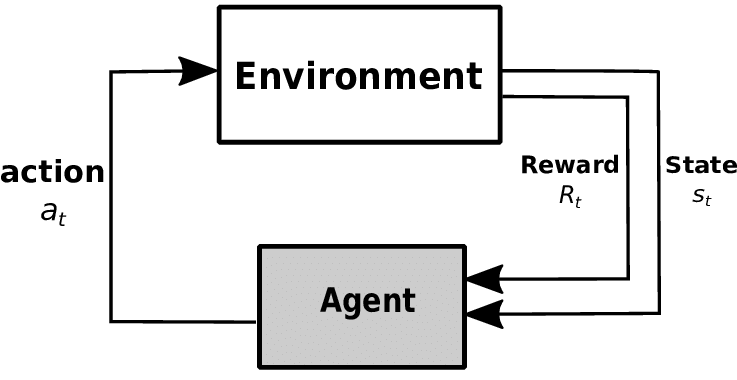

In [1]:
from IPython.display import Image
Image(filename='schema.png') 

In [2]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import time
np.random.seed(42)

### 1 - Bandit pour la recommandation : mise en place de l'algorithme LinearUCB 

Nous avons développé 2 versions de l'algorithme Linear UCB. La première (nommée ALGO 1 dans le notebook) est issue de l'article [*A Contextual-Bandit Approach to Personalized News Article Recommendation*](http://rob.schapire.net/papers/www10.pdf), Li and Al.* La deuxième (nommée ALGO 2) provient du livre [*Bandit Algorithms*](https://tor-lattimore.com/downloads/book/book.pdf) de Tor Lattimore and Csaba Szepesvari. 

Le changement d'approche par rapport à UCB classique réside dans le fait que le reward d'un bras n'est plus seulement un point à estimer mais l'algorithme doit dorénavant modéliser le reward comme une fonction du contexte de l'utilisateur. L'approche "Linear UCB" de l'ALGO 1 propose de prendre une fonction linéaire pour le reward $r_{t,a}$ (où $a$ est l'indice du bras et $t$ le temps) : $E[r_{t,a}|x_{t,a}] = {x_{t,a}}^T {\theta_a}^*$. Il s'agit du produit scalaire entre le vecteur de contexte $x_{t,a}$ (pour nous, les features du film choisi à l'instant t) et un vecteur de feature à apprendre pour chaque bras ${\theta_a}^*$. On parle de modèle disjoint car le vecteur inconnu n'est pas partagé entre les différents bras (pour nous, on en a un par film). 

Dans le cas de l'ALGO 2, le vecteur de feature à apprendre est partagé par tous les films, on a  $E[r_{t,a}|x_{a}] = {x_{a}}^T {\theta}^*$ (où $x_a$ correspond aux features du film $a$ et $\theta^*$ est le vecteur de feature de l'utilisateur que l'on cherche à apprendre

Pour comprendre mieux ce qui se passe : placons nous du point de vue d'un site internet (ex : Netflix, IMDb, Yahoo ! News, etc) qui veut recommander efficacement un film ou article de presse à un utilisateur inconnu. Nous disposons pour cela de 2 matrices U et V. U contient les features des utilisateurs déjà inscrits sur le site. V contient, quant à elle, les features de chaque film contenu dans la base de donnée du site. Ces 2 matrices sont extraites d'une matrice M de ratings qui rassemble les notes que les utilisateurs inscrits ont mis aux films.

Dans un premier temps, le nouvel utilisateur arrive sur notre site et nous ne connaissons pas ses caractéristiques (features, films déjà aimé, etc). L'algorithme va proposer successivement des films à l'utilisateur sur lesquels il cliquera ou non en fonction de ses goûts. L'algorithme va alors apprendre à chaque itération en choissant le film où l'incertitude sur le reward est la plus grande. Au fur et à mesure, l'algorithme sera capable de distinguer le meilleur film c'est-à-dire celui qui minimisera le regret. 

Ci-dessous, voici le code que nous a donné *Laurent Meunier* pour récuperer les features des films (V) et des utilisateurs (U) en utilisant la **Singular Value Decomposition** (SVD). 

In [3]:
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', 
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_table('ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'], 
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_table('ml-1m/users.dat',  sep='::', 
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'], 
                        encoding = 'latin1',
                        engine = 'python')

#Films with sufficient numbers of reviews
N = 1000
ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
top_ratings = ratings_count[ratings_count>=N]
top_ratings.head(10)


ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]

n_users = ratings_topN.UserID.unique().shape[0]
n_movies = ratings_topN.MovieID.unique().shape[0]

#Low rank matrix factorization
R_df = ratings_topN.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)

M = R_df.as_matrix()
sparsity=round(1.0-np.count_nonzero(M)/float(n_users*n_movies),3)

#Sparse SVD with K = 30 features
K = 30
U, s, Vt = svds(M, k = K)
s=np.diag(s)
U = np.dot(U,s)

C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead.
  if sys.path[0] == '':
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


#### a)  LinUCB version disjointe 

#### ALGO 1

Ci-dessous, l'implémentation de l'algorithme présenté dans le papier [*A Contextual-Bandit Approach to Personalized News Article Recommendation*](http://rob.schapire.net/papers/www10.pdf) de Li and Al. A chaque étape, on modifie uniquement $\theta_a$ pour le bras $a$ que l'on a tiré, donc on change uniquement l'estimation du reward $a$ (puisque l'on apprend pour un seul utilisateur uniquement)

In [4]:
### ALGO 1 ###
# Issu de "A Contextual-Bandit Approach to Personalized News Article Recommendation, Li and Al."

def LinUCB_paper(Vt, U, user, alpha, sigma, lambd, T_max, best_score=0):
    (n, d) = U.shape # d : nb de features
    (_, m) = Vt.shape # m : nb de bras
    
    # pre-allocation 
    A = np.zeros((m, d, d)) 
    b = np.zeros((m, d))
    x_a = np.zeros(d) # vecteur contexte
    theta_search = np.zeros((m, d))
    payoff = np.zeros(m)
    upper = 0
    chosen_arm = 0
    reward = np.zeros(T_max)
    regret = [0]
    ecart = np.zeros(T_max)
    
    # initialisation pour chaque bras
    for a in range(m): 
        A[a] = lambd*np.identity(d)
        b[a] = 0
    
    # initialisation reward pour chaque bras
    for a in range(m):         
        x_a = Vt.T[a]           
        inv_A = np.linalg.inv(A[a])      
        theta_search[a] = inv_A.dot(b[a])
        upper = x_a.T.dot(inv_A).dot(x_a)
        payoff[a] = theta_search[a].T.dot(x_a) + alpha * np.sqrt(upper) # Approche UCB 
    
    # Proposition successive de films et observation du reward obtenu
    for t in range(T_max):
        # n° film choisi ; sélection aléatoire si même payoff pour plusieurs films
        chosen_arm = np.random.choice(np.argwhere(payoff == np.amax(payoff)).T[0]) 
        
        x_chosen = Vt.T[chosen_arm] # features fu film choisi 

        # reward avec ajout bruit gaussien pour simuler les possibles erreurs 
        reward[t] = U[user].dot(x_chosen) + np.random.normal(0,sigma)  # mise à jour du reward
        regret.append(regret[-1] + best_score - U[user].dot(x_chosen)) # mise à jour du regret
        
        A[chosen_arm] += np.outer(x_chosen, x_chosen.T) 
        b[chosen_arm] += reward[t] * x_chosen
                 
        inv_A = np.linalg.inv(A[chosen_arm])      
        theta_search[chosen_arm] = inv_A.dot(b[chosen_arm]) 
        upper = x_chosen.T.dot(inv_A).dot(x_chosen)
        
        # On met a jour l'estimation du reward pour le bras qui a été tiré
        payoff[chosen_arm] = theta_search[chosen_arm].T.dot(x_chosen) + alpha * np.sqrt(upper)
        
    best_arm = np.argmax([theta_search[a].T.dot(Vt.T[a]) for a in range(m)])
    return reward, best_arm, regret

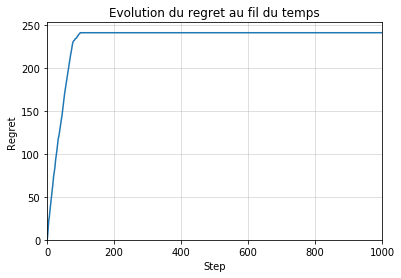

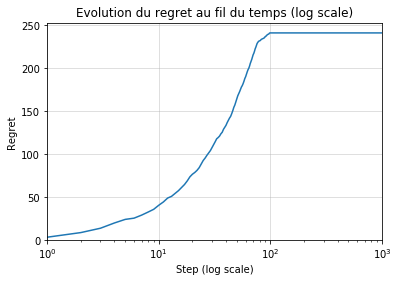

In [5]:
### Plots du regret algo 1
# Hyper paramètres 
T_max = 1000
alpha = 5.5 
sigma = 0.5
lambd = 0.3
r_user = np.random.randint(len(U)) # on sélectionne un utilisateur au hasard

best_score = np.max([U[r_user].dot(Vt.T[i]) for i in range(207)]) # résultat de l'oracle (omniscient)

# Moyenne sur le regret 
avg_regret1 = [0]*T_max
for _ in range(5):
    reward, chosen_arm, regret = LinUCB_paper(Vt, U, r_user,  alpha, sigma, lambd, T_max, best_score=best_score) 
    for i in range(T_max):
        avg_regret1[i] += regret[i]

for i in range(T_max):
    avg_regret1[i] /= 5
    
### Plots
plt.plot(avg_regret1)
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title("Evolution du regret au fil du temps")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

plt.plot(avg_regret1)
plt.xlim(1,T_max)
plt.xscale("log")
plt.xlabel("Step (log scale)")
plt.ylabel("Regret")
plt.title("Evolution du regret au fil du temps (log scale)")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

**Conclusion** : le résultat est très convenable. On apprend bien à sélectionner le meilleur film. Cela peut se constater à la forme logarithmique du regret cumulée.

Cette étude est bien entendue non réaliste dans le sens où on propose plusieurs centaines de fois le même film à l'utilisateur pour être sur que ça lui corresponde bien. De plus, le nombre d'itération nécessaire pour converger vers le film optimal est très grand (ici, T_max = 1000). 

Une étude des hyper paramètres est disponible en annexe (fin) du notebook. Nous avons retenu pour ces courbes les paramètres optimaux. 

Le code ci-dessus calcule le pourcentage d'utilisateurs pour lesquels on apprend bien le film préferé de l'utilisateur, selon les U et V passés en paramétres. On constate bien un fort taux de succès. De plus, l'algorithme est plutot rapide, étant donné le nombre d'epoch ($1000$) effectuée. 

In [6]:
### Accuracy algo 1

T_max = 1000
alpha = 5.5
sigma = 0.5
lambd = 0.1

maxlen = len(U)
count = 0

rTab = np.random.choice([i for i in range(len(U))],100,replace=False)

t_start = time.time()
for u in range(100):
    r = rTab[u]
    #print(r,":",1+u,"/100")
    best = np.argmax([U[r].dot(Vt.T[i]) for i in range(207)])
    reward, chosen_arm, regret = LinUCB_paper(Vt, U, r,  alpha, sigma, lambd, T_max) 
    if chosen_arm == best:
        count += 1

t_end = time.time()
print("Accuracy : ",count,"%")
print("Time / user : ",(t_end-t_start)/100,"s")

Accuracy :  98 %
Time / user :  0.10501555442810058 s


#### ALGO 2

L'implémentation ci-dessous est celle de l'algorithme presenté dans le livre [*Bandit Algorithms*](https://tor-lattimore.com/downloads/book/book.pdf) de Tor Lattimore et Csaba Szepesvari. Ici, le $theta$ est mis à jour à chaque étape, il faut donc calculer à nouveau l'estimation de récompense pour chaque film à toutes les étapes.

In [7]:
### ALGO 2 ###
# Issu de "Bandit Algorithms" de Tor Lattimore and Csaba Szepesvari

def LinUCB_book(user,Vt,lambd,sigma,alpha,T_max):
    
    (n,d) = U.shape
    (_,m) = Vt.shape
    V = lambd*np.identity(d)
    theta = np.zeros(d)
    N = [0]*m
    D = np.zeros(d)
    Regret = [0]
    score_u0 = [user.dot(Vt.T[i]) for i in range(207)]
    best_score = np.max(score_u0)
    movies = [i for i in range(m)]
    
    for t in range(T_max):
        prod_scal = [theta.dot(Vt.T[i])+alpha/np.sqrt(N[i]+1) for i in range(m)]
        best_movie = np.argmax(prod_scal)
        reward = user.dot(Vt.T[best_movie]) +  np.random.normal(0,sigma)
        V += np.outer(Vt.T[best_movie],Vt.T[best_movie])
        D += Vt.T[best_movie]*reward
        N[best_movie] += 1
        theta = np.linalg.inv(V).dot(D)
        got_score = score_u0[best_movie]
        Regret.append(Regret[-1] + best_score-got_score)
    best_movie = np.argmax([theta.dot(Vt.T[i]) for i in range(m)])
    return theta,Regret,best_movie

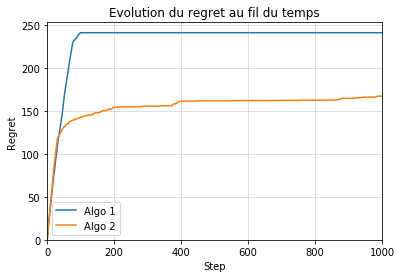

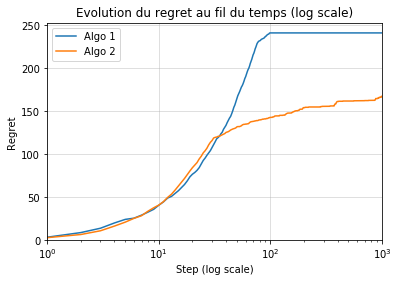

In [8]:
### Plots du regret algo 2

# Hyper paramètres 
T_max = 1000
sigma = 0.5

lambd = 0
alpha = np.sqrt(2*np.log(T_max)/np.log(10))

score_u0 = [U[r_user].dot(Vt.T[i]) for i in range(207)]
best_score = np.max(score_u0)
best_movie_off = np.argmax(score_u0)
# print(user,best_movie_off,best_score)
    
avg_regret2 = [0]*T_max 
for i in range(5):
    theta,regret,best_arm = LinUCB_book(U[r_user],Vt,lambd,sigma,alpha,T_max)
    for i in range(T_max):
        avg_regret2[i] += regret[i]
    
for i in range(T_max):
    avg_regret2[i] /= 5

plt.plot(avg_regret1,label="Algo 1")
plt.plot(avg_regret2,label="Algo 2")
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title("Evolution du regret au fil du temps")
plt.ylim(0)
plt.legend()
plt.grid(alpha=0.5)
plt.show()
    
plt.plot(avg_regret1,label="Algo 1")
plt.plot(avg_regret2,label="Algo 2")
plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Step (log scale)")
plt.ylabel("Regret")
plt.title("Evolution du regret au fil du temps (log scale)")
plt.ylim(0)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [9]:
### Accuracy algo 2

T_max = 1000
sigma = 0.5

lambd = 0
alpha = np.sqrt(2*np.log(T_max)/np.log(10))

count = 0

rTab = np.random.choice([i for i in range(len(U))],100,replace=False)

t_start = time.time()
for u in range(100):
    r = rTab[u]
    best = np.argmax([U[r].dot(Vt.T[i]) for i in range(207)])
    theta,regret,best_arm = LinUCB_book(U[r],Vt,lambd,sigma,alpha,T_max)
    if best_arm == best:
        count += 1

t_end = time.time()

print("Accuracy : ",count," %")
print("Time / user : ",(t_end-t_start)/100,"s")

Accuracy :  98  %
Time / user :  0.7232553243637085 s


L'approche utilisée dans les deux algorithmes est légèrement différente. Dans l'ALGO 1, on calcule un vecteur $\theta_a$ par film. L'ALGO 2 considère un vecteur $\theta$ qui contient va en fait apprendre les features de l'utilisateur en utilisant les features des films dans la base de données. Cette deuxième approche étant plus similaire au problème que l'on souhaitait résoudre, c'est donc celle que nous avons choisi pour la troisième partie du projet.

L'ALGO 1 est netemment plus rapide que rapport à l'ALGO 2. Dans les 2 cas, on obtient une très bonne accuracy : environ 95% pour 1000 étapes et > 99% pour 10000 étapes.

#### b)  LinUCB version jointe ou hybride

Nous avons voulu pousser l'étude en considérant le modèle hybride détaillé par *Li and Al*. Jusqu'ici, cette approche nous avait fait calculer un vecteur $\theta_a$ par film $a$. L'idée est d'incorporer un vecteur inconnu $\beta^*$ partagé par tous les films dans le calcul du reward.

In [10]:
def HybridLinUCB(Vt, U, user, alpha, sigma, lambd, T_max, best_score=0):
    (n, d) = U.shape # d : nb de features
    (_, m) = Vt.shape # m : nb de bras
    k = d*d # nb de common features
    
    A0 = np.identity(k)
    b0 = np.zeros(k)
    
    A = np.zeros((m, d, d)) 
    B = np.zeros((m, d, k))
    b = np.zeros((m, d))
    x_a = np.zeros(d) # vecteur contexte
    z_a = np.zeros(k) # vecteur commun features pour un film/un utilisateur
    
    theta_search = np.zeros((m, d))
    payoff = np.zeros(m)
    upper = 0
    chosen_arm = 0
    reward = np.zeros(T_max)
    regret = [0]
    
    inv_A0 = np.linalg.inv(A0)
    
    beta_search = inv_A0.dot(b0)
    
    for a in range(m): 
        A[a] = lambd*np.identity(d)
        B[a] = np.zeros(k)
        b[a] = np.zeros(d)
    
    #Pour chaque film
    for a in range(m):
        x_a = Vt.T[a,]
        z_a = np.outer(Vt.T[a,],U[user,]).flatten()
        
        inv_A = np.linalg.inv(A[a])
        
        theta_search[a] = inv_A.dot(b[a]-B[a].dot(beta_search))
        
        upper = z_a.T.dot(inv_A0).dot(z_a) - 2*z_a.T.dot(inv_A0).dot(B[a].T).dot(inv_A).dot(x_a) + x_a.T.dot(inv_A).dot(x_a) + x_a.T.dot(inv_A).dot(B[a]).dot(inv_A0).dot(B[a].T).dot(inv_A).dot(x_a)
        payoff[a] = (z_a.T).dot(beta_search) + x_a.T.dot(theta_search[a]) + alpha * np.sqrt(upper)
        
    for t in range(T_max):
        chosen_arm = np.random.choice(np.argwhere(payoff == np.amax(payoff)).T[0])
        x_chosen = Vt.T[chosen_arm]
        z_chosen =  np.outer(Vt.T[chosen_arm],U[user,]).flatten()

        reward[t] = U[user].dot(x_chosen) + np.random.normal(0,sigma)
        regret.append(regret[-1] + best_score - U[user].dot(x_chosen))
        
        inv_A = np.linalg.inv(A[chosen_arm]) 
        
        A0 += (B[chosen_arm].T).dot(inv_A).dot(B[chosen_arm])
        b0 += (B[chosen_arm].T).dot(inv_A).dot(b[chosen_arm])
        
        A[chosen_arm] += np.outer(x_chosen, x_chosen.T)
        B[chosen_arm] += np.outer(x_chosen, z_chosen.T)
        b[chosen_arm] += reward[t] * x_chosen
        
        #Mise à jour de A[chosen_arm], donc mise à jour de l'inverse 
        inv_A = np.linalg.inv(A[chosen_arm])
        
        A0 += np.outer(z_chosen,z_chosen.T) - (B[chosen_arm].T).dot(inv_A).dot(B[chosen_arm])
        b0 += reward[t]*z_chosen - (B[chosen_arm].T).dot(inv_A).dot(b[chosen_arm])
        
        theta_search[chosen_arm] = inv_A.dot(b[chosen_arm]-B[chosen_arm].dot(beta_search))
        upper = z_chosen.T.dot(inv_A0).dot(z_chosen) - 2*z_chosen.T.dot(inv_A0).dot(B[chosen_arm].T).dot(inv_A).dot(x_chosen) + x_chosen.T.dot(inv_A).dot(x_chosen) + x_chosen.T.dot(inv_A).dot(B[chosen_arm]).dot(inv_A0).dot(B[chosen_arm].T).dot(inv_A).dot(x_chosen)

        payoff[chosen_arm] = (z_chosen.T).dot(beta_search) + theta_search[chosen_arm].T.dot(x_chosen) + alpha * np.sqrt(upper)
       
    return reward, chosen_arm, regret

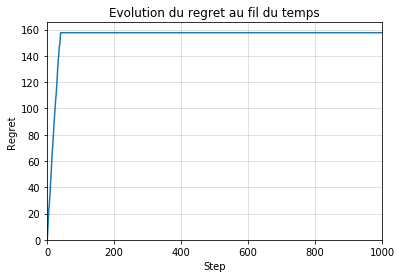

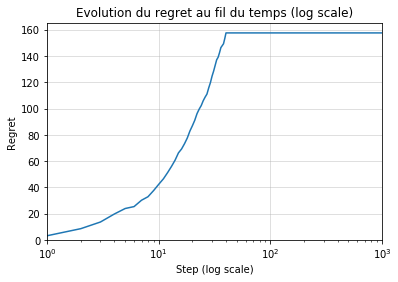

In [11]:
# Hyper paramètres
T_max = 1000
alpha = 0.5
sigma = 0.5
lambd = 0.3
best_score = np.max([U[r_user].dot(Vt.T[i]) for i in range(207)]) # résultat de l'oracle

avg_regret_hybrid = [0]*T_max
for _ in range(1):
    reward, chosen_arm, regret = HybridLinUCB(Vt, U, r_user,  alpha, sigma, lambd, T_max, best_score=best_score) 
    for i in range(T_max):
        avg_regret_hybrid[i] += regret[i]

for i in range(T_max):
    avg_regret_hybrid[i] /= 1
    
plt.plot(avg_regret_hybrid)
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title("Evolution du regret au fil du temps")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

plt.plot(avg_regret_hybrid)
plt.xlim(1,T_max)
plt.xlabel("Step (log scale)")
plt.xscale("log")
plt.ylabel("Regret")
plt.title("Evolution du regret au fil du temps (log scale)")
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

L'algorithme **HybridLinUCB** ne fonctionne pas parfaitement mais parvient tout de même à un regret constant dans la plupart des cas.

# 2 - Application : étude d'un cas réaliste pour la recommandation de films

Dans la partie précédente, les valeurs de l'accuracy obtenue semble assez bonne : 95% en 0.1 secondes et 99 % en un peu moins d'une seconde. Cependant, cette accuracy est en réalité calculée comme le pourcentage d'utilisateurs dont le film préféré (avec features issus de la factorisation de matrices) est le même que celui prédit par l'algorithme (apprentissage des features optimales = du film que préfera potentiellement l'utilisateur). Or, l'apprentissage des features suppose plusieurs choses :

* Le site internet (ex : Netflix) connaît déjà toutes les features des films
* Les features des films sont correctes
* Il est possible de proposer le même film une centaine de fois à un utilisateur
* Tous les ratings des films non vus sont connus (pour l'entrainement)

Or, comme la factorisation de matrice avec la méthode SVD conserve les films "non vus" avec des ratings d'environ 0, ce que nos précédents algorithmes font peut se résumer à : *"on apprend à proposer à un utilisateur le film qu'il a préferé en lui proposant une centaine de fois avant d'être sûr que c'est bien celui là qu'il préfère"*.


Nous avons donc cherché à nous rapprocher d'une étude de cas plus réaliste. Pour cela, **notre scénario est dorénavant le suivant:**

* A un instant $t= T_0$, le site internet considéré (ex : Netflix, IMDb, etc) contient $n_0$ utilisateurs et $m_0$ films. Les features des utilisateurs et des films seront calculés grâce à l'approche projet n°2 ("model based collaborative filtering"). 
* Ensuite, à des instants ultérieurs $T_1,....,T_k$ (très peu espacés), nous ajoutons des utilisateurs (qui viennent de s'inscrire sur le site, par exemple) et des films (qui viennent de sortir, par exemple). A chaque nouvel ajout (d'utilisateur ou de film), nous devons apprendre les features du nouvel élement à partir de ceux déjà existants. La méthode reste la même : nous devons proposer des films à des utilisateurs et en tentant de prédire le plus rapidement possible lequel sera le meilleur, afin de minimiser le regret.

L'idée est en effet que, pour un site comme Netflix, calculer les features des utilisateurs et des films à l'aide de la méthode du projet 2 **peut être plutôt couteuse**. Ils ne peuvent donc pas forcément se permettre de la calculer toutes les heures/jours. Notre approche permet d'obtenir tout de même des features sur les nouveaux films et utilisateurs entre deux calculs des features par la méthode du projet 2.

Nous nous concentrons plus ici sur la construction d'une nouvelle approche que sur la recherche des meilleurs paramètres, car ce travail peu être fait plus facilement en aval.

# A. Introduction

Ci-dessous, voici le code que nous a donné Laurent Meunier pour récuperer les features des films et des utilisateurs. Dûe à la sparsité élévée de la matrice (environ 70%), les features apprennent aussi à donner $0$ lorsque le film n'a pas été encore vu, ce qui simplifie beaucoup le travail de nos algorithmes, qui n'ont besoin de chercher le meilleur film que parmis ceux déjà vus. 

En plus de ne garder que les films aves 1000 ratings, nous avons également choisit les utilisateurs avec au moins 20 films vus parmis la selection de films à 1000 ratings.

In [12]:
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', 
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_table('ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'], 
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_table('ml-1m/users.dat',  sep='::', 
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'], 
                        encoding = 'latin1',
                        engine = 'python')

N = 1000 #Nombre minimum de ratings sur un film
N2 = 20 #Nombre minimum de ratings pour un utilisateur

ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
top_ratings = ratings_count[ratings_count>=N]
ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]
ratings_count_user = ratings_topN.groupby(by="UserID",as_index=True).size()
top_ratings_user = ratings_count_user[ratings_count_user >= N2]
ratings_topNN2 = ratings_topN[ratings_topN.UserID.isin(top_ratings_user.index)] #Seuls les ratings que l'on veut sont ici

n_users = ratings_topNN2.UserID.unique().shape[0]
n_movies = ratings_topNN2.MovieID.unique().shape[0]
print('Nombre d''utilisateurs = {} | Nombtre de films = {}'.format(n_users, n_movies))

R_df = ratings_topNN2.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
M = R_df.as_matrix()
(m1,m2) = M.shape

## Calcul de sparsité
sparsity = round(1.0-np.count_nonzero(M)/float(n_users*n_movies),3)
#sparsity_train=round(1.0-np.count_nonzero(M_train)/float(n_users*n_movies),3)
#sparsity_test=round(1.0-np.count_nonzero(M_test)/float(n_users*n_movies),3)
print('Sparsity = {}%'.format(sparsity*100))
#print("sparsity :",sparsity_train)
#print("sparsity :",sparsity_test)


## Recuperation des features
K = 20 #Nombre de features
U, s, Vt = svds(M, k = K)
s=np.diag(s)
U = np.dot(U,s)
(n,m) = U.shape[0],Vt.shape[1]
features_users = U
features_movies = Vt.T

C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead.
  if sys.path[0] == '':


Nombre dutilisateurs = 4351 | Nombtre de films = 207
Sparsity = 68.4%


C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Ci-dessous, on observe la distribution du nombre de film vu par utilisateur dans notre petite matrice (dimensions : environ 4000x200)

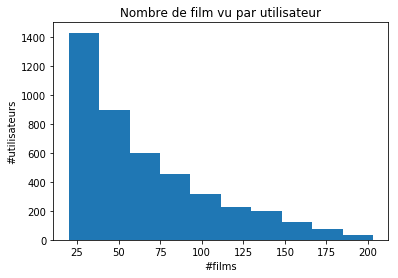

In [13]:
users_movies = []
for i in range(len(M)):
    count = 0
    for j in range(len(M[i])):
        if M[i][j] > 0:
            count += 1
    users_movies.append(count)

plt.xlabel("#films")
plt.ylabel("#utilisateurs")
plt.title("Nombre de film vu par utilisateur")
plt.hist(users_movies)
plt.show()

# B. Démarrage avec un sous-ensemble

Les algorithmes suivants sont la réécriture de l'ALGO 2 présenté dans la seconde partie, avec de nombreuses améliorations et subtilités :

* Il est possible d'accélerer l'algorithme en spécifiant toutes les combiens d'étapes l'on souhaite inverser la matrice de design (car c'est une opération coûteuse). Espacer ces inversions d'environ 5 étapes ne réduit pas beaucoup l'accuracy et réduit considérablement le temps d'execution de l'algorithme

* Il est possible de proposer plusieurs films d'un coup à l'utilisateur (par exemple, lui proposer les 5 meilleurs films) comme le ferait un vrai site de streaming

* On spécifie les features à apprendre U (features des utilisateurs) et V (features des films) à l'algorithme et le nombre de films $m_0$ et d'utilisateurs $n_0$ au démmarrage. L'algorithme commence en ne connaissant que les $n_0$ premieres features de U et $m_0$ premieres features de V. A chaque étape, on ajoute un nouvel élement et on apprend ses features, que l'on rajoute à la liste des features U et V. L'élement peut être un utilisateurs ou bien un film : il suffit d'inverser leur rôle. 

In [14]:
def LinUCB_select_movie(est_features_user,est_features_movies,features_user,features_movies,sigma,alpha,N,nb_movies,nb_sugg):
    #On calcule les estimations des notes de chaque film pour l'utilisateur en cours d'apprentissage
    prod_scal = [est_features_user.dot(est_features_movies[i])+alpha/np.sqrt(N[i]+1) for i in range(nb_movies)]
    
    #On chosisit le(s) meilleur(s) film(s) selon nos estimations
    chosen_movies = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    
    #On récupére le(s) reward(s) pour ce(s) film(s)
    rewards = [features_user.dot(features_movies[chosen_movie]) + np.random.normal(0,sigma) for chosen_movie in chosen_movies]
    
    #On calcul le regret pour cette étape
    max_rew = np.max([features_user.dot(features_movies[i]) for i in range(nb_movies)])
    regret = max_rew-features_user.dot(features_movies[chosen_movies[0]])
    
    return chosen_movies, rewards,regret

## La fonction ci-dessous fait la même chose que celle du dessus, mais avec les rôles de films et d'utilisateurs
## interchangés
def LinUCB_select_user(est_features_movie,est_features_users,features_users,features_movie,sigma,alpha,N,nb_users,nb_sugg):
    prod_scal = [est_features_users[i].dot(est_features_movie)+alpha/np.sqrt(N[i]+1) for i in range(nb_users)]
    chosen_users = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    rewards = [features_users[chosen_user].dot(features_movie) + np.random.normal(0,sigma) for chosen_user in chosen_users]
    max_rew = np.max([features_users[i].dot(features_movie) for i in range(nb_users)])
    regret = max_rew-features_users[chosen_users[0]].dot(features_movie)
    return chosen_users, rewards,regret

In [15]:
## Fonction pour initialiser l'apprentissage
def LinUCB_init(m,d,lambd):
    #Le lambda permet d'avoir une matrice inversible. Cependant, on le veut le plus petit possible pour ne pas
    #gêner l'apprentissage
    V = lambd*np.identity(d)
    theta = np.zeros(d)
    N = np.zeros(m)
    D = np.zeros(d)
    return V,D,theta,N

## Reprise de la fonction Linear UCB (dév. la semaine derniere) 
## avec l'ajout d'un grande nombre d'utilisateurs et de films
def LinUCB(features_movies,features_users,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,start=(150,4000),nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("INIT...")
    (n,d) = features_users.shape
    (m,_) = features_movies.shape
    
    #On récupere le nombre de films et d'utilisateurs de notre site au démarage
    (nb_movies,nb_users) = start
    
    features_users_l = features_users[:nb_users]
    features_movies_l = features_movies[:nb_movies]
    
    alpha = np.sqrt(2*np.log(T_max)/np.log(10)) #C'est notre upper bound
    R = [0]
    
    for elemi in range(new_elems):
        #On ajoute un nouvel élément (1 utilisateur ou 1 film)
        if nb_movies == m and nb_users == n: #Si tout a été ajouté, on termine
            return features_users_l,features_movies_l,R
        elif nb_movies == m: #Si tous les films ajoutés, on ajoute 1 utilisateur
            nb_users += 1
            is_user = True
        elif nb_users == n: #Si tous les utilisateurs ajoutés, on ajoute 1 film
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand() #Sinon on choisit au hasard selon la probabilité ajoutée en paramètre
            if r < proba: #1/4
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
                    
        #Pour chaque nouvel élémént, on initialise ensuite les variables d'apprentissage
        if is_user:
            if verbose:
                print(elemi,". ADDING USER ",nb_users)
            V,D,theta,N = LinUCB_init(nb_movies,d,lambd)
        else:
            if verbose:
                print(elemi,". ADDING MOVIE ",nb_movies)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        
        #On apprend les features pendant T_max étapes.
        for t in range(T_max):
            if is_user: #Si le nouvel arrivant est un utilisateur
                chosen_movies,rewards,regret = LinUCB_select_movie(theta,features_movies_l,features_users[nb_users-1],features_movies,sigma,alpha,N,nb_movies,nb_sugg)
                R.append(R[-1] + regret)
                
                #Algorithme LinUCB classique, avec comme subtilité supplémentaire que l'on propose plus d'un seul film
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[chosen_movies[i]]+= 1
                #Pour éviter des caculs trop long, nous n'inversons pas la matrice à chaque étape
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
                    
            else: #Si le nouvel arrivant est un film
                chosen_users,rewards,regret = LinUCB_select_user(theta,features_users_l,features_users,features_movies[nb_movies-1],sigma,alpha,N,nb_users,nb_sugg)
                R.append(R[-1] + regret)
                
                #Algorithme LinUCB classique, avec comme subtilité supplémentaire que l'on propose plus d'un seul film
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[chosen_users[i]]+= 1
                #Pour éviter des caculs trop long, nous n'inversons pas la matrice à chaque étape
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
                    
        #On ajoute le nouvel arrivant dans les features apprises et il servira à calculer les prochaines
        #features à apprendre (pour les autres arrivants)      
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
            
    return features_users_l,features_movies_l,R

Essayons par exemple de démmarrer avec 15 films sur 207 et 500 utilisateurs sur 4000 dans notre base de données, et observons ce qu'il se passe avec 50 étapes d'apprentissage pour chaque nouvel élement.

In [16]:

Ulearn,Vlearn,regret = LinUCB(features_movies,features_users,new_elems=7000,verbose=True,T_max=50,start=(15,500),nb_sugg=5,big_step=2,proba=1/10)

INIT...
0 . ADDING USER  501
1 . ADDING MOVIE  16
2 . ADDING USER  502
3 . ADDING USER  503
4 . ADDING USER  504
5 . ADDING USER  505
6 . ADDING USER  506
7 . ADDING USER  507
8 . ADDING USER  508
9 . ADDING USER  509
10 . ADDING USER  510
11 . ADDING USER  511
12 . ADDING USER  512
13 . ADDING USER  513
14 . ADDING USER  514
15 . ADDING USER  515
16 . ADDING USER  516
17 . ADDING MOVIE  17
18 . ADDING USER  517
19 . ADDING USER  518
20 . ADDING USER  519
21 . ADDING USER  520
22 . ADDING USER  521
23 . ADDING USER  522
24 . ADDING USER  523
25 . ADDING USER  524
26 . ADDING USER  525
27 . ADDING USER  526
28 . ADDING USER  527
29 . ADDING USER  528
30 . ADDING USER  529
31 . ADDING USER  530
32 . ADDING USER  531
33 . ADDING USER  532
34 . ADDING USER  533
35 . ADDING MOVIE  18
36 . ADDING MOVIE  19
37 . ADDING USER  534
38 . ADDING USER  535
39 . ADDING USER  536
40 . ADDING USER  537
41 . ADDING USER  538
42 . ADDING USER  539
43 . ADDING MOVIE  20
44 . ADDING USER  540
45 . ADDING 

361 . ADDING USER  830
362 . ADDING USER  831
363 . ADDING USER  832
364 . ADDING USER  833
365 . ADDING USER  834
366 . ADDING USER  835
367 . ADDING USER  836
368 . ADDING USER  837
369 . ADDING USER  838
370 . ADDING USER  839
371 . ADDING USER  840
372 . ADDING USER  841
373 . ADDING USER  842
374 . ADDING MOVIE  48
375 . ADDING MOVIE  49
376 . ADDING USER  843
377 . ADDING USER  844
378 . ADDING USER  845
379 . ADDING USER  846
380 . ADDING USER  847
381 . ADDING USER  848
382 . ADDING USER  849
383 . ADDING USER  850
384 . ADDING USER  851
385 . ADDING USER  852
386 . ADDING USER  853
387 . ADDING MOVIE  50
388 . ADDING USER  854
389 . ADDING USER  855
390 . ADDING USER  856
391 . ADDING USER  857
392 . ADDING USER  858
393 . ADDING USER  859
394 . ADDING USER  860
395 . ADDING USER  861
396 . ADDING USER  862
397 . ADDING USER  863
398 . ADDING USER  864
399 . ADDING USER  865
400 . ADDING USER  866
401 . ADDING USER  867
402 . ADDING USER  868
403 . ADDING USER  869
404 . ADDIN

718 . ADDING USER  1154
719 . ADDING USER  1155
720 . ADDING USER  1156
721 . ADDING USER  1157
722 . ADDING MOVIE  81
723 . ADDING USER  1158
724 . ADDING USER  1159
725 . ADDING USER  1160
726 . ADDING USER  1161
727 . ADDING USER  1162
728 . ADDING USER  1163
729 . ADDING USER  1164
730 . ADDING MOVIE  82
731 . ADDING USER  1165
732 . ADDING USER  1166
733 . ADDING USER  1167
734 . ADDING USER  1168
735 . ADDING USER  1169
736 . ADDING USER  1170
737 . ADDING USER  1171
738 . ADDING USER  1172
739 . ADDING USER  1173
740 . ADDING USER  1174
741 . ADDING MOVIE  83
742 . ADDING USER  1175
743 . ADDING USER  1176
744 . ADDING USER  1177
745 . ADDING USER  1178
746 . ADDING MOVIE  84
747 . ADDING USER  1179
748 . ADDING USER  1180
749 . ADDING USER  1181
750 . ADDING USER  1182
751 . ADDING USER  1183
752 . ADDING USER  1184
753 . ADDING MOVIE  85
754 . ADDING USER  1185
755 . ADDING USER  1186
756 . ADDING USER  1187
757 . ADDING USER  1188
758 . ADDING USER  1189
759 . ADDING USER  11

1061 . ADDING USER  1472
1062 . ADDING USER  1473
1063 . ADDING USER  1474
1064 . ADDING USER  1475
1065 . ADDING USER  1476
1066 . ADDING USER  1477
1067 . ADDING USER  1478
1068 . ADDING USER  1479
1069 . ADDING USER  1480
1070 . ADDING MOVIE  106
1071 . ADDING USER  1481
1072 . ADDING USER  1482
1073 . ADDING USER  1483
1074 . ADDING USER  1484
1075 . ADDING USER  1485
1076 . ADDING USER  1486
1077 . ADDING USER  1487
1078 . ADDING USER  1488
1079 . ADDING USER  1489
1080 . ADDING USER  1490
1081 . ADDING USER  1491
1082 . ADDING USER  1492
1083 . ADDING USER  1493
1084 . ADDING USER  1494
1085 . ADDING USER  1495
1086 . ADDING USER  1496
1087 . ADDING USER  1497
1088 . ADDING USER  1498
1089 . ADDING USER  1499
1090 . ADDING USER  1500
1091 . ADDING USER  1501
1092 . ADDING MOVIE  107
1093 . ADDING USER  1502
1094 . ADDING USER  1503
1095 . ADDING USER  1504
1096 . ADDING USER  1505
1097 . ADDING USER  1506
1098 . ADDING USER  1507
1099 . ADDING USER  1508
1100 . ADDING USER  1509


1393 . ADDING USER  1776
1394 . ADDING USER  1777
1395 . ADDING USER  1778
1396 . ADDING USER  1779
1397 . ADDING USER  1780
1398 . ADDING USER  1781
1399 . ADDING USER  1782
1400 . ADDING USER  1783
1401 . ADDING USER  1784
1402 . ADDING USER  1785
1403 . ADDING USER  1786
1404 . ADDING USER  1787
1405 . ADDING MOVIE  134
1406 . ADDING USER  1788
1407 . ADDING USER  1789
1408 . ADDING USER  1790
1409 . ADDING USER  1791
1410 . ADDING USER  1792
1411 . ADDING USER  1793
1412 . ADDING USER  1794
1413 . ADDING USER  1795
1414 . ADDING USER  1796
1415 . ADDING USER  1797
1416 . ADDING USER  1798
1417 . ADDING USER  1799
1418 . ADDING USER  1800
1419 . ADDING USER  1801
1420 . ADDING USER  1802
1421 . ADDING USER  1803
1422 . ADDING USER  1804
1423 . ADDING MOVIE  135
1424 . ADDING USER  1805
1425 . ADDING USER  1806
1426 . ADDING USER  1807
1427 . ADDING USER  1808
1428 . ADDING USER  1809
1429 . ADDING USER  1810
1430 . ADDING USER  1811
1431 . ADDING USER  1812
1432 . ADDING USER  1813


1721 . ADDING USER  2069
1722 . ADDING USER  2070
1723 . ADDING USER  2071
1724 . ADDING USER  2072
1725 . ADDING USER  2073
1726 . ADDING USER  2074
1727 . ADDING USER  2075
1728 . ADDING USER  2076
1729 . ADDING USER  2077
1730 . ADDING USER  2078
1731 . ADDING USER  2079
1732 . ADDING USER  2080
1733 . ADDING USER  2081
1734 . ADDING USER  2082
1735 . ADDING USER  2083
1736 . ADDING USER  2084
1737 . ADDING USER  2085
1738 . ADDING USER  2086
1739 . ADDING USER  2087
1740 . ADDING USER  2088
1741 . ADDING USER  2089
1742 . ADDING USER  2090
1743 . ADDING USER  2091
1744 . ADDING MOVIE  169
1745 . ADDING USER  2092
1746 . ADDING USER  2093
1747 . ADDING USER  2094
1748 . ADDING USER  2095
1749 . ADDING USER  2096
1750 . ADDING USER  2097
1751 . ADDING USER  2098
1752 . ADDING USER  2099
1753 . ADDING MOVIE  170
1754 . ADDING USER  2100
1755 . ADDING USER  2101
1756 . ADDING USER  2102
1757 . ADDING USER  2103
1758 . ADDING USER  2104
1759 . ADDING USER  2105
1760 . ADDING MOVIE  171


2050 . ADDING USER  2364
2051 . ADDING USER  2365
2052 . ADDING USER  2366
2053 . ADDING USER  2367
2054 . ADDING USER  2368
2055 . ADDING USER  2369
2056 . ADDING USER  2370
2057 . ADDING USER  2371
2058 . ADDING USER  2372
2059 . ADDING USER  2373
2060 . ADDING USER  2374
2061 . ADDING USER  2375
2062 . ADDING USER  2376
2063 . ADDING USER  2377
2064 . ADDING USER  2378
2065 . ADDING USER  2379
2066 . ADDING USER  2380
2067 . ADDING USER  2381
2068 . ADDING USER  2382
2069 . ADDING MOVIE  203
2070 . ADDING USER  2383
2071 . ADDING MOVIE  204
2072 . ADDING USER  2384
2073 . ADDING USER  2385
2074 . ADDING USER  2386
2075 . ADDING USER  2387
2076 . ADDING USER  2388
2077 . ADDING USER  2389
2078 . ADDING USER  2390
2079 . ADDING USER  2391
2080 . ADDING USER  2392
2081 . ADDING USER  2393
2082 . ADDING USER  2394
2083 . ADDING USER  2395
2084 . ADDING USER  2396
2085 . ADDING USER  2397
2086 . ADDING USER  2398
2087 . ADDING USER  2399
2088 . ADDING USER  2400
2089 . ADDING USER  2401


2379 . ADDING USER  2688
2380 . ADDING USER  2689
2381 . ADDING USER  2690
2382 . ADDING USER  2691
2383 . ADDING USER  2692
2384 . ADDING USER  2693
2385 . ADDING USER  2694
2386 . ADDING USER  2695
2387 . ADDING USER  2696
2388 . ADDING USER  2697
2389 . ADDING USER  2698
2390 . ADDING USER  2699
2391 . ADDING USER  2700
2392 . ADDING USER  2701
2393 . ADDING USER  2702
2394 . ADDING USER  2703
2395 . ADDING USER  2704
2396 . ADDING USER  2705
2397 . ADDING USER  2706
2398 . ADDING USER  2707
2399 . ADDING USER  2708
2400 . ADDING USER  2709
2401 . ADDING USER  2710
2402 . ADDING USER  2711
2403 . ADDING USER  2712
2404 . ADDING USER  2713
2405 . ADDING USER  2714
2406 . ADDING USER  2715
2407 . ADDING USER  2716
2408 . ADDING USER  2717
2409 . ADDING USER  2718
2410 . ADDING USER  2719
2411 . ADDING USER  2720
2412 . ADDING USER  2721
2413 . ADDING USER  2722
2414 . ADDING USER  2723
2415 . ADDING USER  2724
2416 . ADDING USER  2725
2417 . ADDING USER  2726
2418 . ADDING USER  2727


2708 . ADDING USER  3017
2709 . ADDING USER  3018
2710 . ADDING USER  3019
2711 . ADDING USER  3020
2712 . ADDING USER  3021
2713 . ADDING USER  3022
2714 . ADDING USER  3023
2715 . ADDING USER  3024
2716 . ADDING USER  3025
2717 . ADDING USER  3026
2718 . ADDING USER  3027
2719 . ADDING USER  3028
2720 . ADDING USER  3029
2721 . ADDING USER  3030
2722 . ADDING USER  3031
2723 . ADDING USER  3032
2724 . ADDING USER  3033
2725 . ADDING USER  3034
2726 . ADDING USER  3035
2727 . ADDING USER  3036
2728 . ADDING USER  3037
2729 . ADDING USER  3038
2730 . ADDING USER  3039
2731 . ADDING USER  3040
2732 . ADDING USER  3041
2733 . ADDING USER  3042
2734 . ADDING USER  3043
2735 . ADDING USER  3044
2736 . ADDING USER  3045
2737 . ADDING USER  3046
2738 . ADDING USER  3047
2739 . ADDING USER  3048
2740 . ADDING USER  3049
2741 . ADDING USER  3050
2742 . ADDING USER  3051
2743 . ADDING USER  3052
2744 . ADDING USER  3053
2745 . ADDING USER  3054
2746 . ADDING USER  3055
2747 . ADDING USER  3056


3037 . ADDING USER  3346
3038 . ADDING USER  3347
3039 . ADDING USER  3348
3040 . ADDING USER  3349
3041 . ADDING USER  3350
3042 . ADDING USER  3351
3043 . ADDING USER  3352
3044 . ADDING USER  3353
3045 . ADDING USER  3354
3046 . ADDING USER  3355
3047 . ADDING USER  3356
3048 . ADDING USER  3357
3049 . ADDING USER  3358
3050 . ADDING USER  3359
3051 . ADDING USER  3360
3052 . ADDING USER  3361
3053 . ADDING USER  3362
3054 . ADDING USER  3363
3055 . ADDING USER  3364
3056 . ADDING USER  3365
3057 . ADDING USER  3366
3058 . ADDING USER  3367
3059 . ADDING USER  3368
3060 . ADDING USER  3369
3061 . ADDING USER  3370
3062 . ADDING USER  3371
3063 . ADDING USER  3372
3064 . ADDING USER  3373
3065 . ADDING USER  3374
3066 . ADDING USER  3375
3067 . ADDING USER  3376
3068 . ADDING USER  3377
3069 . ADDING USER  3378
3070 . ADDING USER  3379
3071 . ADDING USER  3380
3072 . ADDING USER  3381
3073 . ADDING USER  3382
3074 . ADDING USER  3383
3075 . ADDING USER  3384
3076 . ADDING USER  3385


3367 . ADDING USER  3676
3368 . ADDING USER  3677
3369 . ADDING USER  3678
3370 . ADDING USER  3679
3371 . ADDING USER  3680
3372 . ADDING USER  3681
3373 . ADDING USER  3682
3374 . ADDING USER  3683
3375 . ADDING USER  3684
3376 . ADDING USER  3685
3377 . ADDING USER  3686
3378 . ADDING USER  3687
3379 . ADDING USER  3688
3380 . ADDING USER  3689
3381 . ADDING USER  3690
3382 . ADDING USER  3691
3383 . ADDING USER  3692
3384 . ADDING USER  3693
3385 . ADDING USER  3694
3386 . ADDING USER  3695
3387 . ADDING USER  3696
3388 . ADDING USER  3697
3389 . ADDING USER  3698
3390 . ADDING USER  3699
3391 . ADDING USER  3700
3392 . ADDING USER  3701
3393 . ADDING USER  3702
3394 . ADDING USER  3703
3395 . ADDING USER  3704
3396 . ADDING USER  3705
3397 . ADDING USER  3706
3398 . ADDING USER  3707
3399 . ADDING USER  3708
3400 . ADDING USER  3709
3401 . ADDING USER  3710
3402 . ADDING USER  3711
3403 . ADDING USER  3712
3404 . ADDING USER  3713
3405 . ADDING USER  3714
3406 . ADDING USER  3715


3695 . ADDING USER  4004
3696 . ADDING USER  4005
3697 . ADDING USER  4006
3698 . ADDING USER  4007
3699 . ADDING USER  4008
3700 . ADDING USER  4009
3701 . ADDING USER  4010
3702 . ADDING USER  4011
3703 . ADDING USER  4012
3704 . ADDING USER  4013
3705 . ADDING USER  4014
3706 . ADDING USER  4015
3707 . ADDING USER  4016
3708 . ADDING USER  4017
3709 . ADDING USER  4018
3710 . ADDING USER  4019
3711 . ADDING USER  4020
3712 . ADDING USER  4021
3713 . ADDING USER  4022
3714 . ADDING USER  4023
3715 . ADDING USER  4024
3716 . ADDING USER  4025
3717 . ADDING USER  4026
3718 . ADDING USER  4027
3719 . ADDING USER  4028
3720 . ADDING USER  4029
3721 . ADDING USER  4030
3722 . ADDING USER  4031
3723 . ADDING USER  4032
3724 . ADDING USER  4033
3725 . ADDING USER  4034
3726 . ADDING USER  4035
3727 . ADDING USER  4036
3728 . ADDING USER  4037
3729 . ADDING USER  4038
3730 . ADDING USER  4039
3731 . ADDING USER  4040
3732 . ADDING USER  4041
3733 . ADDING USER  4042
3734 . ADDING USER  4043


4026 . ADDING USER  4335
4027 . ADDING USER  4336
4028 . ADDING USER  4337
4029 . ADDING USER  4338
4030 . ADDING USER  4339
4031 . ADDING USER  4340
4032 . ADDING USER  4341
4033 . ADDING USER  4342
4034 . ADDING USER  4343
4035 . ADDING USER  4344
4036 . ADDING USER  4345
4037 . ADDING USER  4346
4038 . ADDING USER  4347
4039 . ADDING USER  4348
4040 . ADDING USER  4349
4041 . ADDING USER  4350
4042 . ADDING USER  4351


**Voyons les résultats obtenus :**

Sur les graphes représentant le regret ci-dessous : on constate d'abord que l'évolution du regret est linéaire en le nombre d'étape. *"Quelle horreur"*, nous direz-vous ! Seulement, c'est plus compliqué que cela. En faisant un zoom sur une zone de la courbe, on constate qu'entre chaque nouvel ajout (film ou d'utilisateur), le regret est bien logarithmique en le nombre d'étape. On obtient en fait un regret "rebondissant", ce  qui lui donne cet aspect linéaire lorsqu'on le regarde dans son ensemble.

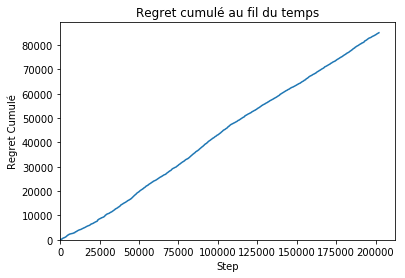

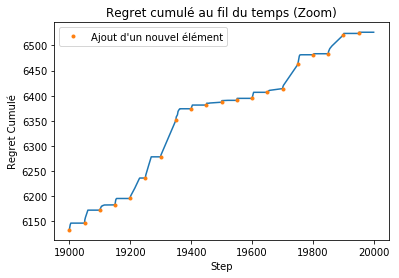

In [17]:
plt.plot(regret)
plt.xlabel("Step")
plt.ylabel("Regret Cumulé")
plt.title("Regret cumulé au fil du temps")
plt.xlim(0)
plt.ylim(0)
plt.show()
plt.plot([19000+i for i in range(1000)],regret[19000:20000])
plt.plot([19000+i*50 for i in range(20)],regret[19000:20000:50],'o',markersize=3,label="Ajout d'un nouvel élément")
plt.xlabel("Step")
plt.ylabel("Regret Cumulé")
plt.title("Regret cumulé au fil du temps (Zoom)")
plt.legend()
plt.show()

Une mesure intéressante pour voir si nos features apprises ressemblent bien aux features que l'on voulait apprendre est l'**accuracy** : On regarde si le film préféré de chaque utilisateur prédit est bien le bon (pour cela, on compare les features entre eux). Une variante de cette mesure est la **k-accuracy** : On regarde si le film préféré selon les features à apprendre est dans le top k des films préférés selon les features apprises.

In [18]:
def compute_score(features_users,features_movies,Ulearn,Vlearn,k):

    score = [0]
    for j in range(len(features_users)):
        add = 0
        if np.argmax([Ulearn[j].dot(Vlearn[i]) for i in range(207)]) == np.argmax([features_users[j].dot(features_movies[i]) for i in range(207)]):
            add = 1
        score.append(score[-1] + add)

    score5 = [0]
    for j in range(len(features_users)):
        add = 0
        if np.argmax([features_users[j].dot(features_movies[i]) for i in range(207)]) in np.argsort([Ulearn[j].dot(Vlearn[i]) for i in range(207)])[-1:-1-k:-1]:
            add = 1
        score5.append(score5[-1] + add)

    score = [si/len(features_users) for si in score]
    score5 = [si/len(features_users) for si in score5]

    return score,score5

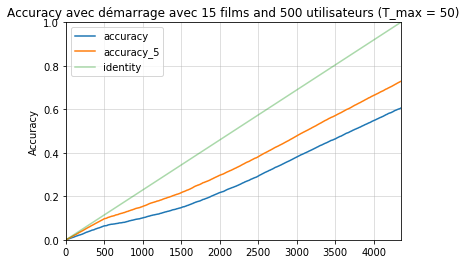

In [19]:
score,score5 = compute_score(features_users,features_movies,Ulearn,Vlearn,5)
plt.plot(score,label="accuracy")
plt.plot(score5,label="accuracy_5")
plt.plot([i/len(features_users) for i in range(len(features_users))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy avec démarrage avec 15 films and 500 utilisateurs (T_max = 50)")
plt.show()

In [20]:
print("Accuracy :",round(score[-1],4)*100, "%")
print("Top-5 Accuracy :",round(score5[-1],4)*100, "%")

Accuracy : 60.56 %
Top-5 Accuracy : 72.86 %


Avec 50 étapes (T_max = 50), les features ont été un peu apprises, mais pas totalement. On observe également que l'accuracy est moins bonne pour les utilisateurs arrivés arrivés en premier (juste après $n_0 = 500$), car il n'y avait pas assez de films pour les entrainer. Pour les films déjà présent au démarrage ($n \le n_0 = 500$), on observe sans surprise que l'accuracy est plutot bonne.
Ici, l'accuracy n'est pas très convaincante. Regardons ce que l'on obtient si on met plus de films et d'utilisateurs au démarrage.

In [21]:
 
Ulearn,Vlearn,regret = LinUCB(features_movies,features_users,new_elems=7000,verbose=True,T_max=50,start=(100,2000),nb_sugg=5,big_step=2,proba=1/10)

INIT...
0 . ADDING USER  2001
1 . ADDING USER  2002
2 . ADDING USER  2003
3 . ADDING USER  2004
4 . ADDING USER  2005
5 . ADDING USER  2006
6 . ADDING USER  2007
7 . ADDING MOVIE  101
8 . ADDING USER  2008
9 . ADDING USER  2009
10 . ADDING USER  2010
11 . ADDING USER  2011
12 . ADDING USER  2012
13 . ADDING USER  2013
14 . ADDING USER  2014
15 . ADDING USER  2015
16 . ADDING USER  2016
17 . ADDING USER  2017
18 . ADDING USER  2018
19 . ADDING USER  2019
20 . ADDING USER  2020
21 . ADDING USER  2021
22 . ADDING USER  2022
23 . ADDING USER  2023
24 . ADDING USER  2024
25 . ADDING USER  2025
26 . ADDING USER  2026
27 . ADDING USER  2027
28 . ADDING USER  2028
29 . ADDING USER  2029
30 . ADDING USER  2030
31 . ADDING USER  2031
32 . ADDING MOVIE  102
33 . ADDING USER  2032
34 . ADDING USER  2033
35 . ADDING USER  2034
36 . ADDING USER  2035
37 . ADDING USER  2036
38 . ADDING USER  2037
39 . ADDING USER  2038
40 . ADDING USER  2039
41 . ADDING MOVIE  103
42 . ADDING USER  2040
43 . ADDING U

350 . ADDING USER  2315
351 . ADDING USER  2316
352 . ADDING USER  2317
353 . ADDING USER  2318
354 . ADDING USER  2319
355 . ADDING USER  2320
356 . ADDING USER  2321
357 . ADDING USER  2322
358 . ADDING USER  2323
359 . ADDING USER  2324
360 . ADDING MOVIE  137
361 . ADDING USER  2325
362 . ADDING USER  2326
363 . ADDING USER  2327
364 . ADDING USER  2328
365 . ADDING USER  2329
366 . ADDING USER  2330
367 . ADDING USER  2331
368 . ADDING USER  2332
369 . ADDING MOVIE  138
370 . ADDING MOVIE  139
371 . ADDING USER  2333
372 . ADDING USER  2334
373 . ADDING USER  2335
374 . ADDING USER  2336
375 . ADDING USER  2337
376 . ADDING USER  2338
377 . ADDING USER  2339
378 . ADDING USER  2340
379 . ADDING USER  2341
380 . ADDING USER  2342
381 . ADDING USER  2343
382 . ADDING USER  2344
383 . ADDING USER  2345
384 . ADDING MOVIE  140
385 . ADDING USER  2346
386 . ADDING USER  2347
387 . ADDING USER  2348
388 . ADDING USER  2349
389 . ADDING USER  2350
390 . ADDING USER  2351
391 . ADDING USE

695 . ADDING USER  2624
696 . ADDING USER  2625
697 . ADDING USER  2626
698 . ADDING USER  2627
699 . ADDING USER  2628
700 . ADDING USER  2629
701 . ADDING USER  2630
702 . ADDING USER  2631
703 . ADDING MOVIE  173
704 . ADDING MOVIE  174
705 . ADDING USER  2632
706 . ADDING USER  2633
707 . ADDING USER  2634
708 . ADDING USER  2635
709 . ADDING USER  2636
710 . ADDING USER  2637
711 . ADDING USER  2638
712 . ADDING USER  2639
713 . ADDING USER  2640
714 . ADDING USER  2641
715 . ADDING USER  2642
716 . ADDING USER  2643
717 . ADDING USER  2644
718 . ADDING USER  2645
719 . ADDING MOVIE  175
720 . ADDING USER  2646
721 . ADDING USER  2647
722 . ADDING USER  2648
723 . ADDING USER  2649
724 . ADDING USER  2650
725 . ADDING USER  2651
726 . ADDING USER  2652
727 . ADDING USER  2653
728 . ADDING USER  2654
729 . ADDING USER  2655
730 . ADDING MOVIE  176
731 . ADDING USER  2656
732 . ADDING USER  2657
733 . ADDING USER  2658
734 . ADDING USER  2659
735 . ADDING USER  2660
736 . ADDING USE

1037 . ADDING USER  2937
1038 . ADDING USER  2938
1039 . ADDING USER  2939
1040 . ADDING USER  2940
1041 . ADDING USER  2941
1042 . ADDING MOVIE  202
1043 . ADDING USER  2942
1044 . ADDING USER  2943
1045 . ADDING MOVIE  203
1046 . ADDING USER  2944
1047 . ADDING USER  2945
1048 . ADDING USER  2946
1049 . ADDING USER  2947
1050 . ADDING USER  2948
1051 . ADDING USER  2949
1052 . ADDING USER  2950
1053 . ADDING USER  2951
1054 . ADDING USER  2952
1055 . ADDING USER  2953
1056 . ADDING USER  2954
1057 . ADDING USER  2955
1058 . ADDING USER  2956
1059 . ADDING USER  2957
1060 . ADDING USER  2958
1061 . ADDING USER  2959
1062 . ADDING USER  2960
1063 . ADDING USER  2961
1064 . ADDING USER  2962
1065 . ADDING USER  2963
1066 . ADDING USER  2964
1067 . ADDING USER  2965
1068 . ADDING USER  2966
1069 . ADDING USER  2967
1070 . ADDING USER  2968
1071 . ADDING USER  2969
1072 . ADDING USER  2970
1073 . ADDING USER  2971
1074 . ADDING USER  2972
1075 . ADDING USER  2973
1076 . ADDING MOVIE  204


1367 . ADDING USER  3261
1368 . ADDING USER  3262
1369 . ADDING USER  3263
1370 . ADDING USER  3264
1371 . ADDING USER  3265
1372 . ADDING USER  3266
1373 . ADDING USER  3267
1374 . ADDING USER  3268
1375 . ADDING USER  3269
1376 . ADDING USER  3270
1377 . ADDING USER  3271
1378 . ADDING USER  3272
1379 . ADDING USER  3273
1380 . ADDING USER  3274
1381 . ADDING USER  3275
1382 . ADDING USER  3276
1383 . ADDING USER  3277
1384 . ADDING USER  3278
1385 . ADDING USER  3279
1386 . ADDING USER  3280
1387 . ADDING USER  3281
1388 . ADDING USER  3282
1389 . ADDING USER  3283
1390 . ADDING USER  3284
1391 . ADDING USER  3285
1392 . ADDING USER  3286
1393 . ADDING USER  3287
1394 . ADDING USER  3288
1395 . ADDING USER  3289
1396 . ADDING USER  3290
1397 . ADDING USER  3291
1398 . ADDING USER  3292
1399 . ADDING USER  3293
1400 . ADDING USER  3294
1401 . ADDING USER  3295
1402 . ADDING USER  3296
1403 . ADDING USER  3297
1404 . ADDING USER  3298
1405 . ADDING USER  3299
1406 . ADDING USER  3300


1697 . ADDING USER  3591
1698 . ADDING USER  3592
1699 . ADDING USER  3593
1700 . ADDING USER  3594
1701 . ADDING USER  3595
1702 . ADDING USER  3596
1703 . ADDING USER  3597
1704 . ADDING USER  3598
1705 . ADDING USER  3599
1706 . ADDING USER  3600
1707 . ADDING USER  3601
1708 . ADDING USER  3602
1709 . ADDING USER  3603
1710 . ADDING USER  3604
1711 . ADDING USER  3605
1712 . ADDING USER  3606
1713 . ADDING USER  3607
1714 . ADDING USER  3608
1715 . ADDING USER  3609
1716 . ADDING USER  3610
1717 . ADDING USER  3611
1718 . ADDING USER  3612
1719 . ADDING USER  3613
1720 . ADDING USER  3614
1721 . ADDING USER  3615
1722 . ADDING USER  3616
1723 . ADDING USER  3617
1724 . ADDING USER  3618
1725 . ADDING USER  3619
1726 . ADDING USER  3620
1727 . ADDING USER  3621
1728 . ADDING USER  3622
1729 . ADDING USER  3623
1730 . ADDING USER  3624
1731 . ADDING USER  3625
1732 . ADDING USER  3626
1733 . ADDING USER  3627
1734 . ADDING USER  3628
1735 . ADDING USER  3629
1736 . ADDING USER  3630


2025 . ADDING USER  3919
2026 . ADDING USER  3920
2027 . ADDING USER  3921
2028 . ADDING USER  3922
2029 . ADDING USER  3923
2030 . ADDING USER  3924
2031 . ADDING USER  3925
2032 . ADDING USER  3926
2033 . ADDING USER  3927
2034 . ADDING USER  3928
2035 . ADDING USER  3929
2036 . ADDING USER  3930
2037 . ADDING USER  3931
2038 . ADDING USER  3932
2039 . ADDING USER  3933
2040 . ADDING USER  3934
2041 . ADDING USER  3935
2042 . ADDING USER  3936
2043 . ADDING USER  3937
2044 . ADDING USER  3938
2045 . ADDING USER  3939
2046 . ADDING USER  3940
2047 . ADDING USER  3941
2048 . ADDING USER  3942
2049 . ADDING USER  3943
2050 . ADDING USER  3944
2051 . ADDING USER  3945
2052 . ADDING USER  3946
2053 . ADDING USER  3947
2054 . ADDING USER  3948
2055 . ADDING USER  3949
2056 . ADDING USER  3950
2057 . ADDING USER  3951
2058 . ADDING USER  3952
2059 . ADDING USER  3953
2060 . ADDING USER  3954
2061 . ADDING USER  3955
2062 . ADDING USER  3956
2063 . ADDING USER  3957
2064 . ADDING USER  3958


2355 . ADDING USER  4249
2356 . ADDING USER  4250
2357 . ADDING USER  4251
2358 . ADDING USER  4252
2359 . ADDING USER  4253
2360 . ADDING USER  4254
2361 . ADDING USER  4255
2362 . ADDING USER  4256
2363 . ADDING USER  4257
2364 . ADDING USER  4258
2365 . ADDING USER  4259
2366 . ADDING USER  4260
2367 . ADDING USER  4261
2368 . ADDING USER  4262
2369 . ADDING USER  4263
2370 . ADDING USER  4264
2371 . ADDING USER  4265
2372 . ADDING USER  4266
2373 . ADDING USER  4267
2374 . ADDING USER  4268
2375 . ADDING USER  4269
2376 . ADDING USER  4270
2377 . ADDING USER  4271
2378 . ADDING USER  4272
2379 . ADDING USER  4273
2380 . ADDING USER  4274
2381 . ADDING USER  4275
2382 . ADDING USER  4276
2383 . ADDING USER  4277
2384 . ADDING USER  4278
2385 . ADDING USER  4279
2386 . ADDING USER  4280
2387 . ADDING USER  4281
2388 . ADDING USER  4282
2389 . ADDING USER  4283
2390 . ADDING USER  4284
2391 . ADDING USER  4285
2392 . ADDING USER  4286
2393 . ADDING USER  4287
2394 . ADDING USER  4288


Accuracy : 0.79
Top-5 Accuracy : 0.89


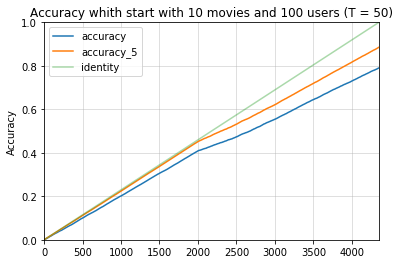

In [22]:
score,score5 = compute_score(features_users,features_movies,Ulearn,Vlearn,5)
plt.plot(score,label="accuracy")
plt.plot(score5,label="accuracy_5")
plt.plot([i/len(features_users) for i in range(len(features_users))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy whith start with 10 movies and 100 users (T = 50)")
print("Accuracy :",round(score[-1],2))
print("Top-5 Accuracy :",round(score5[-1],2))
plt.show()

On obtient une bien meilleure accuracy. On peut également à présent très bien distinguer la limite entre les utilisateurs déjà présents et les nouveaux utilisateurs.

# C. Apprendre avec les ratings

Nous nous sommes ensuite demandés ce qu'il se passerait si au lieu de récuperer les rewards à partir des features calculées grâce à la méthode SVD, nous ne "proposions" que les films que l'utilisateur a réellement vu depuis la matrice de ratings. Nous calculons alors les rewards grâce à ces ratings plutôt que selon les matrices de features U (utilisateurs) et V (films).

Le code ci-dessous permet de récuperer la liste des utilisateurs qui ont vu un film $M_i$ ainsi que la liste des films vu par un utilisateur $U_i$

In [23]:
def what_is_seen(M):
    users_seen = [[] for i in range(n)]
    movies_seen = [[] for i in range(m)]
    for i in range(len(M)):
        for j in range(len(M[i])):
            if M[i][j] > 0: #Si la note est positif, l'utilisateur i a vu et a noté le film j.
                users_seen[i].append(j)
                movies_seen[j].append(i)
    return users_seen,movies_seen

users_seen,movies_seen = what_is_seen(M)

L'implémentation ci-dessous est une réecriture de l'algo LinUCB avec les rewards selon la matrice de ratings plutot que selon les features à apprende.

In [24]:
def MLinUCB_select_movie(est_features_user,est_features_movies,user_ind,user_seen,ratings,sigma,alpha,N,nb_sugg):
    prod_scal = [est_features_user.dot(est_features_movies[user_seen[i]])+alpha/np.sqrt(N[i]+1) for i in range(len(user_seen))]
    arg_movies = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    chosen_movies = [user_seen[movie_i] for movie_i in arg_movies]
    rewards = [ratings[user_ind,chosen_movie] + np.random.normal(0,sigma) for chosen_movie in chosen_movies]
    return chosen_movies, rewards

## Même chose que ci-dessus mais film et utilisateur interchangés
def MLinUCB_select_user(est_features_movie,est_features_users,movie_ind,movie_seen,ratings,sigma,alpha,N,nb_sugg):
    prod_scal = [est_features_users[movie_seen[i]].dot(est_features_movie)+alpha/np.sqrt(N[i]+1) for i in range(len(movie_seen))]
    arg_users = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    chosen_users = [movie_seen[user_i] for user_i in arg_users]
    rewards = [ratings[chosen_user,movie_ind] + np.random.normal(0,sigma) for chosen_user in chosen_users]
    return chosen_users, rewards

In [25]:
##Initialisation
def MLinUCB_init(m,d,lambd,fseen,maxf):
    V = lambd*np.identity(d)
    theta = np.zeros(d)
    D = np.zeros(d)
    out_seen = []
    for i in range(len(fseen)):
        if fseen[i] < maxf:
            out_seen.append(fseen[i])
        else:
            break
    N = np.zeros(len(out_seen))
    return V,D,theta,N,out_seen

def MLinUCB(features_movies,features_users,ratings,users_seen,movies_seen,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,start=(150,4000),nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("INIT...")
    (n,d) = features_users.shape
    (m,_) = features_movies.shape
    (nb_movies,nb_users) = start
    features_users_l = features_users[:nb_users]
    features_movies_l = features_movies[:nb_movies]
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            if verbose:
                print(elemi,". ADDING USER ",nb_users)
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,users_seen[nb_users-1],nb_movies)
            print("Have seen ",len(seen))
        else:
            if verbose:
                print(elemi,". ADDING MOVIE ",nb_movies)
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,movies_seen[nb_movies-1],nb_users)
            print("Seen by ",len(seen))
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards = MLinUCB_select_movie(theta,features_movies_l,nb_users-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[seen.index(chosen_movies[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards = MLinUCB_select_user(theta,features_users_l,nb_movies-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[seen.index(chosen_users[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
    return features_users_l,features_movies_l

In [26]:

UlearnM,VlearnM = MLinUCB(features_movies,features_users,M,users_seen,movies_seen,new_elems=7000,verbose=True,T_max=100,start=(100,1000),nb_sugg=1,big_step=2,proba=1/20)

INIT...
0 . ADDING USER  1001
Have seen  17
1 . ADDING USER  1002
Have seen  15
2 . ADDING USER  1003
Have seen  19
3 . ADDING USER  1004
Have seen  35
4 . ADDING USER  1005
Have seen  18
5 . ADDING USER  1006
Have seen  26
6 . ADDING USER  1007
Have seen  18
7 . ADDING USER  1008
Have seen  23
8 . ADDING USER  1009
Have seen  3
9 . ADDING USER  1010
Have seen  45
10 . ADDING USER  1011
Have seen  16
11 . ADDING USER  1012
Have seen  50
12 . ADDING USER  1013
Have seen  37
13 . ADDING USER  1014
Have seen  58
14 . ADDING USER  1015
Have seen  33
15 . ADDING USER  1016
Have seen  85
16 . ADDING USER  1017
Have seen  11
17 . ADDING USER  1018
Have seen  57
18 . ADDING USER  1019
Have seen  74
19 . ADDING USER  1020
Have seen  32
20 . ADDING USER  1021
Have seen  30
21 . ADDING USER  1022
Have seen  7
22 . ADDING USER  1023
Have seen  13
23 . ADDING USER  1024
Have seen  27
24 . ADDING USER  1025
Have seen  2
25 . ADDING USER  1026
Have seen  37
26 . ADDING USER  1027
Have seen  38
27 . A

228 . ADDING USER  1221
Have seen  73
229 . ADDING USER  1222
Have seen  10
230 . ADDING USER  1223
Have seen  21
231 . ADDING USER  1224
Have seen  63
232 . ADDING USER  1225
Have seen  7
233 . ADDING USER  1226
Have seen  12
234 . ADDING USER  1227
Have seen  19
235 . ADDING USER  1228
Have seen  75
236 . ADDING USER  1229
Have seen  14
237 . ADDING USER  1230
Have seen  21
238 . ADDING USER  1231
Have seen  40
239 . ADDING MOVIE  109
Seen by  392
240 . ADDING MOVIE  110
Seen by  398
241 . ADDING USER  1232
Have seen  10
242 . ADDING USER  1233
Have seen  45
243 . ADDING USER  1234
Have seen  17
244 . ADDING MOVIE  111
Seen by  410
245 . ADDING USER  1235
Have seen  81
246 . ADDING USER  1236
Have seen  69
247 . ADDING USER  1237
Have seen  5
248 . ADDING USER  1238
Have seen  87
249 . ADDING USER  1239
Have seen  50
250 . ADDING USER  1240
Have seen  41
251 . ADDING MOVIE  112
Seen by  715
252 . ADDING USER  1241
Have seen  4
253 . ADDING USER  1242
Have seen  60
254 . ADDING USER  

445 . ADDING USER  1421
Have seen  39
446 . ADDING USER  1422
Have seen  67
447 . ADDING USER  1423
Have seen  96
448 . ADDING MOVIE  126
Seen by  468
449 . ADDING USER  1424
Have seen  23
450 . ADDING USER  1425
Have seen  72
451 . ADDING USER  1426
Have seen  75
452 . ADDING USER  1427
Have seen  26
453 . ADDING USER  1428
Have seen  43
454 . ADDING USER  1429
Have seen  30
455 . ADDING USER  1430
Have seen  34
456 . ADDING USER  1431
Have seen  33
457 . ADDING USER  1432
Have seen  89
458 . ADDING MOVIE  127
Seen by  374
459 . ADDING USER  1433
Have seen  27
460 . ADDING USER  1434
Have seen  12
461 . ADDING USER  1435
Have seen  47
462 . ADDING USER  1436
Have seen  16
463 . ADDING USER  1437
Have seen  80
464 . ADDING USER  1438
Have seen  42
465 . ADDING USER  1439
Have seen  8
466 . ADDING USER  1440
Have seen  106
467 . ADDING USER  1441
Have seen  61
468 . ADDING USER  1442
Have seen  1
469 . ADDING USER  1443
Have seen  25
470 . ADDING USER  1444
Have seen  57
471 . ADDING US

667 . ADDING USER  1630
Have seen  15
668 . ADDING USER  1631
Have seen  45
669 . ADDING USER  1632
Have seen  5
670 . ADDING USER  1633
Have seen  18
671 . ADDING USER  1634
Have seen  44
672 . ADDING USER  1635
Have seen  18
673 . ADDING USER  1636
Have seen  64
674 . ADDING USER  1637
Have seen  30
675 . ADDING USER  1638
Have seen  24
676 . ADDING USER  1639
Have seen  42
677 . ADDING USER  1640
Have seen  18
678 . ADDING USER  1641
Have seen  22
679 . ADDING USER  1642
Have seen  57
680 . ADDING USER  1643
Have seen  28
681 . ADDING USER  1644
Have seen  30
682 . ADDING USER  1645
Have seen  62
683 . ADDING USER  1646
Have seen  76
684 . ADDING USER  1647
Have seen  13
685 . ADDING USER  1648
Have seen  37
686 . ADDING USER  1649
Have seen  47
687 . ADDING USER  1650
Have seen  25
688 . ADDING USER  1651
Have seen  19
689 . ADDING USER  1652
Have seen  46
690 . ADDING USER  1653
Have seen  39
691 . ADDING USER  1654
Have seen  42
692 . ADDING USER  1655
Have seen  42
693 . ADDING 

886 . ADDING USER  1837
Have seen  20
887 . ADDING USER  1838
Have seen  11
888 . ADDING USER  1839
Have seen  110
889 . ADDING USER  1840
Have seen  16
890 . ADDING USER  1841
Have seen  98
891 . ADDING USER  1842
Have seen  27
892 . ADDING USER  1843
Have seen  86
893 . ADDING USER  1844
Have seen  76
894 . ADDING USER  1845
Have seen  18
895 . ADDING USER  1846
Have seen  34
896 . ADDING USER  1847
Have seen  39
897 . ADDING USER  1848
Have seen  19
898 . ADDING USER  1849
Have seen  38
899 . ADDING USER  1850
Have seen  14
900 . ADDING USER  1851
Have seen  26
901 . ADDING MOVIE  151
Seen by  535
902 . ADDING USER  1852
Have seen  6
903 . ADDING USER  1853
Have seen  35
904 . ADDING USER  1854
Have seen  17
905 . ADDING USER  1855
Have seen  59
906 . ADDING USER  1856
Have seen  22
907 . ADDING USER  1857
Have seen  40
908 . ADDING USER  1858
Have seen  90
909 . ADDING USER  1859
Have seen  135
910 . ADDING USER  1860
Have seen  31
911 . ADDING MOVIE  152
Seen by  403
912 . ADDING 

Have seen  27
1104 . ADDING USER  2046
Have seen  81
1105 . ADDING USER  2047
Have seen  63
1106 . ADDING USER  2048
Have seen  39
1107 . ADDING USER  2049
Have seen  26
1108 . ADDING USER  2050
Have seen  13
1109 . ADDING USER  2051
Have seen  61
1110 . ADDING USER  2052
Have seen  29
1111 . ADDING USER  2053
Have seen  101
1112 . ADDING USER  2054
Have seen  106
1113 . ADDING USER  2055
Have seen  65
1114 . ADDING USER  2056
Have seen  53
1115 . ADDING USER  2057
Have seen  97
1116 . ADDING USER  2058
Have seen  41
1117 . ADDING USER  2059
Have seen  45
1118 . ADDING USER  2060
Have seen  72
1119 . ADDING USER  2061
Have seen  55
1120 . ADDING USER  2062
Have seen  82
1121 . ADDING USER  2063
Have seen  29
1122 . ADDING USER  2064
Have seen  38
1123 . ADDING USER  2065
Have seen  47
1124 . ADDING USER  2066
Have seen  21
1125 . ADDING USER  2067
Have seen  94
1126 . ADDING USER  2068
Have seen  39
1127 . ADDING USER  2069
Have seen  6
1128 . ADDING USER  2070
Have seen  26
1129 . ADD

1318 . ADDING USER  2248
Have seen  120
1319 . ADDING USER  2249
Have seen  46
1320 . ADDING USER  2250
Have seen  29
1321 . ADDING USER  2251
Have seen  39
1322 . ADDING USER  2252
Have seen  108
1323 . ADDING USER  2253
Have seen  17
1324 . ADDING USER  2254
Have seen  68
1325 . ADDING USER  2255
Have seen  72
1326 . ADDING USER  2256
Have seen  43
1327 . ADDING USER  2257
Have seen  68
1328 . ADDING USER  2258
Have seen  57
1329 . ADDING USER  2259
Have seen  31
1330 . ADDING USER  2260
Have seen  20
1331 . ADDING USER  2261
Have seen  41
1332 . ADDING USER  2262
Have seen  43
1333 . ADDING USER  2263
Have seen  76
1334 . ADDING USER  2264
Have seen  45
1335 . ADDING USER  2265
Have seen  46
1336 . ADDING USER  2266
Have seen  20
1337 . ADDING MOVIE  172
Seen by  664
1338 . ADDING MOVIE  173
Seen by  1513
1339 . ADDING USER  2267
Have seen  99
1340 . ADDING USER  2268
Have seen  21
1341 . ADDING USER  2269
Have seen  38
1342 . ADDING USER  2270
Have seen  104
1343 . ADDING USER  227

1533 . ADDING USER  2452
Have seen  90
1534 . ADDING USER  2453
Have seen  25
1535 . ADDING USER  2454
Have seen  26
1536 . ADDING USER  2455
Have seen  21
1537 . ADDING USER  2456
Have seen  136
1538 . ADDING USER  2457
Have seen  29
1539 . ADDING USER  2458
Have seen  153
1540 . ADDING USER  2459
Have seen  29
1541 . ADDING USER  2460
Have seen  44
1542 . ADDING USER  2461
Have seen  63
1543 . ADDING USER  2462
Have seen  152
1544 . ADDING USER  2463
Have seen  98
1545 . ADDING USER  2464
Have seen  24
1546 . ADDING USER  2465
Have seen  44
1547 . ADDING USER  2466
Have seen  20
1548 . ADDING USER  2467
Have seen  66
1549 . ADDING USER  2468
Have seen  40
1550 . ADDING USER  2469
Have seen  136
1551 . ADDING USER  2470
Have seen  74
1552 . ADDING USER  2471
Have seen  95
1553 . ADDING USER  2472
Have seen  49
1554 . ADDING USER  2473
Have seen  78
1555 . ADDING USER  2474
Have seen  129
1556 . ADDING USER  2475
Have seen  75
1557 . ADDING USER  2476
Have seen  18
1558 . ADDING USER  

1744 . ADDING USER  2653
Have seen  47
1745 . ADDING USER  2654
Have seen  51
1746 . ADDING USER  2655
Have seen  22
1747 . ADDING USER  2656
Have seen  142
1748 . ADDING MOVIE  193
Seen by  810
1749 . ADDING USER  2657
Have seen  118
1750 . ADDING USER  2658
Have seen  88
1751 . ADDING USER  2659
Have seen  26
1752 . ADDING USER  2660
Have seen  137
1753 . ADDING USER  2661
Have seen  36
1754 . ADDING USER  2662
Have seen  62
1755 . ADDING USER  2663
Have seen  63
1756 . ADDING USER  2664
Have seen  78
1757 . ADDING USER  2665
Have seen  41
1758 . ADDING USER  2666
Have seen  72
1759 . ADDING USER  2667
Have seen  24
1760 . ADDING USER  2668
Have seen  63
1761 . ADDING USER  2669
Have seen  53
1762 . ADDING USER  2670
Have seen  30
1763 . ADDING USER  2671
Have seen  128
1764 . ADDING USER  2672
Have seen  20
1765 . ADDING USER  2673
Have seen  45
1766 . ADDING USER  2674
Have seen  21
1767 . ADDING USER  2675
Have seen  111
1768 . ADDING USER  2676
Have seen  69
1769 . ADDING USER  2

1958 . ADDING USER  2858
Have seen  68
1959 . ADDING USER  2859
Have seen  24
1960 . ADDING USER  2860
Have seen  127
1961 . ADDING USER  2861
Have seen  121
1962 . ADDING USER  2862
Have seen  89
1963 . ADDING USER  2863
Have seen  80
1964 . ADDING USER  2864
Have seen  51
1965 . ADDING USER  2865
Have seen  77
1966 . ADDING USER  2866
Have seen  36
1967 . ADDING USER  2867
Have seen  147
1968 . ADDING USER  2868
Have seen  22
1969 . ADDING USER  2869
Have seen  61
1970 . ADDING USER  2870
Have seen  32
1971 . ADDING USER  2871
Have seen  35
1972 . ADDING USER  2872
Have seen  93
1973 . ADDING USER  2873
Have seen  90
1974 . ADDING USER  2874
Have seen  140
1975 . ADDING USER  2875
Have seen  50
1976 . ADDING USER  2876
Have seen  20
1977 . ADDING USER  2877
Have seen  22
1978 . ADDING USER  2878
Have seen  94
1979 . ADDING USER  2879
Have seen  38
1980 . ADDING USER  2880
Have seen  40
1981 . ADDING USER  2881
Have seen  137
1982 . ADDING USER  2882
Have seen  46
1983 . ADDING USER  

2169 . ADDING USER  3063
Have seen  39
2170 . ADDING USER  3064
Have seen  46
2171 . ADDING USER  3065
Have seen  20
2172 . ADDING USER  3066
Have seen  35
2173 . ADDING USER  3067
Have seen  108
2174 . ADDING USER  3068
Have seen  39
2175 . ADDING USER  3069
Have seen  79
2176 . ADDING USER  3070
Have seen  36
2177 . ADDING USER  3071
Have seen  32
2178 . ADDING USER  3072
Have seen  83
2179 . ADDING USER  3073
Have seen  39
2180 . ADDING USER  3074
Have seen  39
2181 . ADDING USER  3075
Have seen  21
2182 . ADDING USER  3076
Have seen  75
2183 . ADDING USER  3077
Have seen  39
2184 . ADDING USER  3078
Have seen  20
2185 . ADDING USER  3079
Have seen  62
2186 . ADDING USER  3080
Have seen  94
2187 . ADDING USER  3081
Have seen  140
2188 . ADDING USER  3082
Have seen  25
2189 . ADDING USER  3083
Have seen  42
2190 . ADDING USER  3084
Have seen  49
2191 . ADDING USER  3085
Have seen  97
2192 . ADDING USER  3086
Have seen  30
2193 . ADDING USER  3087
Have seen  176
2194 . ADDING USER  30

2381 . ADDING USER  3275
Have seen  27
2382 . ADDING USER  3276
Have seen  91
2383 . ADDING USER  3277
Have seen  27
2384 . ADDING USER  3278
Have seen  27
2385 . ADDING USER  3279
Have seen  45
2386 . ADDING USER  3280
Have seen  24
2387 . ADDING USER  3281
Have seen  141
2388 . ADDING USER  3282
Have seen  89
2389 . ADDING USER  3283
Have seen  63
2390 . ADDING USER  3284
Have seen  46
2391 . ADDING USER  3285
Have seen  55
2392 . ADDING USER  3286
Have seen  35
2393 . ADDING USER  3287
Have seen  26
2394 . ADDING USER  3288
Have seen  86
2395 . ADDING USER  3289
Have seen  55
2396 . ADDING USER  3290
Have seen  29
2397 . ADDING USER  3291
Have seen  22
2398 . ADDING USER  3292
Have seen  46
2399 . ADDING USER  3293
Have seen  35
2400 . ADDING USER  3294
Have seen  27
2401 . ADDING USER  3295
Have seen  144
2402 . ADDING USER  3296
Have seen  27
2403 . ADDING USER  3297
Have seen  59
2404 . ADDING USER  3298
Have seen  57
2405 . ADDING USER  3299
Have seen  110
2406 . ADDING USER  33

2595 . ADDING USER  3489
Have seen  167
2596 . ADDING USER  3490
Have seen  74
2597 . ADDING USER  3491
Have seen  89
2598 . ADDING USER  3492
Have seen  39
2599 . ADDING USER  3493
Have seen  30
2600 . ADDING USER  3494
Have seen  21
2601 . ADDING USER  3495
Have seen  38
2602 . ADDING USER  3496
Have seen  137
2603 . ADDING USER  3497
Have seen  61
2604 . ADDING USER  3498
Have seen  161
2605 . ADDING USER  3499
Have seen  45
2606 . ADDING USER  3500
Have seen  115
2607 . ADDING USER  3501
Have seen  64
2608 . ADDING USER  3502
Have seen  135
2609 . ADDING USER  3503
Have seen  55
2610 . ADDING USER  3504
Have seen  48
2611 . ADDING USER  3505
Have seen  40
2612 . ADDING USER  3506
Have seen  24
2613 . ADDING USER  3507
Have seen  26
2614 . ADDING USER  3508
Have seen  117
2615 . ADDING USER  3509
Have seen  75
2616 . ADDING USER  3510
Have seen  95
2617 . ADDING USER  3511
Have seen  89
2618 . ADDING USER  3512
Have seen  52
2619 . ADDING USER  3513
Have seen  26
2620 . ADDING USER 

2809 . ADDING USER  3703
Have seen  74
2810 . ADDING USER  3704
Have seen  62
2811 . ADDING USER  3705
Have seen  35
2812 . ADDING USER  3706
Have seen  129
2813 . ADDING USER  3707
Have seen  50
2814 . ADDING USER  3708
Have seen  43
2815 . ADDING USER  3709
Have seen  66
2816 . ADDING USER  3710
Have seen  45
2817 . ADDING USER  3711
Have seen  26
2818 . ADDING USER  3712
Have seen  69
2819 . ADDING USER  3713
Have seen  42
2820 . ADDING USER  3714
Have seen  63
2821 . ADDING USER  3715
Have seen  57
2822 . ADDING USER  3716
Have seen  37
2823 . ADDING USER  3717
Have seen  68
2824 . ADDING USER  3718
Have seen  32
2825 . ADDING USER  3719
Have seen  28
2826 . ADDING USER  3720
Have seen  20
2827 . ADDING USER  3721
Have seen  91
2828 . ADDING USER  3722
Have seen  40
2829 . ADDING USER  3723
Have seen  26
2830 . ADDING USER  3724
Have seen  79
2831 . ADDING USER  3725
Have seen  22
2832 . ADDING USER  3726
Have seen  30
2833 . ADDING USER  3727
Have seen  42
2834 . ADDING USER  3728

Have seen  33
3019 . ADDING USER  3913
Have seen  49
3020 . ADDING USER  3914
Have seen  55
3021 . ADDING USER  3915
Have seen  39
3022 . ADDING USER  3916
Have seen  83
3023 . ADDING USER  3917
Have seen  100
3024 . ADDING USER  3918
Have seen  47
3025 . ADDING USER  3919
Have seen  37
3026 . ADDING USER  3920
Have seen  103
3027 . ADDING USER  3921
Have seen  69
3028 . ADDING USER  3922
Have seen  33
3029 . ADDING USER  3923
Have seen  132
3030 . ADDING USER  3924
Have seen  20
3031 . ADDING USER  3925
Have seen  23
3032 . ADDING USER  3926
Have seen  45
3033 . ADDING USER  3927
Have seen  52
3034 . ADDING USER  3928
Have seen  136
3035 . ADDING USER  3929
Have seen  51
3036 . ADDING USER  3930
Have seen  50
3037 . ADDING USER  3931
Have seen  60
3038 . ADDING USER  3932
Have seen  25
3039 . ADDING USER  3933
Have seen  97
3040 . ADDING USER  3934
Have seen  43
3041 . ADDING USER  3935
Have seen  53
3042 . ADDING USER  3936
Have seen  90
3043 . ADDING USER  3937
Have seen  69
3044 . 

3229 . ADDING USER  4123
Have seen  86
3230 . ADDING USER  4124
Have seen  48
3231 . ADDING USER  4125
Have seen  32
3232 . ADDING USER  4126
Have seen  139
3233 . ADDING USER  4127
Have seen  29
3234 . ADDING USER  4128
Have seen  40
3235 . ADDING USER  4129
Have seen  98
3236 . ADDING USER  4130
Have seen  45
3237 . ADDING USER  4131
Have seen  54
3238 . ADDING USER  4132
Have seen  138
3239 . ADDING USER  4133
Have seen  28
3240 . ADDING USER  4134
Have seen  84
3241 . ADDING USER  4135
Have seen  50
3242 . ADDING USER  4136
Have seen  42
3243 . ADDING USER  4137
Have seen  41
3244 . ADDING USER  4138
Have seen  109
3245 . ADDING USER  4139
Have seen  99
3246 . ADDING USER  4140
Have seen  62
3247 . ADDING USER  4141
Have seen  67
3248 . ADDING USER  4142
Have seen  142
3249 . ADDING USER  4143
Have seen  43
3250 . ADDING USER  4144
Have seen  84
3251 . ADDING USER  4145
Have seen  154
3252 . ADDING USER  4146
Have seen  21
3253 . ADDING USER  4147
Have seen  98
3254 . ADDING USER  

3439 . ADDING USER  4333
Have seen  68
3440 . ADDING USER  4334
Have seen  31
3441 . ADDING USER  4335
Have seen  82
3442 . ADDING USER  4336
Have seen  35
3443 . ADDING USER  4337
Have seen  46
3444 . ADDING USER  4338
Have seen  52
3445 . ADDING USER  4339
Have seen  48
3446 . ADDING USER  4340
Have seen  44
3447 . ADDING USER  4341
Have seen  21
3448 . ADDING USER  4342
Have seen  23
3449 . ADDING USER  4343
Have seen  46
3450 . ADDING USER  4344
Have seen  28
3451 . ADDING USER  4345
Have seen  34
3452 . ADDING USER  4346
Have seen  35
3453 . ADDING USER  4347
Have seen  69
3454 . ADDING USER  4348
Have seen  154
3455 . ADDING USER  4349
Have seen  74
3456 . ADDING USER  4350
Have seen  31
3457 . ADDING USER  4351
Have seen  101


In [27]:
def compute_score_M(matrix,users_seen,Ulearn,Vlearn,k):

    score = [0]
    for j in range(len(features_users)):
        add = 0
        if M[j,int(np.argmax([Ulearn[j].dot(Vlearn[users_seen[j][i]]) for i in range(len(users_seen[j]))]))] == max(M[j]):
            add = 1
        score.append(score[-1] + add)


    score = [si/len(features_users) for si in score]

    return score

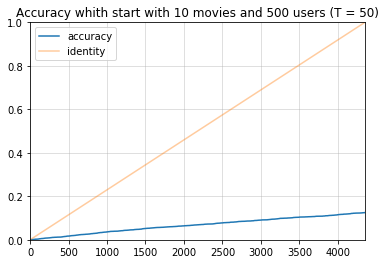

Accuracy : 12.5029 %


In [28]:
score = compute_score_M(M,users_seen,UlearnM,VlearnM,5)
plt.plot(score,label="accuracy")
plt.plot([i/len(features_users) for i in range(len(features_users))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.title("Accuracy whith start with 10 movies and 500 users (T = 50)")
plt.show()
print("Accuracy :",round(score[-1]*100,4), "%")

Il semblerait que ce 2nd algorithme n'apprend pas du tout les fatures des utilisateurs et leur film préféré. En réalité, cela est aussi dû au fait que les ratings dans la matrices sont très proches : un utilisateur aura surement noté + de 5 films avec la note "5 étoiles" et il sera alors difficile de dire lequel il préfere réellement. De plus, il y a très peu de ratings pour un apprentissage efficace.

Cependant, rien n'est perdu, cet algorithme nous sera malgrès tout utile dans la suite.

# D. Apprendre sans connaître

Dans les expériences précédentes, les features des utilisateurs et films présents au départ correspondaient aux features si on avait fait un SVD sur la matrice de ratings entière. 

Or, dans notre étude, on a supposé que certains utilisateurs / films ne sont pas encore connus du site et sont ajoutés successivement. Que se passe t-il alors si on commence par faire un SVD seulement sur une sous-matrice et que l'apprentissage ne débutent qu'à partir des features issus **uniquement de cette dernière** ? 

Partons, par exemple, avec 2000 utilisateurs et 100 films

In [29]:
subM = M[:2000,:100] #On découpe une partie de la matrice de ratings M
subU, subs, subVt = svds(subM, k = K) #On applique la méthode SVD pour de factorisation de matrice
subs = np.diag(subs)
subU = np.dot(subU,subs)
sub_features_users = subU
sub_features_movies = subVt.T

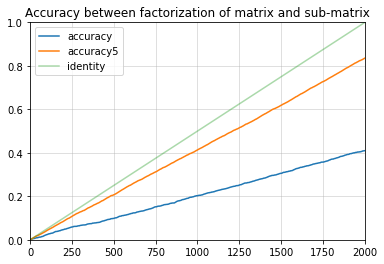

Accuracy : 41.0 %
Accuracy-5 : 83.55 %


In [30]:
score = [0]
for j in range(len(sub_features_users)):
    add = 0
    if np.argmax([sub_features_users[j].dot(sub_features_movies[i]) for i in range(100)]) == np.argmax([features_users[j].dot(features_movies[i]) for i in range(100)]):
        add = 1
    score.append(score[-1] + add)
    
score3 = [0]
for j in range(len(sub_features_users)):
    add = 0
    if np.argmax([features_users[j].dot(features_movies[i]) for i in range(100)]) in np.argsort([sub_features_users[j].dot(sub_features_movies[i]) for i in range(100)])[-1:-1-5:-1]:
        add = 1
    score3.append(score3[-1] + add)
       
score = [si/len(sub_features_users) for si in score]
score3 = [si/len(sub_features_users) for si in score3]
plt.plot(score,label="accuracy")
plt.plot(score3,label="accuracy5")
plt.plot([i/len(sub_features_users) for i in range(len(sub_features_users))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(sub_features_users))
plt.legend()
plt.ylim(0,1)
plt.title("Accuracy between factorization of matrix and sub-matrix")
plt.show()
print("Accuracy :",round(score[-1],4)*100, "%")
print("Accuracy-5 :",round(score3[-1],4)*100, "%")

Sur le graphique ci-dessus, on constate que le meilleur film de chaque utilisateur diffère grandement entre les deux matrices (l'accuracy est moins bonne). Cependant, la top-5 accuracy est meilleure, car chaque utilisateur à tendance à classer les films dans un ordre similaire. Dans tous les cas, partir de features calculées sur la sous matrice ne semble pas affecter grandement les résultats.

In [31]:
def LinUCB_real(start_movies,start_users,features_movies,features_users,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("INIT...")
    (n,d) = features_users.shape
    (m,_) = features_movies.shape
    features_users_l = start_users
    nb_users = len(start_users)
    features_movies_l = start_movies
    nb_movies = len(start_movies)
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            if verbose:
                print(elemi,". ADDING USER ",nb_users)
            V,D,theta,N = LinUCB_init(nb_movies,d,lambd)
        else:
            if verbose:
                print(elemi,". ADDING MOVIE ",nb_movies)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards,_ = LinUCB_select_movie(theta,features_movies_l,features_users[nb_users-1],features_movies,sigma,alpha,N,nb_movies,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[chosen_movies[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards,_ = LinUCB_select_user(theta,features_users_l,features_users,features_movies[nb_movies-1],sigma,alpha,N,nb_users,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[chosen_users[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
    return features_users_l,features_movies_l

In [32]:

UlearnR,VlearnR = LinUCB_real(sub_features_movies,sub_features_users,features_movies,features_users,new_elems=7000,verbose=True,T_max=50,nb_sugg=5,big_step=1,proba=1/10)

INIT...
0 . ADDING USER  2001
1 . ADDING USER  2002
2 . ADDING USER  2003
3 . ADDING USER  2004
4 . ADDING USER  2005
5 . ADDING MOVIE  101
6 . ADDING USER  2006
7 . ADDING USER  2007
8 . ADDING USER  2008
9 . ADDING USER  2009
10 . ADDING USER  2010
11 . ADDING USER  2011
12 . ADDING MOVIE  102
13 . ADDING USER  2012
14 . ADDING USER  2013
15 . ADDING MOVIE  103
16 . ADDING USER  2014
17 . ADDING MOVIE  104
18 . ADDING USER  2015
19 . ADDING USER  2016
20 . ADDING USER  2017
21 . ADDING MOVIE  105
22 . ADDING USER  2018
23 . ADDING USER  2019
24 . ADDING USER  2020
25 . ADDING USER  2021
26 . ADDING USER  2022
27 . ADDING USER  2023
28 . ADDING USER  2024
29 . ADDING USER  2025
30 . ADDING USER  2026
31 . ADDING USER  2027
32 . ADDING USER  2028
33 . ADDING MOVIE  106
34 . ADDING USER  2029
35 . ADDING USER  2030
36 . ADDING USER  2031
37 . ADDING USER  2032
38 . ADDING USER  2033
39 . ADDING USER  2034
40 . ADDING USER  2035
41 . ADDING USER  2036
42 . ADDING USER  2037
43 . ADDING U

350 . ADDING USER  2325
351 . ADDING USER  2326
352 . ADDING USER  2327
353 . ADDING USER  2328
354 . ADDING USER  2329
355 . ADDING USER  2330
356 . ADDING USER  2331
357 . ADDING USER  2332
358 . ADDING USER  2333
359 . ADDING USER  2334
360 . ADDING USER  2335
361 . ADDING USER  2336
362 . ADDING USER  2337
363 . ADDING USER  2338
364 . ADDING USER  2339
365 . ADDING USER  2340
366 . ADDING USER  2341
367 . ADDING USER  2342
368 . ADDING USER  2343
369 . ADDING MOVIE  127
370 . ADDING USER  2344
371 . ADDING USER  2345
372 . ADDING USER  2346
373 . ADDING USER  2347
374 . ADDING USER  2348
375 . ADDING USER  2349
376 . ADDING MOVIE  128
377 . ADDING USER  2350
378 . ADDING MOVIE  129
379 . ADDING USER  2351
380 . ADDING USER  2352
381 . ADDING USER  2353
382 . ADDING USER  2354
383 . ADDING USER  2355
384 . ADDING USER  2356
385 . ADDING USER  2357
386 . ADDING USER  2358
387 . ADDING USER  2359
388 . ADDING MOVIE  130
389 . ADDING USER  2360
390 . ADDING MOVIE  131
391 . ADDING USE

696 . ADDING USER  2631
697 . ADDING USER  2632
698 . ADDING USER  2633
699 . ADDING USER  2634
700 . ADDING USER  2635
701 . ADDING USER  2636
702 . ADDING USER  2637
703 . ADDING USER  2638
704 . ADDING USER  2639
705 . ADDING USER  2640
706 . ADDING USER  2641
707 . ADDING USER  2642
708 . ADDING USER  2643
709 . ADDING USER  2644
710 . ADDING USER  2645
711 . ADDING MOVIE  167
712 . ADDING USER  2646
713 . ADDING USER  2647
714 . ADDING USER  2648
715 . ADDING MOVIE  168
716 . ADDING USER  2649
717 . ADDING USER  2650
718 . ADDING MOVIE  169
719 . ADDING USER  2651
720 . ADDING USER  2652
721 . ADDING USER  2653
722 . ADDING USER  2654
723 . ADDING USER  2655
724 . ADDING USER  2656
725 . ADDING USER  2657
726 . ADDING USER  2658
727 . ADDING USER  2659
728 . ADDING USER  2660
729 . ADDING MOVIE  170
730 . ADDING USER  2661
731 . ADDING USER  2662
732 . ADDING USER  2663
733 . ADDING USER  2664
734 . ADDING USER  2665
735 . ADDING USER  2666
736 . ADDING USER  2667
737 . ADDING USE

1036 . ADDING USER  2937
1037 . ADDING USER  2938
1038 . ADDING USER  2939
1039 . ADDING USER  2940
1040 . ADDING MOVIE  201
1041 . ADDING USER  2941
1042 . ADDING USER  2942
1043 . ADDING USER  2943
1044 . ADDING USER  2944
1045 . ADDING USER  2945
1046 . ADDING USER  2946
1047 . ADDING USER  2947
1048 . ADDING USER  2948
1049 . ADDING USER  2949
1050 . ADDING USER  2950
1051 . ADDING MOVIE  202
1052 . ADDING USER  2951
1053 . ADDING USER  2952
1054 . ADDING MOVIE  203
1055 . ADDING USER  2953
1056 . ADDING USER  2954
1057 . ADDING USER  2955
1058 . ADDING USER  2956
1059 . ADDING USER  2957
1060 . ADDING USER  2958
1061 . ADDING USER  2959
1062 . ADDING MOVIE  204
1063 . ADDING USER  2960
1064 . ADDING USER  2961
1065 . ADDING USER  2962
1066 . ADDING USER  2963
1067 . ADDING USER  2964
1068 . ADDING USER  2965
1069 . ADDING USER  2966
1070 . ADDING USER  2967
1071 . ADDING USER  2968
1072 . ADDING USER  2969
1073 . ADDING USER  2970
1074 . ADDING MOVIE  205
1075 . ADDING USER  2971


1366 . ADDING USER  3260
1367 . ADDING USER  3261
1368 . ADDING USER  3262
1369 . ADDING USER  3263
1370 . ADDING USER  3264
1371 . ADDING USER  3265
1372 . ADDING USER  3266
1373 . ADDING USER  3267
1374 . ADDING USER  3268
1375 . ADDING USER  3269
1376 . ADDING USER  3270
1377 . ADDING USER  3271
1378 . ADDING USER  3272
1379 . ADDING USER  3273
1380 . ADDING USER  3274
1381 . ADDING USER  3275
1382 . ADDING USER  3276
1383 . ADDING USER  3277
1384 . ADDING USER  3278
1385 . ADDING USER  3279
1386 . ADDING USER  3280
1387 . ADDING USER  3281
1388 . ADDING USER  3282
1389 . ADDING USER  3283
1390 . ADDING USER  3284
1391 . ADDING USER  3285
1392 . ADDING USER  3286
1393 . ADDING USER  3287
1394 . ADDING USER  3288
1395 . ADDING USER  3289
1396 . ADDING USER  3290
1397 . ADDING USER  3291
1398 . ADDING USER  3292
1399 . ADDING USER  3293
1400 . ADDING USER  3294
1401 . ADDING USER  3295
1402 . ADDING USER  3296
1403 . ADDING USER  3297
1404 . ADDING USER  3298
1405 . ADDING USER  3299


1694 . ADDING USER  3588
1695 . ADDING USER  3589
1696 . ADDING USER  3590
1697 . ADDING USER  3591
1698 . ADDING USER  3592
1699 . ADDING USER  3593
1700 . ADDING USER  3594
1701 . ADDING USER  3595
1702 . ADDING USER  3596
1703 . ADDING USER  3597
1704 . ADDING USER  3598
1705 . ADDING USER  3599
1706 . ADDING USER  3600
1707 . ADDING USER  3601
1708 . ADDING USER  3602
1709 . ADDING USER  3603
1710 . ADDING USER  3604
1711 . ADDING USER  3605
1712 . ADDING USER  3606
1713 . ADDING USER  3607
1714 . ADDING USER  3608
1715 . ADDING USER  3609
1716 . ADDING USER  3610
1717 . ADDING USER  3611
1718 . ADDING USER  3612
1719 . ADDING USER  3613
1720 . ADDING USER  3614
1721 . ADDING USER  3615
1722 . ADDING USER  3616
1723 . ADDING USER  3617
1724 . ADDING USER  3618
1725 . ADDING USER  3619
1726 . ADDING USER  3620
1727 . ADDING USER  3621
1728 . ADDING USER  3622
1729 . ADDING USER  3623
1730 . ADDING USER  3624
1731 . ADDING USER  3625
1732 . ADDING USER  3626
1733 . ADDING USER  3627


2024 . ADDING USER  3918
2025 . ADDING USER  3919
2026 . ADDING USER  3920
2027 . ADDING USER  3921
2028 . ADDING USER  3922
2029 . ADDING USER  3923
2030 . ADDING USER  3924
2031 . ADDING USER  3925
2032 . ADDING USER  3926
2033 . ADDING USER  3927
2034 . ADDING USER  3928
2035 . ADDING USER  3929
2036 . ADDING USER  3930
2037 . ADDING USER  3931
2038 . ADDING USER  3932
2039 . ADDING USER  3933
2040 . ADDING USER  3934
2041 . ADDING USER  3935
2042 . ADDING USER  3936
2043 . ADDING USER  3937
2044 . ADDING USER  3938
2045 . ADDING USER  3939
2046 . ADDING USER  3940
2047 . ADDING USER  3941
2048 . ADDING USER  3942
2049 . ADDING USER  3943
2050 . ADDING USER  3944
2051 . ADDING USER  3945
2052 . ADDING USER  3946
2053 . ADDING USER  3947
2054 . ADDING USER  3948
2055 . ADDING USER  3949
2056 . ADDING USER  3950
2057 . ADDING USER  3951
2058 . ADDING USER  3952
2059 . ADDING USER  3953
2060 . ADDING USER  3954
2061 . ADDING USER  3955
2062 . ADDING USER  3956
2063 . ADDING USER  3957


2355 . ADDING USER  4249
2356 . ADDING USER  4250
2357 . ADDING USER  4251
2358 . ADDING USER  4252
2359 . ADDING USER  4253
2360 . ADDING USER  4254
2361 . ADDING USER  4255
2362 . ADDING USER  4256
2363 . ADDING USER  4257
2364 . ADDING USER  4258
2365 . ADDING USER  4259
2366 . ADDING USER  4260
2367 . ADDING USER  4261
2368 . ADDING USER  4262
2369 . ADDING USER  4263
2370 . ADDING USER  4264
2371 . ADDING USER  4265
2372 . ADDING USER  4266
2373 . ADDING USER  4267
2374 . ADDING USER  4268
2375 . ADDING USER  4269
2376 . ADDING USER  4270
2377 . ADDING USER  4271
2378 . ADDING USER  4272
2379 . ADDING USER  4273
2380 . ADDING USER  4274
2381 . ADDING USER  4275
2382 . ADDING USER  4276
2383 . ADDING USER  4277
2384 . ADDING USER  4278
2385 . ADDING USER  4279
2386 . ADDING USER  4280
2387 . ADDING USER  4281
2388 . ADDING USER  4282
2389 . ADDING USER  4283
2390 . ADDING USER  4284
2391 . ADDING USER  4285
2392 . ADDING USER  4286
2393 . ADDING USER  4287
2394 . ADDING USER  4288


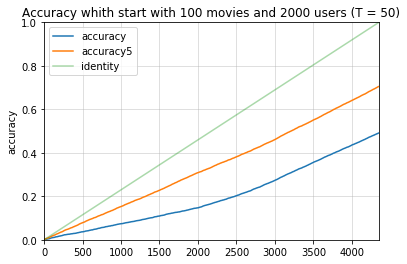

Accuracy : 49.1151 %
Accuracy-5 : 70.5125 %


In [33]:
score,score3 = compute_score(features_users,features_movies,UlearnR,VlearnR,5)
    
plt.plot(score,label="accuracy")
plt.plot(score3,label="accuracy5")
plt.plot([i/len(features_users) for i in range(len(features_users))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(features_users))
plt.legend()
plt.ylim(0,1)
plt.ylabel("accuracy")
plt.title("Accuracy whith start with 100 movies and 2000 users (T = 50)")
plt.show()
print("Accuracy :", round(score[-1]*100,4), "%")
print("Accuracy-5 :", round(score3[-1]*100,4), "%")

On constate qu'après apprentissage avec l'algorithme de Linear UCB, l'accuracy augmente légérement (41% à 49%) par rapport à l'accuracy initiale. Cela n'est pas surprenant : En effet, les features apprises tendent à ressembler aux features finales, car c'est sur ces dernières que sont basées les rewards de l'algorithme.

# E. Utilisons une bonne factorisation


## E.1 Changeons de modèle

L'équipe **MBML team 1** nous a très aimablement preté leur code pour la factorisation de matrice, ce qui nous permet de tester nos algorithme sur des matrices correctes !

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


def loadData(directory):
    """
    Takes as input the directory of the dataset.
    Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.csv',
                          usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv(directory + 'movies.csv')
    return ratings, movies


def Df2Numpy(ratings):
    ratingsMatrix = ratings.pivot(index='userId',
                                  columns='movieId',
                                  values='rating')
    ratingsMatrix = ratingsMatrix.fillna(0)
    R = ratingsMatrix.to_numpy()
    return R


class MatrixFactorization():
    """
    A simple Matrix Factorization Class
    Assumes ratings is a m x n Numpy array
    nFactors is the intermediate dimension k of the Matrices U and V
    lambdaReg and muReg are regularization parameters
    """
    def __init__(self,
                 ratings,
                 nFactors=10,
                 alpha=0.01,
                 lambdaReg=0.0,
                 muReg=0.0,
                 biasReg=0.0,
                 maxIter=50,
                 epsilon=0.001,
                 trainFrac=0.8,
                 valFrac=0.1,
                 testFrac=0.1):
        self.R = ratings
        self.nFactors = nFactors
        self.lambdaReg = lambdaReg
        self.alpha = alpha
        self.muReg = muReg
        self.biasReg = biasReg
        self.maxIter = maxIter
        self.epsilon = 0.1
        self.nUsers, self.nMovies = ratings.shape
        self.trainFrac = trainFrac
        self.valFrac = valFrac
        self.testFrac = testFrac

        self.U = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nMovies, self.nFactors))

        # self.userBias = np.zeros(self.nUsers)
        # self.movieBias = np.zeros(self.nMovies)
        # self.globalBias = np.mean(self.R[np.where(self.R != 0)])

    def matrix2Samples(self, matrix):
        """
        Convert matrix to a list of tuples (row, column, value) with only
        nonzero entries of the matrix
        """
        samples = [(i, j, matrix[i, j]) for i in range(matrix.shape[0])
                   for j in range(matrix.shape[1]) if matrix[i, j] > 0]
        return samples

    def samples2Matrix(self, samples, m, n):
        """
        Convert list of tuples (row, column, value) to a matrix
        of size m x n
        """
        matrix = np.zeros(m, n)
        for s in samples:
            i, j, v = s
            matrix[i, j] = v
            return matrix

    def randomInit(self):
        """
        Initialise target matrices U and V using normally distributed
        numbers
        """
        self.U = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(scale=(1. / self.nFactors),
                                  size=(self.nMovies, self.nFactors))

    def splitTrainValSets(self, nGrades=10):
        """
        Split the observed data (nonzero entries) into a training set
        and a validation set by removing 10 grades per user and assigning them
        to the validation set
        """
        valMatrix = np.zeros(self.R.shape)
        trainMatrix = self.R.copy()
        for i in range(self.R.shape[0]):
            valRatingsIds = np.random.choice(self.R[i, :].nonzero()[0],
                                             size=min(nGrades,len(self.R[i,:].nonzero()[0])//2),
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = self.R[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        trainSamples = self.matrix2Samples(trainMatrix)
        valSamples = self.matrix2Samples(valMatrix)
        return trainSamples, valSamples

    def stochasticGradientDescentPass(self, trainSamples):
        """
        Stochastic gradient descent iteration
        """
        for s in trainSamples:
            i, j, _ = s
            r_hat_ij = np.dot(self.U[i, :], self.V.T[:, j])
            #+self.userBias[i] + self.movieBias[j]
            eij = self.R[i, j] - r_hat_ij
            tmpU = np.zeros(self.nFactors)
            tmpV = np.zeros(self.nFactors)
            for q in range(self.nFactors):
                tmpU[q] = self.U[i, q] + self.alpha * (
                    eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
                tmpV[q] = self.V[j, q] + self.alpha * (
                    eij * self.U[i, q] - self.muReg * self.V[j, q])

            # self.userBias[i] += self.alpha * (eij -
            #                                   self.biasReg * self.userBias[i])
            # self.movieBias[j] += self.alpha * (
            #     eij - self.biasReg * self.movieBias[j])

            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]

        return self.U, self.V

    def stochasticGradientDescent(self, logging=True,nGrades=10):
        """
        Train using stochastic gradient descent
        """
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit()
        trainSamples, valSamples = self.splitTrainValSets(nGrades)
        for i in range(self.maxIter):
            print("Iteration : ",i)
            np.random.shuffle(trainSamples)
            U, V = self.stochasticGradientDescentPass(trainSamples)
            trainError = self.computeTotalErrorSamples(trainSamples)

            if logging:
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            if trainError < self.epsilon:
                break

        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history

    def plotHistory(self, history):
        plt.plot(history['trainErrors'], label='Training Error')
        plt.plot(history['valErrors'], label='Validation Error')
        plt.title('Error(iteration)')
        plt.ylabel('Mean Square Error')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()

    def computeTotalErrorSamples(self, data):
        error = 0
        if len(data) == 0:
            return 0
        for s in data:
            i, j, r = s
            error += (r - np.dot(self.U[i, :], self.V.T[:, j]))**2
            # error += (r - (np.dot(self.U[i, :], self.V.T[:, j]) +
            #                self.userBias[i] + self.movieBias[j]))**2
        return math.sqrt(error / len(data))

    def computeApproximatedMatrix(self, U, V):
        return np.dot(U, V.T)

Calculons d'abord les features des utilisateurs et des films pour la matrice M entière.

In [35]:
mf = MatrixFactorization(M,maxIter=20)
gU,gV,h = mf.stochasticGradientDescent()

Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


Calculons maintenant la même chose pour la sous matrice des 3000 premiers utilisateurs et 150 films.

In [36]:
sub_mf = MatrixFactorization(M[:3000,:150],maxIter=20)
sub_gU,sub_gV,sub_h = sub_mf.stochasticGradientDescent()

Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


Sur les graphe ci-dessous, l'overfitting est visible. Cela est dû au fait que l'on utilise très peu de données dans nos experience (4000 utilisateur x 200 films).

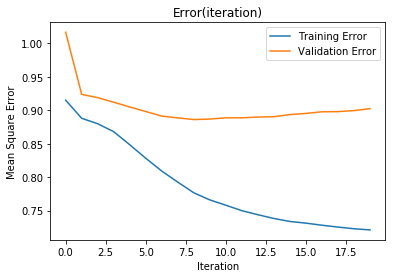

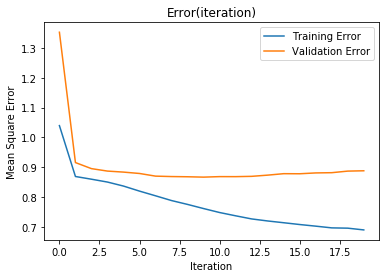

In [37]:
mf.plotHistory(h)
sub_mf.plotHistory(sub_h)

Ci-dessous, nous affichons à quel point les deux versions des features sont similaires grâce à la mesure de l'accuracy.

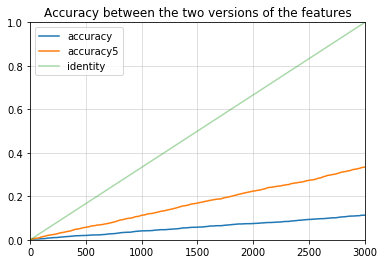

Accuracy : 11.3333 %
Accuracy-5 : 33.4333 %


In [38]:
score = [0]
for j in range(len(sub_gU)):
    add = 0
    if np.argmax([sub_gU[j].dot(sub_gV[i]) for i in range(150)]) == np.argmax([gU[j].dot(gV[i]) for i in range(150)]):
        add = 1
    score.append(score[-1] + add)
    
score3 = [0]
for j in range(len(sub_gU)):
    add = 0
    if np.argmax([gU[j].dot(gV[i]) for i in range(150)]) in np.argsort([sub_gU[j].dot(sub_gV[i]) for i in range(150)])[-1:-1-5:-1]:
        add = 1
    score3.append(score3[-1] + add)
    
    
score = [si/len(sub_gU) for si in score]
score3 = [si/len(sub_gU) for si in score3]
plt.plot(score,label="accuracy")
plt.plot(score3,label="accuracy5")
plt.plot([i/len(sub_gU) for i in range(len(sub_gU))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(sub_gU))
plt.legend()
plt.ylim(0,1)
plt.title("Accuracy between the two versions of the features")
plt.show()
print("Accuracy :",round(score[-1]*100,4), "%")
print("Accuracy-5 :",round(score3[-1]*100,4), "%")

Encore une fois, les features apprises pour la matrice M et la sous-matrices donnent des classements de films très différents. L'accuracy que nous allons obtenir sera donc sûrement très faible. Cependant, ce qui nous interesse vraiment, c'est plutôt la **RMSE** des 2 versions des features. En effet, c'est grâce à cela qu'on va pouvoir dire si notre modèle est bon ou non. 

En particulier, on voit ci-dessous que la loss des 2 versions est plutot correcte (même si l'on sait que cela est du en partie à l'overfit).

In [39]:
def loss_rmse(U,V,M):
    error = 0
    count = 0
    L = []
    for i in range(len(M)):
        for j in range(len(M[0])):
            r = M[i,j]
            if r > 0:
                error += (r - np.dot(U[i,:], V.T[:,j]))**2
                count += 1
        L.append(np.sqrt(error/count))
    return np.sqrt(error /count),L


In [40]:
print(loss_rmse(gU[:3000],gV[:150],M[:3000,:150])[0])
print(loss_rmse(sub_gU,sub_gV,M[:3000,:150])[0])

0.7403469395204128
0.7326983854020714


## E.2 Apprentissage

Reprenons maintenant l'expérience de la partie D avec ces nouvelles features

In [41]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=True,T_max=100,nb_sugg=5,big_step=2,proba=1/10)

INIT...
0 . ADDING USER  3001
1 . ADDING MOVIE  151
2 . ADDING USER  3002
3 . ADDING USER  3003
4 . ADDING USER  3004
5 . ADDING USER  3005
6 . ADDING USER  3006
7 . ADDING USER  3007
8 . ADDING USER  3008
9 . ADDING USER  3009
10 . ADDING USER  3010
11 . ADDING USER  3011
12 . ADDING USER  3012
13 . ADDING USER  3013
14 . ADDING MOVIE  152
15 . ADDING USER  3014
16 . ADDING USER  3015
17 . ADDING USER  3016
18 . ADDING USER  3017
19 . ADDING MOVIE  153
20 . ADDING USER  3018
21 . ADDING USER  3019
22 . ADDING USER  3020
23 . ADDING USER  3021
24 . ADDING USER  3022
25 . ADDING USER  3023
26 . ADDING USER  3024
27 . ADDING USER  3025
28 . ADDING USER  3026
29 . ADDING MOVIE  154
30 . ADDING USER  3027
31 . ADDING USER  3028
32 . ADDING USER  3029
33 . ADDING USER  3030
34 . ADDING MOVIE  155
35 . ADDING USER  3031
36 . ADDING USER  3032
37 . ADDING USER  3033
38 . ADDING USER  3034
39 . ADDING USER  3035
40 . ADDING MOVIE  156
41 . ADDING USER  3036
42 . ADDING USER  3037
43 . ADDING U

347 . ADDING USER  3316
348 . ADDING USER  3317
349 . ADDING USER  3318
350 . ADDING USER  3319
351 . ADDING USER  3320
352 . ADDING USER  3321
353 . ADDING USER  3322
354 . ADDING MOVIE  183
355 . ADDING USER  3323
356 . ADDING USER  3324
357 . ADDING USER  3325
358 . ADDING USER  3326
359 . ADDING USER  3327
360 . ADDING USER  3328
361 . ADDING USER  3329
362 . ADDING USER  3330
363 . ADDING USER  3331
364 . ADDING USER  3332
365 . ADDING USER  3333
366 . ADDING USER  3334
367 . ADDING USER  3335
368 . ADDING MOVIE  184
369 . ADDING USER  3336
370 . ADDING USER  3337
371 . ADDING USER  3338
372 . ADDING USER  3339
373 . ADDING USER  3340
374 . ADDING USER  3341
375 . ADDING USER  3342
376 . ADDING USER  3343
377 . ADDING USER  3344
378 . ADDING USER  3345
379 . ADDING USER  3346
380 . ADDING USER  3347
381 . ADDING USER  3348
382 . ADDING USER  3349
383 . ADDING USER  3350
384 . ADDING USER  3351
385 . ADDING MOVIE  185
386 . ADDING USER  3352
387 . ADDING USER  3353
388 . ADDING USE

689 . ADDING USER  3633
690 . ADDING USER  3634
691 . ADDING USER  3635
692 . ADDING USER  3636
693 . ADDING USER  3637
694 . ADDING USER  3638
695 . ADDING USER  3639
696 . ADDING USER  3640
697 . ADDING USER  3641
698 . ADDING USER  3642
699 . ADDING USER  3643
700 . ADDING USER  3644
701 . ADDING USER  3645
702 . ADDING USER  3646
703 . ADDING USER  3647
704 . ADDING USER  3648
705 . ADDING USER  3649
706 . ADDING USER  3650
707 . ADDING USER  3651
708 . ADDING USER  3652
709 . ADDING USER  3653
710 . ADDING USER  3654
711 . ADDING USER  3655
712 . ADDING USER  3656
713 . ADDING USER  3657
714 . ADDING USER  3658
715 . ADDING USER  3659
716 . ADDING USER  3660
717 . ADDING USER  3661
718 . ADDING USER  3662
719 . ADDING USER  3663
720 . ADDING USER  3664
721 . ADDING USER  3665
722 . ADDING USER  3666
723 . ADDING USER  3667
724 . ADDING USER  3668
725 . ADDING USER  3669
726 . ADDING USER  3670
727 . ADDING USER  3671
728 . ADDING USER  3672
729 . ADDING USER  3673
730 . ADDING USE

1031 . ADDING USER  3975
1032 . ADDING USER  3976
1033 . ADDING USER  3977
1034 . ADDING USER  3978
1035 . ADDING USER  3979
1036 . ADDING USER  3980
1037 . ADDING USER  3981
1038 . ADDING USER  3982
1039 . ADDING USER  3983
1040 . ADDING USER  3984
1041 . ADDING USER  3985
1042 . ADDING USER  3986
1043 . ADDING USER  3987
1044 . ADDING USER  3988
1045 . ADDING USER  3989
1046 . ADDING USER  3990
1047 . ADDING USER  3991
1048 . ADDING USER  3992
1049 . ADDING USER  3993
1050 . ADDING USER  3994
1051 . ADDING USER  3995
1052 . ADDING USER  3996
1053 . ADDING USER  3997
1054 . ADDING USER  3998
1055 . ADDING USER  3999
1056 . ADDING USER  4000
1057 . ADDING USER  4001
1058 . ADDING USER  4002
1059 . ADDING USER  4003
1060 . ADDING USER  4004
1061 . ADDING USER  4005
1062 . ADDING USER  4006
1063 . ADDING USER  4007
1064 . ADDING USER  4008
1065 . ADDING USER  4009
1066 . ADDING USER  4010
1067 . ADDING USER  4011
1068 . ADDING USER  4012
1069 . ADDING USER  4013
1070 . ADDING USER  4014


1359 . ADDING USER  4303
1360 . ADDING USER  4304
1361 . ADDING USER  4305
1362 . ADDING USER  4306
1363 . ADDING USER  4307
1364 . ADDING USER  4308
1365 . ADDING USER  4309
1366 . ADDING USER  4310
1367 . ADDING USER  4311
1368 . ADDING USER  4312
1369 . ADDING USER  4313
1370 . ADDING USER  4314
1371 . ADDING USER  4315
1372 . ADDING USER  4316
1373 . ADDING USER  4317
1374 . ADDING USER  4318
1375 . ADDING USER  4319
1376 . ADDING USER  4320
1377 . ADDING USER  4321
1378 . ADDING USER  4322
1379 . ADDING USER  4323
1380 . ADDING USER  4324
1381 . ADDING USER  4325
1382 . ADDING USER  4326
1383 . ADDING USER  4327
1384 . ADDING USER  4328
1385 . ADDING USER  4329
1386 . ADDING USER  4330
1387 . ADDING USER  4331
1388 . ADDING USER  4332
1389 . ADDING USER  4333
1390 . ADDING USER  4334
1391 . ADDING USER  4335
1392 . ADDING USER  4336
1393 . ADDING USER  4337
1394 . ADDING USER  4338
1395 . ADDING USER  4339
1396 . ADDING USER  4340
1397 . ADDING USER  4341
1398 . ADDING USER  4342


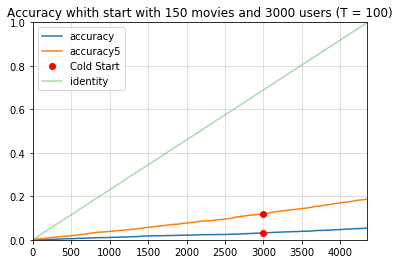

Accuracy : 5.36 %
Accuracy-5 : 18.8 %


In [42]:
score,score3 = compute_score(features_users,features_movies,UlearnGR,VlearnGR,5)
    
plt.plot(score,label="accuracy")
plt.plot(score3,label="accuracy5")
plt.plot([3000],[score[3000]],'o',color="red",label="Cold Start")
plt.plot([3000],[score3[3000]],'o',color="red")
plt.plot([i/len(gU) for i in range(len(gU))],label="identity",alpha=0.4)
plt.grid(alpha=0.5)
plt.xlim(0,len(gU))
plt.legend()
plt.ylim(0,1)
plt.title("Accuracy whith start with 150 movies and 3000 users (T = 100)")
plt.show()
print("Accuracy :",round(score[-1],4)*100, "%")
print("Accuracy-5 :",round(score3[-1],4)*100, "%")

Comme on pouvait s'y attendre, l'accuracy obtenue n'est pas très bonne. Cependant, nous avons vu que l'accuracy n'était pas une mesure parfaite pour ce problème. Regardons plutot ce que l'on obtient avec la loss RMSE.

In [43]:
lg,Lg = loss_rmse(gU,gV,M)
ll,Ll = loss_rmse(UlearnGR,VlearnGR,M)
lp,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])

Original Loss : 0.7516576806244263
Loss for learnt features : 0.8078784156077521
Loss for learnt features for Users > 3000 : 0.8358652321266641


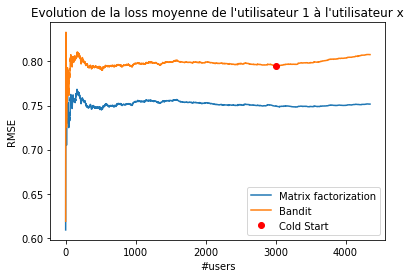

In [44]:
print("Original Loss :",lg)
print("Loss for learnt features :",ll)
print("Loss for learnt features for Users > 3000 :",lp)
plt.plot(Lg,label="Matrix factorization")
plt.plot(Ll,label="Bandit")
plt.plot([3000],[Ll[3000]],'o',color="red",label="Cold Start")
plt.title("Evolution de la loss moyenne de l'utilisateur 1 à l'utilisateur x")
plt.xlabel("#users")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Bien qu'un peu plus élevé que la loss originale, notre loss est assez satisfaisante, et notamment pour les utilisateurs dont les features ont été apprises par notre algorithme.

## E.3 Combinons tout ce que l'on a jusqu'à maintenant

Maintenant, combinons tout ce que l'on a jusqu'à maintenant pour créer le scenario le plus réaliste possible :

* **Systeme dynamique** avec ajout continu d'utilisateurs et de films *(partie 2.B)*
* Factorisation de matrices par **descente de gradient** *(partie 2.E.1)*
* Démarrage avec uniquement des utilisateurs et films **connus au lancement** *(partie 2.D)*
* Rewards basées sur les **ratings réels** des films vus *(partie 2.C)*

In [45]:
def MLinUCB_real(start_movies,start_users,ratings,users_seen,movies_seen,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("INIT...")
    (n,m) = ratings.shape
    d = len(start_movies[0])
    (nb_movies,nb_users) = (len(start_movies),len(start_users))
    features_users_l = start_users
    features_movies_l = start_movies
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            if verbose:
                print(elemi,". ADDING USER ",nb_users)
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,users_seen[nb_users-1],nb_movies)
            print("Have seen ",len(seen))
        else:
            if verbose:
                print(elemi,". ADDING MOVIE ",nb_movies)
            V,D,theta,N,seen = MLinUCB_init(nb_movies,d,lambd,movies_seen[nb_movies-1],nb_users)
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards = MLinUCB_select_movie(theta,features_movies_l,nb_users-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[seen.index(chosen_movies[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards = MLinUCB_select_user(theta,features_users_l,nb_movies-1,seen,ratings,sigma,alpha,N,nb_sugg)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[seen.index(chosen_users[i])]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
            
    return features_users_l,features_movies_l


Essayons tout d'abord avec un petit nombre d'étape : 25 étapes par nouvel élément.

In [46]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=True,T_max=25,nb_sugg=5,big_step=1,proba=1/10)

np.random.seed(0)
UlearnGRM,VlearnGRM = MLinUCB_real(sub_gV,sub_gU,M,users_seen,movies_seen,new_elems=7000,verbose=True,T_max=25,nb_sugg=5,big_step=1,proba=1/10)

INIT...
0 . ADDING USER  3001
1 . ADDING USER  3002
2 . ADDING USER  3003
3 . ADDING USER  3004
4 . ADDING USER  3005
5 . ADDING USER  3006
6 . ADDING USER  3007
7 . ADDING USER  3008
8 . ADDING USER  3009
9 . ADDING USER  3010
10 . ADDING MOVIE  151
11 . ADDING USER  3011
12 . ADDING USER  3012
13 . ADDING USER  3013
14 . ADDING USER  3014
15 . ADDING USER  3015
16 . ADDING USER  3016
17 . ADDING USER  3017
18 . ADDING MOVIE  152
19 . ADDING MOVIE  153
20 . ADDING USER  3018
21 . ADDING USER  3019
22 . ADDING USER  3020
23 . ADDING USER  3021
24 . ADDING USER  3022
25 . ADDING MOVIE  154
26 . ADDING USER  3023
27 . ADDING USER  3024
28 . ADDING USER  3025
29 . ADDING USER  3026
30 . ADDING USER  3027
31 . ADDING USER  3028
32 . ADDING MOVIE  155
33 . ADDING USER  3029
34 . ADDING USER  3030
35 . ADDING USER  3031
36 . ADDING USER  3032
37 . ADDING USER  3033
38 . ADDING USER  3034
39 . ADDING USER  3035
40 . ADDING USER  3036
41 . ADDING USER  3037
42 . ADDING USER  3038
43 . ADDING U

350 . ADDING MOVIE  188
351 . ADDING USER  3314
352 . ADDING USER  3315
353 . ADDING USER  3316
354 . ADDING USER  3317
355 . ADDING USER  3318
356 . ADDING USER  3319
357 . ADDING USER  3320
358 . ADDING MOVIE  189
359 . ADDING USER  3321
360 . ADDING USER  3322
361 . ADDING USER  3323
362 . ADDING USER  3324
363 . ADDING USER  3325
364 . ADDING USER  3326
365 . ADDING USER  3327
366 . ADDING USER  3328
367 . ADDING USER  3329
368 . ADDING USER  3330
369 . ADDING USER  3331
370 . ADDING USER  3332
371 . ADDING MOVIE  190
372 . ADDING USER  3333
373 . ADDING USER  3334
374 . ADDING USER  3335
375 . ADDING USER  3336
376 . ADDING USER  3337
377 . ADDING USER  3338
378 . ADDING USER  3339
379 . ADDING USER  3340
380 . ADDING USER  3341
381 . ADDING USER  3342
382 . ADDING USER  3343
383 . ADDING USER  3344
384 . ADDING USER  3345
385 . ADDING USER  3346
386 . ADDING USER  3347
387 . ADDING USER  3348
388 . ADDING USER  3349
389 . ADDING USER  3350
390 . ADDING USER  3351
391 . ADDING USE

694 . ADDING USER  3638
695 . ADDING USER  3639
696 . ADDING USER  3640
697 . ADDING USER  3641
698 . ADDING USER  3642
699 . ADDING USER  3643
700 . ADDING USER  3644
701 . ADDING USER  3645
702 . ADDING USER  3646
703 . ADDING USER  3647
704 . ADDING USER  3648
705 . ADDING USER  3649
706 . ADDING USER  3650
707 . ADDING USER  3651
708 . ADDING USER  3652
709 . ADDING USER  3653
710 . ADDING USER  3654
711 . ADDING USER  3655
712 . ADDING USER  3656
713 . ADDING USER  3657
714 . ADDING USER  3658
715 . ADDING USER  3659
716 . ADDING USER  3660
717 . ADDING USER  3661
718 . ADDING USER  3662
719 . ADDING USER  3663
720 . ADDING USER  3664
721 . ADDING USER  3665
722 . ADDING USER  3666
723 . ADDING USER  3667
724 . ADDING USER  3668
725 . ADDING USER  3669
726 . ADDING USER  3670
727 . ADDING USER  3671
728 . ADDING USER  3672
729 . ADDING USER  3673
730 . ADDING USER  3674
731 . ADDING USER  3675
732 . ADDING USER  3676
733 . ADDING USER  3677
734 . ADDING USER  3678
735 . ADDING USE

1036 . ADDING USER  3980
1037 . ADDING USER  3981
1038 . ADDING USER  3982
1039 . ADDING USER  3983
1040 . ADDING USER  3984
1041 . ADDING USER  3985
1042 . ADDING USER  3986
1043 . ADDING USER  3987
1044 . ADDING USER  3988
1045 . ADDING USER  3989
1046 . ADDING USER  3990
1047 . ADDING USER  3991
1048 . ADDING USER  3992
1049 . ADDING USER  3993
1050 . ADDING USER  3994
1051 . ADDING USER  3995
1052 . ADDING USER  3996
1053 . ADDING USER  3997
1054 . ADDING USER  3998
1055 . ADDING USER  3999
1056 . ADDING USER  4000
1057 . ADDING USER  4001
1058 . ADDING USER  4002
1059 . ADDING USER  4003
1060 . ADDING USER  4004
1061 . ADDING USER  4005
1062 . ADDING USER  4006
1063 . ADDING USER  4007
1064 . ADDING USER  4008
1065 . ADDING USER  4009
1066 . ADDING USER  4010
1067 . ADDING USER  4011
1068 . ADDING USER  4012
1069 . ADDING USER  4013
1070 . ADDING USER  4014
1071 . ADDING USER  4015
1072 . ADDING USER  4016
1073 . ADDING USER  4017
1074 . ADDING USER  4018
1075 . ADDING USER  4019


1371 . ADDING USER  4315
1372 . ADDING USER  4316
1373 . ADDING USER  4317
1374 . ADDING USER  4318
1375 . ADDING USER  4319
1376 . ADDING USER  4320
1377 . ADDING USER  4321
1378 . ADDING USER  4322
1379 . ADDING USER  4323
1380 . ADDING USER  4324
1381 . ADDING USER  4325
1382 . ADDING USER  4326
1383 . ADDING USER  4327
1384 . ADDING USER  4328
1385 . ADDING USER  4329
1386 . ADDING USER  4330
1387 . ADDING USER  4331
1388 . ADDING USER  4332
1389 . ADDING USER  4333
1390 . ADDING USER  4334
1391 . ADDING USER  4335
1392 . ADDING USER  4336
1393 . ADDING USER  4337
1394 . ADDING USER  4338
1395 . ADDING USER  4339
1396 . ADDING USER  4340
1397 . ADDING USER  4341
1398 . ADDING USER  4342
1399 . ADDING USER  4343
1400 . ADDING USER  4344
1401 . ADDING USER  4345
1402 . ADDING USER  4346
1403 . ADDING USER  4347
1404 . ADDING USER  4348
1405 . ADDING USER  4349
1406 . ADDING USER  4350
1407 . ADDING USER  4351
INIT...
0 . ADDING USER  3001
Have seen  73
1 . ADDING USER  3002
Have seen

205 . ADDING USER  3181
Have seen  71
206 . ADDING USER  3182
Have seen  34
207 . ADDING USER  3183
Have seen  86
208 . ADDING MOVIE  176
209 . ADDING USER  3184
Have seen  48
210 . ADDING USER  3185
Have seen  18
211 . ADDING USER  3186
Have seen  29
212 . ADDING USER  3187
Have seen  19
213 . ADDING USER  3188
Have seen  48
214 . ADDING USER  3189
Have seen  65
215 . ADDING USER  3190
Have seen  97
216 . ADDING USER  3191
Have seen  57
217 . ADDING USER  3192
Have seen  44
218 . ADDING USER  3193
Have seen  64
219 . ADDING USER  3194
Have seen  14
220 . ADDING MOVIE  177
221 . ADDING USER  3195
Have seen  36
222 . ADDING USER  3196
Have seen  34
223 . ADDING USER  3197
Have seen  37
224 . ADDING USER  3198
Have seen  91
225 . ADDING USER  3199
Have seen  69
226 . ADDING USER  3200
Have seen  114
227 . ADDING USER  3201
Have seen  88
228 . ADDING USER  3202
Have seen  23
229 . ADDING USER  3203
Have seen  48
230 . ADDING USER  3204
Have seen  49
231 . ADDING USER  3205
Have seen  119


Have seen  30
437 . ADDING USER  3392
Have seen  60
438 . ADDING USER  3393
Have seen  60
439 . ADDING USER  3394
Have seen  73
440 . ADDING USER  3395
Have seen  33
441 . ADDING USER  3396
Have seen  44
442 . ADDING USER  3397
Have seen  48
443 . ADDING USER  3398
Have seen  81
444 . ADDING USER  3399
Have seen  111
445 . ADDING USER  3400
Have seen  82
446 . ADDING USER  3401
Have seen  23
447 . ADDING MOVIE  197
448 . ADDING USER  3402
Have seen  56
449 . ADDING USER  3403
Have seen  45
450 . ADDING USER  3404
Have seen  23
451 . ADDING USER  3405
Have seen  21
452 . ADDING USER  3406
Have seen  31
453 . ADDING USER  3407
Have seen  19
454 . ADDING USER  3408
Have seen  79
455 . ADDING MOVIE  198
456 . ADDING USER  3409
Have seen  29
457 . ADDING USER  3410
Have seen  24
458 . ADDING USER  3411
Have seen  108
459 . ADDING USER  3412
Have seen  34
460 . ADDING USER  3413
Have seen  47
461 . ADDING USER  3414
Have seen  64
462 . ADDING USER  3415
Have seen  20
463 . ADDING USER  3416


675 . ADDING USER  3619
Have seen  28
676 . ADDING USER  3620
Have seen  83
677 . ADDING USER  3621
Have seen  33
678 . ADDING USER  3622
Have seen  91
679 . ADDING USER  3623
Have seen  168
680 . ADDING USER  3624
Have seen  77
681 . ADDING USER  3625
Have seen  40
682 . ADDING USER  3626
Have seen  32
683 . ADDING USER  3627
Have seen  31
684 . ADDING USER  3628
Have seen  63
685 . ADDING USER  3629
Have seen  34
686 . ADDING USER  3630
Have seen  45
687 . ADDING USER  3631
Have seen  96
688 . ADDING USER  3632
Have seen  141
689 . ADDING USER  3633
Have seen  43
690 . ADDING USER  3634
Have seen  37
691 . ADDING USER  3635
Have seen  166
692 . ADDING USER  3636
Have seen  27
693 . ADDING USER  3637
Have seen  43
694 . ADDING USER  3638
Have seen  103
695 . ADDING USER  3639
Have seen  32
696 . ADDING USER  3640
Have seen  31
697 . ADDING USER  3641
Have seen  38
698 . ADDING USER  3642
Have seen  56
699 . ADDING USER  3643
Have seen  80
700 . ADDING USER  3644
Have seen  75
701 . AD

892 . ADDING USER  3836
Have seen  77
893 . ADDING USER  3837
Have seen  20
894 . ADDING USER  3838
Have seen  160
895 . ADDING USER  3839
Have seen  56
896 . ADDING USER  3840
Have seen  40
897 . ADDING USER  3841
Have seen  118
898 . ADDING USER  3842
Have seen  72
899 . ADDING USER  3843
Have seen  62
900 . ADDING USER  3844
Have seen  203
901 . ADDING USER  3845
Have seen  48
902 . ADDING USER  3846
Have seen  91
903 . ADDING USER  3847
Have seen  113
904 . ADDING USER  3848
Have seen  20
905 . ADDING USER  3849
Have seen  102
906 . ADDING USER  3850
Have seen  26
907 . ADDING USER  3851
Have seen  26
908 . ADDING USER  3852
Have seen  34
909 . ADDING USER  3853
Have seen  32
910 . ADDING USER  3854
Have seen  57
911 . ADDING USER  3855
Have seen  165
912 . ADDING USER  3856
Have seen  57
913 . ADDING USER  3857
Have seen  87
914 . ADDING USER  3858
Have seen  41
915 . ADDING USER  3859
Have seen  171
916 . ADDING USER  3860
Have seen  43
917 . ADDING USER  3861
Have seen  48
918 .

1118 . ADDING USER  4062
Have seen  77
1119 . ADDING USER  4063
Have seen  120
1120 . ADDING USER  4064
Have seen  43
1121 . ADDING USER  4065
Have seen  80
1122 . ADDING USER  4066
Have seen  27
1123 . ADDING USER  4067
Have seen  72
1124 . ADDING USER  4068
Have seen  54
1125 . ADDING USER  4069
Have seen  28
1126 . ADDING USER  4070
Have seen  94
1127 . ADDING USER  4071
Have seen  114
1128 . ADDING USER  4072
Have seen  32
1129 . ADDING USER  4073
Have seen  20
1130 . ADDING USER  4074
Have seen  116
1131 . ADDING USER  4075
Have seen  51
1132 . ADDING USER  4076
Have seen  30
1133 . ADDING USER  4077
Have seen  56
1134 . ADDING USER  4078
Have seen  21
1135 . ADDING USER  4079
Have seen  22
1136 . ADDING USER  4080
Have seen  139
1137 . ADDING USER  4081
Have seen  45
1138 . ADDING USER  4082
Have seen  107
1139 . ADDING USER  4083
Have seen  59
1140 . ADDING USER  4084
Have seen  61
1141 . ADDING USER  4085
Have seen  33
1142 . ADDING USER  4086
Have seen  134
1143 . ADDING USER 

1329 . ADDING USER  4273
Have seen  21
1330 . ADDING USER  4274
Have seen  27
1331 . ADDING USER  4275
Have seen  36
1332 . ADDING USER  4276
Have seen  71
1333 . ADDING USER  4277
Have seen  60
1334 . ADDING USER  4278
Have seen  133
1335 . ADDING USER  4279
Have seen  43
1336 . ADDING USER  4280
Have seen  47
1337 . ADDING USER  4281
Have seen  45
1338 . ADDING USER  4282
Have seen  157
1339 . ADDING USER  4283
Have seen  113
1340 . ADDING USER  4284
Have seen  111
1341 . ADDING USER  4285
Have seen  80
1342 . ADDING USER  4286
Have seen  48
1343 . ADDING USER  4287
Have seen  24
1344 . ADDING USER  4288
Have seen  54
1345 . ADDING USER  4289
Have seen  60
1346 . ADDING USER  4290
Have seen  81
1347 . ADDING USER  4291
Have seen  139
1348 . ADDING USER  4292
Have seen  24
1349 . ADDING USER  4293
Have seen  29
1350 . ADDING USER  4294
Have seen  24
1351 . ADDING USER  4295
Have seen  78
1352 . ADDING USER  4296
Have seen  133
1353 . ADDING USER  4297
Have seen  23
1354 . ADDING USER 

Original Loss : 0.7516576806244263
Loss for learnt features (features version): 0.8576080736049375
Loss for learnt features for Users > 3000 (features version) : 0.9244021132696817
Loss for learnt features (ratings version): 1.076019614555401
Loss for learnt features for Users > 3000 (ratigns version) : 1.4229783272806504


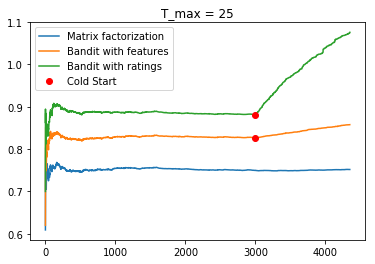

In [47]:
llvf,Llvf = loss_rmse(UlearnGR,VlearnGR,M)
llvm,Llvm = loss_rmse(UlearnGRM,VlearnGRM,M)
lpf,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])
lpm,_ = loss_rmse(UlearnGRM[3000:],VlearnGRM,M[3000:,:])
print("Original Loss :",lg)
print("Loss for learnt features (features version):",llvf)
print("Loss for learnt features for Users > 3000 (features version) :",lpf)
print("Loss for learnt features (ratings version):",llvm)
print("Loss for learnt features for Users > 3000 (ratigns version) :",lpm)

plt.plot(Lg,label="Matrix factorization")
plt.plot(Llvf,label="Bandit with features")
plt.plot(Llvm,label="Bandit with ratings")
plt.plot([3000],[Llvf[2999]],'o',color="red",label="Cold Start")
plt.plot([3000],[Llvm[2999]],'o',color="red")
plt.title("T_max = 25")
plt.legend()
plt.show()

On constate que pour la méthode utilisant les vrais ratings (courbe verte), l'algorithme à du mal à apprendre les features des nouveaux utilisateurs. Cela est peut-être du au fait qu'il y a trop peu de données pour s'entrainer correctement. Observons ce qu'il se passe pour un plus grand nombre d'étapes, par exemple $T = 100$

In [48]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=True,T_max=100,nb_sugg=5,big_step=1,proba=1/10)

np.random.seed(0)
UlearnGRM,VlearnGRM = MLinUCB_real(sub_gV,sub_gU,M,users_seen,movies_seen,new_elems=7000,verbose=True,T_max=100,nb_sugg=5,big_step=1,proba=1/10)

INIT...
0 . ADDING USER  3001
1 . ADDING MOVIE  151
2 . ADDING USER  3002
3 . ADDING USER  3003
4 . ADDING USER  3004
5 . ADDING USER  3005
6 . ADDING USER  3006
7 . ADDING USER  3007
8 . ADDING USER  3008
9 . ADDING USER  3009
10 . ADDING USER  3010
11 . ADDING USER  3011
12 . ADDING USER  3012
13 . ADDING USER  3013
14 . ADDING MOVIE  152
15 . ADDING USER  3014
16 . ADDING USER  3015
17 . ADDING USER  3016
18 . ADDING USER  3017
19 . ADDING MOVIE  153
20 . ADDING USER  3018
21 . ADDING USER  3019
22 . ADDING USER  3020
23 . ADDING USER  3021
24 . ADDING USER  3022
25 . ADDING USER  3023
26 . ADDING USER  3024
27 . ADDING USER  3025
28 . ADDING USER  3026
29 . ADDING MOVIE  154
30 . ADDING USER  3027
31 . ADDING USER  3028
32 . ADDING USER  3029
33 . ADDING USER  3030
34 . ADDING MOVIE  155
35 . ADDING USER  3031
36 . ADDING USER  3032
37 . ADDING USER  3033
38 . ADDING USER  3034
39 . ADDING USER  3035
40 . ADDING MOVIE  156
41 . ADDING USER  3036
42 . ADDING USER  3037
43 . ADDING U

347 . ADDING USER  3316
348 . ADDING USER  3317
349 . ADDING USER  3318
350 . ADDING USER  3319
351 . ADDING USER  3320
352 . ADDING USER  3321
353 . ADDING USER  3322
354 . ADDING MOVIE  183
355 . ADDING USER  3323
356 . ADDING USER  3324
357 . ADDING USER  3325
358 . ADDING USER  3326
359 . ADDING USER  3327
360 . ADDING USER  3328
361 . ADDING USER  3329
362 . ADDING USER  3330
363 . ADDING USER  3331
364 . ADDING USER  3332
365 . ADDING USER  3333
366 . ADDING USER  3334
367 . ADDING USER  3335
368 . ADDING MOVIE  184
369 . ADDING USER  3336
370 . ADDING USER  3337
371 . ADDING USER  3338
372 . ADDING USER  3339
373 . ADDING USER  3340
374 . ADDING USER  3341
375 . ADDING USER  3342
376 . ADDING USER  3343
377 . ADDING USER  3344
378 . ADDING USER  3345
379 . ADDING USER  3346
380 . ADDING USER  3347
381 . ADDING USER  3348
382 . ADDING USER  3349
383 . ADDING USER  3350
384 . ADDING USER  3351
385 . ADDING MOVIE  185
386 . ADDING USER  3352
387 . ADDING USER  3353
388 . ADDING USE

690 . ADDING USER  3634
691 . ADDING USER  3635
692 . ADDING USER  3636
693 . ADDING USER  3637
694 . ADDING USER  3638
695 . ADDING USER  3639
696 . ADDING USER  3640
697 . ADDING USER  3641
698 . ADDING USER  3642
699 . ADDING USER  3643
700 . ADDING USER  3644
701 . ADDING USER  3645
702 . ADDING USER  3646
703 . ADDING USER  3647
704 . ADDING USER  3648
705 . ADDING USER  3649
706 . ADDING USER  3650
707 . ADDING USER  3651
708 . ADDING USER  3652
709 . ADDING USER  3653
710 . ADDING USER  3654
711 . ADDING USER  3655
712 . ADDING USER  3656
713 . ADDING USER  3657
714 . ADDING USER  3658
715 . ADDING USER  3659
716 . ADDING USER  3660
717 . ADDING USER  3661
718 . ADDING USER  3662
719 . ADDING USER  3663
720 . ADDING USER  3664
721 . ADDING USER  3665
722 . ADDING USER  3666
723 . ADDING USER  3667
724 . ADDING USER  3668
725 . ADDING USER  3669
726 . ADDING USER  3670
727 . ADDING USER  3671
728 . ADDING USER  3672
729 . ADDING USER  3673
730 . ADDING USER  3674
731 . ADDING USE

1032 . ADDING USER  3976
1033 . ADDING USER  3977
1034 . ADDING USER  3978
1035 . ADDING USER  3979
1036 . ADDING USER  3980
1037 . ADDING USER  3981
1038 . ADDING USER  3982
1039 . ADDING USER  3983
1040 . ADDING USER  3984
1041 . ADDING USER  3985
1042 . ADDING USER  3986
1043 . ADDING USER  3987
1044 . ADDING USER  3988
1045 . ADDING USER  3989
1046 . ADDING USER  3990
1047 . ADDING USER  3991
1048 . ADDING USER  3992
1049 . ADDING USER  3993
1050 . ADDING USER  3994
1051 . ADDING USER  3995
1052 . ADDING USER  3996
1053 . ADDING USER  3997
1054 . ADDING USER  3998
1055 . ADDING USER  3999
1056 . ADDING USER  4000
1057 . ADDING USER  4001
1058 . ADDING USER  4002
1059 . ADDING USER  4003
1060 . ADDING USER  4004
1061 . ADDING USER  4005
1062 . ADDING USER  4006
1063 . ADDING USER  4007
1064 . ADDING USER  4008
1065 . ADDING USER  4009
1066 . ADDING USER  4010
1067 . ADDING USER  4011
1068 . ADDING USER  4012
1069 . ADDING USER  4013
1070 . ADDING USER  4014
1071 . ADDING USER  4015


1361 . ADDING USER  4305
1362 . ADDING USER  4306
1363 . ADDING USER  4307
1364 . ADDING USER  4308
1365 . ADDING USER  4309
1366 . ADDING USER  4310
1367 . ADDING USER  4311
1368 . ADDING USER  4312
1369 . ADDING USER  4313
1370 . ADDING USER  4314
1371 . ADDING USER  4315
1372 . ADDING USER  4316
1373 . ADDING USER  4317
1374 . ADDING USER  4318
1375 . ADDING USER  4319
1376 . ADDING USER  4320
1377 . ADDING USER  4321
1378 . ADDING USER  4322
1379 . ADDING USER  4323
1380 . ADDING USER  4324
1381 . ADDING USER  4325
1382 . ADDING USER  4326
1383 . ADDING USER  4327
1384 . ADDING USER  4328
1385 . ADDING USER  4329
1386 . ADDING USER  4330
1387 . ADDING USER  4331
1388 . ADDING USER  4332
1389 . ADDING USER  4333
1390 . ADDING USER  4334
1391 . ADDING USER  4335
1392 . ADDING USER  4336
1393 . ADDING USER  4337
1394 . ADDING USER  4338
1395 . ADDING USER  4339
1396 . ADDING USER  4340
1397 . ADDING USER  4341
1398 . ADDING USER  4342
1399 . ADDING USER  4343
1400 . ADDING USER  4344


200 . ADDING USER  3180
Have seen  157
201 . ADDING USER  3181
Have seen  68
202 . ADDING USER  3182
Have seen  33
203 . ADDING USER  3183
Have seen  84
204 . ADDING USER  3184
Have seen  45
205 . ADDING USER  3185
Have seen  17
206 . ADDING USER  3186
Have seen  28
207 . ADDING USER  3187
Have seen  18
208 . ADDING USER  3188
Have seen  46
209 . ADDING USER  3189
Have seen  64
210 . ADDING USER  3190
Have seen  93
211 . ADDING USER  3191
Have seen  53
212 . ADDING USER  3192
Have seen  43
213 . ADDING USER  3193
Have seen  61
214 . ADDING USER  3194
Have seen  13
215 . ADDING USER  3195
Have seen  34
216 . ADDING USER  3196
Have seen  34
217 . ADDING USER  3197
Have seen  35
218 . ADDING USER  3198
Have seen  89
219 . ADDING USER  3199
Have seen  64
220 . ADDING USER  3200
Have seen  111
221 . ADDING USER  3201
Have seen  88
222 . ADDING USER  3202
Have seen  22
223 . ADDING USER  3203
Have seen  46
224 . ADDING USER  3204
Have seen  48
225 . ADDING USER  3205
Have seen  114
226 . ADD

425 . ADDING USER  3390
Have seen  91
426 . ADDING USER  3391
Have seen  29
427 . ADDING USER  3392
Have seen  58
428 . ADDING USER  3393
Have seen  56
429 . ADDING USER  3394
Have seen  70
430 . ADDING USER  3395
Have seen  31
431 . ADDING USER  3396
Have seen  43
432 . ADDING USER  3397
Have seen  47
433 . ADDING USER  3398
Have seen  79
434 . ADDING USER  3399
Have seen  105
435 . ADDING USER  3400
Have seen  78
436 . ADDING USER  3401
Have seen  20
437 . ADDING USER  3402
Have seen  53
438 . ADDING USER  3403
Have seen  45
439 . ADDING USER  3404
Have seen  23
440 . ADDING USER  3405
Have seen  20
441 . ADDING MOVIE  187
442 . ADDING USER  3406
Have seen  31
443 . ADDING USER  3407
Have seen  18
444 . ADDING USER  3408
Have seen  76
445 . ADDING USER  3409
Have seen  28
446 . ADDING USER  3410
Have seen  23
447 . ADDING USER  3411
Have seen  104
448 . ADDING USER  3412
Have seen  34
449 . ADDING USER  3413
Have seen  44
450 . ADDING USER  3414
Have seen  61
451 . ADDING MOVIE  188


654 . ADDING USER  3598
Have seen  36
655 . ADDING USER  3599
Have seen  64
656 . ADDING USER  3600
Have seen  20
657 . ADDING USER  3601
Have seen  23
658 . ADDING USER  3602
Have seen  22
659 . ADDING USER  3603
Have seen  46
660 . ADDING USER  3604
Have seen  179
661 . ADDING USER  3605
Have seen  61
662 . ADDING USER  3606
Have seen  27
663 . ADDING USER  3607
Have seen  49
664 . ADDING USER  3608
Have seen  77
665 . ADDING USER  3609
Have seen  95
666 . ADDING USER  3610
Have seen  53
667 . ADDING USER  3611
Have seen  69
668 . ADDING USER  3612
Have seen  49
669 . ADDING USER  3613
Have seen  39
670 . ADDING USER  3614
Have seen  51
671 . ADDING USER  3615
Have seen  96
672 . ADDING USER  3616
Have seen  47
673 . ADDING USER  3617
Have seen  177
674 . ADDING USER  3618
Have seen  103
675 . ADDING USER  3619
Have seen  28
676 . ADDING USER  3620
Have seen  83
677 . ADDING USER  3621
Have seen  33
678 . ADDING USER  3622
Have seen  91
679 . ADDING USER  3623
Have seen  168
680 . AD

873 . ADDING USER  3817
Have seen  45
874 . ADDING USER  3818
Have seen  35
875 . ADDING USER  3819
Have seen  151
876 . ADDING USER  3820
Have seen  67
877 . ADDING USER  3821
Have seen  59
878 . ADDING USER  3822
Have seen  43
879 . ADDING USER  3823
Have seen  62
880 . ADDING USER  3824
Have seen  35
881 . ADDING USER  3825
Have seen  33
882 . ADDING USER  3826
Have seen  61
883 . ADDING USER  3827
Have seen  23
884 . ADDING USER  3828
Have seen  56
885 . ADDING USER  3829
Have seen  98
886 . ADDING USER  3830
Have seen  80
887 . ADDING USER  3831
Have seen  58
888 . ADDING USER  3832
Have seen  85
889 . ADDING USER  3833
Have seen  62
890 . ADDING USER  3834
Have seen  58
891 . ADDING USER  3835
Have seen  23
892 . ADDING USER  3836
Have seen  77
893 . ADDING USER  3837
Have seen  20
894 . ADDING USER  3838
Have seen  160
895 . ADDING USER  3839
Have seen  56
896 . ADDING USER  3840
Have seen  40
897 . ADDING USER  3841
Have seen  118
898 . ADDING USER  3842
Have seen  72
899 . ADD

1090 . ADDING USER  4034
Have seen  30
1091 . ADDING USER  4035
Have seen  87
1092 . ADDING USER  4036
Have seen  133
1093 . ADDING USER  4037
Have seen  21
1094 . ADDING USER  4038
Have seen  91
1095 . ADDING USER  4039
Have seen  68
1096 . ADDING USER  4040
Have seen  52
1097 . ADDING USER  4041
Have seen  53
1098 . ADDING USER  4042
Have seen  180
1099 . ADDING USER  4043
Have seen  51
1100 . ADDING USER  4044
Have seen  97
1101 . ADDING USER  4045
Have seen  34
1102 . ADDING USER  4046
Have seen  30
1103 . ADDING USER  4047
Have seen  31
1104 . ADDING USER  4048
Have seen  81
1105 . ADDING USER  4049
Have seen  180
1106 . ADDING USER  4050
Have seen  24
1107 . ADDING USER  4051
Have seen  27
1108 . ADDING USER  4052
Have seen  39
1109 . ADDING USER  4053
Have seen  187
1110 . ADDING USER  4054
Have seen  32
1111 . ADDING USER  4055
Have seen  108
1112 . ADDING USER  4056
Have seen  58
1113 . ADDING USER  4057
Have seen  78
1114 . ADDING USER  4058
Have seen  67
1115 . ADDING USER  

1302 . ADDING USER  4246
Have seen  35
1303 . ADDING USER  4247
Have seen  46
1304 . ADDING USER  4248
Have seen  49
1305 . ADDING USER  4249
Have seen  66
1306 . ADDING USER  4250
Have seen  104
1307 . ADDING USER  4251
Have seen  36
1308 . ADDING USER  4252
Have seen  75
1309 . ADDING USER  4253
Have seen  60
1310 . ADDING USER  4254
Have seen  37
1311 . ADDING USER  4255
Have seen  110
1312 . ADDING USER  4256
Have seen  142
1313 . ADDING USER  4257
Have seen  98
1314 . ADDING USER  4258
Have seen  87
1315 . ADDING USER  4259
Have seen  36
1316 . ADDING USER  4260
Have seen  64
1317 . ADDING USER  4261
Have seen  20
1318 . ADDING USER  4262
Have seen  53
1319 . ADDING USER  4263
Have seen  75
1320 . ADDING USER  4264
Have seen  35
1321 . ADDING USER  4265
Have seen  48
1322 . ADDING USER  4266
Have seen  41
1323 . ADDING USER  4267
Have seen  58
1324 . ADDING USER  4268
Have seen  29
1325 . ADDING USER  4269
Have seen  52
1326 . ADDING USER  4270
Have seen  59
1327 . ADDING USER  42

Original Loss : 0.7516576806244263
Loss for learnt features (features version): 0.8073722769761718
Loss for learnt features for Users > 3000 (features version) : 0.8348520596295487
Loss for learnt features (ratings version): 0.9263429382074797
Loss for learnt features for Users > 3000 (ratigns version) : 1.1638971028592997


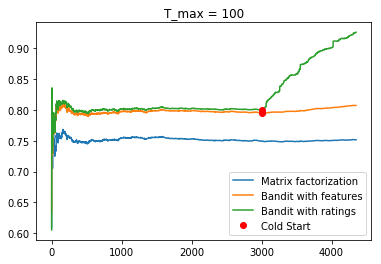

In [49]:
llvf,Llvf = loss_rmse(UlearnGR,VlearnGR,M)
llvm,Llvm = loss_rmse(UlearnGRM,VlearnGRM,M)
lpf,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])
lpm,_ = loss_rmse(UlearnGRM[3000:],VlearnGRM,M[3000:,:])
print("Original Loss :",lg)
print("Loss for learnt features (features version):",llvf)
print("Loss for learnt features for Users > 3000 (features version) :",lpf)
print("Loss for learnt features (ratings version):",llvm)
print("Loss for learnt features for Users > 3000 (ratigns version) :",lpm)

plt.plot(Lg,label="Matrix factorization")
plt.plot(Llvf,label="Bandit with features")
plt.plot(Llvm,label="Bandit with ratings")
plt.plot([3000],[Llvf[2999]],'o',color="red",label="Cold Start")
plt.plot([3000],[Llvm[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

Les résultats sont déjà un petit plus satisfaisant, même si la loss est toujours assez élévé pour les nouveaux éléments. Augmentons encore le nombre d'étapes ($T = 500$).

In [50]:
np.random.seed(0)
UlearnGR,VlearnGR = LinUCB_real(sub_gV,sub_gU,gV,gU,new_elems=7000,verbose=True,T_max=500,nb_sugg=5,big_step=2,proba=1/10)

np.random.seed(0)
UlearnGRM,VlearnGRM = MLinUCB_real(sub_gV,sub_gU,M,users_seen,movies_seen,new_elems=7000,verbose=True,T_max=500,nb_sugg=5,big_step=2,proba=1/10)

INIT...
0 . ADDING USER  3001
1 . ADDING USER  3002
2 . ADDING USER  3003
3 . ADDING USER  3004
4 . ADDING MOVIE  151
5 . ADDING USER  3005
6 . ADDING USER  3006
7 . ADDING USER  3007
8 . ADDING USER  3008
9 . ADDING USER  3009
10 . ADDING USER  3010
11 . ADDING USER  3011
12 . ADDING USER  3012
13 . ADDING USER  3013
14 . ADDING MOVIE  152
15 . ADDING USER  3014
16 . ADDING USER  3015
17 . ADDING USER  3016
18 . ADDING USER  3017
19 . ADDING USER  3018
20 . ADDING USER  3019
21 . ADDING USER  3020
22 . ADDING MOVIE  153
23 . ADDING USER  3021
24 . ADDING USER  3022
25 . ADDING USER  3023
26 . ADDING USER  3024
27 . ADDING USER  3025
28 . ADDING USER  3026
29 . ADDING USER  3027
30 . ADDING USER  3028
31 . ADDING USER  3029
32 . ADDING USER  3030
33 . ADDING USER  3031
34 . ADDING MOVIE  154
35 . ADDING USER  3032
36 . ADDING USER  3033
37 . ADDING MOVIE  155
38 . ADDING USER  3034
39 . ADDING USER  3035
40 . ADDING MOVIE  156
41 . ADDING USER  3036
42 . ADDING MOVIE  157
43 . ADDING U

346 . ADDING USER  3306
347 . ADDING USER  3307
348 . ADDING USER  3308
349 . ADDING USER  3309
350 . ADDING USER  3310
351 . ADDING USER  3311
352 . ADDING USER  3312
353 . ADDING USER  3313
354 . ADDING USER  3314
355 . ADDING USER  3315
356 . ADDING USER  3316
357 . ADDING USER  3317
358 . ADDING USER  3318
359 . ADDING USER  3319
360 . ADDING USER  3320
361 . ADDING USER  3321
362 . ADDING USER  3322
363 . ADDING USER  3323
364 . ADDING USER  3324
365 . ADDING USER  3325
366 . ADDING USER  3326
367 . ADDING USER  3327
368 . ADDING USER  3328
369 . ADDING USER  3329
370 . ADDING MOVIE  192
371 . ADDING USER  3330
372 . ADDING USER  3331
373 . ADDING USER  3332
374 . ADDING USER  3333
375 . ADDING USER  3334
376 . ADDING MOVIE  193
377 . ADDING USER  3335
378 . ADDING USER  3336
379 . ADDING USER  3337
380 . ADDING USER  3338
381 . ADDING USER  3339
382 . ADDING USER  3340
383 . ADDING USER  3341
384 . ADDING USER  3342
385 . ADDING USER  3343
386 . ADDING USER  3344
387 . ADDING USE

688 . ADDING USER  3632
689 . ADDING USER  3633
690 . ADDING USER  3634
691 . ADDING USER  3635
692 . ADDING USER  3636
693 . ADDING USER  3637
694 . ADDING USER  3638
695 . ADDING USER  3639
696 . ADDING USER  3640
697 . ADDING USER  3641
698 . ADDING USER  3642
699 . ADDING USER  3643
700 . ADDING USER  3644
701 . ADDING USER  3645
702 . ADDING USER  3646
703 . ADDING USER  3647
704 . ADDING USER  3648
705 . ADDING USER  3649
706 . ADDING USER  3650
707 . ADDING USER  3651
708 . ADDING USER  3652
709 . ADDING USER  3653
710 . ADDING USER  3654
711 . ADDING USER  3655
712 . ADDING USER  3656
713 . ADDING USER  3657
714 . ADDING USER  3658
715 . ADDING USER  3659
716 . ADDING USER  3660
717 . ADDING USER  3661
718 . ADDING USER  3662
719 . ADDING USER  3663
720 . ADDING USER  3664
721 . ADDING USER  3665
722 . ADDING USER  3666
723 . ADDING USER  3667
724 . ADDING USER  3668
725 . ADDING USER  3669
726 . ADDING USER  3670
727 . ADDING USER  3671
728 . ADDING USER  3672
729 . ADDING USE

1029 . ADDING USER  3973
1030 . ADDING USER  3974
1031 . ADDING USER  3975
1032 . ADDING USER  3976
1033 . ADDING USER  3977
1034 . ADDING USER  3978
1035 . ADDING USER  3979
1036 . ADDING USER  3980
1037 . ADDING USER  3981
1038 . ADDING USER  3982
1039 . ADDING USER  3983
1040 . ADDING USER  3984
1041 . ADDING USER  3985
1042 . ADDING USER  3986
1043 . ADDING USER  3987
1044 . ADDING USER  3988
1045 . ADDING USER  3989
1046 . ADDING USER  3990
1047 . ADDING USER  3991
1048 . ADDING USER  3992
1049 . ADDING USER  3993
1050 . ADDING USER  3994
1051 . ADDING USER  3995
1052 . ADDING USER  3996
1053 . ADDING USER  3997
1054 . ADDING USER  3998
1055 . ADDING USER  3999
1056 . ADDING USER  4000
1057 . ADDING USER  4001
1058 . ADDING USER  4002
1059 . ADDING USER  4003
1060 . ADDING USER  4004
1061 . ADDING USER  4005
1062 . ADDING USER  4006
1063 . ADDING USER  4007
1064 . ADDING USER  4008
1065 . ADDING USER  4009
1066 . ADDING USER  4010
1067 . ADDING USER  4011
1068 . ADDING USER  4012


1357 . ADDING USER  4301
1358 . ADDING USER  4302
1359 . ADDING USER  4303
1360 . ADDING USER  4304
1361 . ADDING USER  4305
1362 . ADDING USER  4306
1363 . ADDING USER  4307
1364 . ADDING USER  4308
1365 . ADDING USER  4309
1366 . ADDING USER  4310
1367 . ADDING USER  4311
1368 . ADDING USER  4312
1369 . ADDING USER  4313
1370 . ADDING USER  4314
1371 . ADDING USER  4315
1372 . ADDING USER  4316
1373 . ADDING USER  4317
1374 . ADDING USER  4318
1375 . ADDING USER  4319
1376 . ADDING USER  4320
1377 . ADDING USER  4321
1378 . ADDING USER  4322
1379 . ADDING USER  4323
1380 . ADDING USER  4324
1381 . ADDING USER  4325
1382 . ADDING USER  4326
1383 . ADDING USER  4327
1384 . ADDING USER  4328
1385 . ADDING USER  4329
1386 . ADDING USER  4330
1387 . ADDING USER  4331
1388 . ADDING USER  4332
1389 . ADDING USER  4333
1390 . ADDING USER  4334
1391 . ADDING USER  4335
1392 . ADDING USER  4336
1393 . ADDING USER  4337
1394 . ADDING USER  4338
1395 . ADDING USER  4339
1396 . ADDING USER  4340


193 . ADDING USER  3171
Have seen  59
194 . ADDING USER  3172
Have seen  69
195 . ADDING USER  3173
Have seen  45
196 . ADDING USER  3174
Have seen  21
197 . ADDING USER  3175
Have seen  15
198 . ADDING USER  3176
Have seen  32
199 . ADDING MOVIE  174
200 . ADDING USER  3177
Have seen  12
201 . ADDING USER  3178
Have seen  98
202 . ADDING USER  3179
Have seen  133
203 . ADDING USER  3180
Have seen  160
204 . ADDING USER  3181
Have seen  70
205 . ADDING USER  3182
Have seen  33
206 . ADDING USER  3183
Have seen  86
207 . ADDING USER  3184
Have seen  47
208 . ADDING USER  3185
Have seen  17
209 . ADDING USER  3186
Have seen  28
210 . ADDING USER  3187
Have seen  19
211 . ADDING USER  3188
Have seen  48
212 . ADDING USER  3189
Have seen  65
213 . ADDING USER  3190
Have seen  96
214 . ADDING USER  3191
Have seen  56
215 . ADDING USER  3192
Have seen  44
216 . ADDING USER  3193
Have seen  63
217 . ADDING USER  3194
Have seen  14
218 . ADDING MOVIE  175
219 . ADDING USER  3195
Have seen  35


416 . ADDING USER  3373
Have seen  17
417 . ADDING USER  3374
Have seen  149
418 . ADDING USER  3375
Have seen  21
419 . ADDING USER  3376
Have seen  50
420 . ADDING USER  3377
Have seen  20
421 . ADDING USER  3378
Have seen  19
422 . ADDING USER  3379
Have seen  21
423 . ADDING USER  3380
Have seen  148
424 . ADDING USER  3381
Have seen  66
425 . ADDING USER  3382
Have seen  20
426 . ADDING USER  3383
Have seen  153
427 . ADDING MOVIE  195
428 . ADDING USER  3384
Have seen  73
429 . ADDING USER  3385
Have seen  41
430 . ADDING USER  3386
Have seen  153
431 . ADDING USER  3387
Have seen  38
432 . ADDING USER  3388
Have seen  68
433 . ADDING USER  3389
Have seen  31
434 . ADDING USER  3390
Have seen  93
435 . ADDING USER  3391
Have seen  30
436 . ADDING USER  3392
Have seen  59
437 . ADDING USER  3393
Have seen  60
438 . ADDING USER  3394
Have seen  72
439 . ADDING USER  3395
Have seen  32
440 . ADDING USER  3396
Have seen  44
441 . ADDING MOVIE  196
442 . ADDING USER  3397
Have seen  4

637 . ADDING USER  3581
Have seen  32
638 . ADDING USER  3582
Have seen  35
639 . ADDING USER  3583
Have seen  130
640 . ADDING USER  3584
Have seen  46
641 . ADDING USER  3585
Have seen  110
642 . ADDING USER  3586
Have seen  24
643 . ADDING USER  3587
Have seen  104
644 . ADDING USER  3588
Have seen  75
645 . ADDING USER  3589
Have seen  34
646 . ADDING USER  3590
Have seen  137
647 . ADDING USER  3591
Have seen  31
648 . ADDING USER  3592
Have seen  58
649 . ADDING USER  3593
Have seen  156
650 . ADDING USER  3594
Have seen  25
651 . ADDING USER  3595
Have seen  24
652 . ADDING USER  3596
Have seen  68
653 . ADDING USER  3597
Have seen  86
654 . ADDING USER  3598
Have seen  36
655 . ADDING USER  3599
Have seen  64
656 . ADDING USER  3600
Have seen  20
657 . ADDING USER  3601
Have seen  23
658 . ADDING USER  3602
Have seen  22
659 . ADDING USER  3603
Have seen  46
660 . ADDING USER  3604
Have seen  179
661 . ADDING USER  3605
Have seen  61
662 . ADDING USER  3606
Have seen  27
663 . 

852 . ADDING USER  3796
Have seen  66
853 . ADDING USER  3797
Have seen  40
854 . ADDING USER  3798
Have seen  20
855 . ADDING USER  3799
Have seen  83
856 . ADDING USER  3800
Have seen  154
857 . ADDING USER  3801
Have seen  27
858 . ADDING USER  3802
Have seen  24
859 . ADDING USER  3803
Have seen  179
860 . ADDING USER  3804
Have seen  20
861 . ADDING USER  3805
Have seen  126
862 . ADDING USER  3806
Have seen  53
863 . ADDING USER  3807
Have seen  113
864 . ADDING USER  3808
Have seen  106
865 . ADDING USER  3809
Have seen  43
866 . ADDING USER  3810
Have seen  79
867 . ADDING USER  3811
Have seen  72
868 . ADDING USER  3812
Have seen  22
869 . ADDING USER  3813
Have seen  44
870 . ADDING USER  3814
Have seen  62
871 . ADDING USER  3815
Have seen  129
872 . ADDING USER  3816
Have seen  21
873 . ADDING USER  3817
Have seen  45
874 . ADDING USER  3818
Have seen  35
875 . ADDING USER  3819
Have seen  151
876 . ADDING USER  3820
Have seen  67
877 . ADDING USER  3821
Have seen  59
878 .

1066 . ADDING USER  4010
Have seen  21
1067 . ADDING USER  4011
Have seen  68
1068 . ADDING USER  4012
Have seen  91
1069 . ADDING USER  4013
Have seen  44
1070 . ADDING USER  4014
Have seen  79
1071 . ADDING USER  4015
Have seen  85
1072 . ADDING USER  4016
Have seen  28
1073 . ADDING USER  4017
Have seen  74
1074 . ADDING USER  4018
Have seen  49
1075 . ADDING USER  4019
Have seen  76
1076 . ADDING USER  4020
Have seen  49
1077 . ADDING USER  4021
Have seen  44
1078 . ADDING USER  4022
Have seen  48
1079 . ADDING USER  4023
Have seen  70
1080 . ADDING USER  4024
Have seen  141
1081 . ADDING USER  4025
Have seen  48
1082 . ADDING USER  4026
Have seen  20
1083 . ADDING USER  4027
Have seen  21
1084 . ADDING USER  4028
Have seen  41
1085 . ADDING USER  4029
Have seen  177
1086 . ADDING USER  4030
Have seen  113
1087 . ADDING USER  4031
Have seen  55
1088 . ADDING USER  4032
Have seen  49
1089 . ADDING USER  4033
Have seen  54
1090 . ADDING USER  4034
Have seen  30
1091 . ADDING USER  40

1275 . ADDING USER  4219
Have seen  22
1276 . ADDING USER  4220
Have seen  44
1277 . ADDING USER  4221
Have seen  26
1278 . ADDING USER  4222
Have seen  46
1279 . ADDING USER  4223
Have seen  25
1280 . ADDING USER  4224
Have seen  42
1281 . ADDING USER  4225
Have seen  87
1282 . ADDING USER  4226
Have seen  23
1283 . ADDING USER  4227
Have seen  113
1284 . ADDING USER  4228
Have seen  69
1285 . ADDING USER  4229
Have seen  110
1286 . ADDING USER  4230
Have seen  31
1287 . ADDING USER  4231
Have seen  165
1288 . ADDING USER  4232
Have seen  63
1289 . ADDING USER  4233
Have seen  31
1290 . ADDING USER  4234
Have seen  47
1291 . ADDING USER  4235
Have seen  52
1292 . ADDING USER  4236
Have seen  154
1293 . ADDING USER  4237
Have seen  39
1294 . ADDING USER  4238
Have seen  129
1295 . ADDING USER  4239
Have seen  52
1296 . ADDING USER  4240
Have seen  111
1297 . ADDING USER  4241
Have seen  49
1298 . ADDING USER  4242
Have seen  34
1299 . ADDING USER  4243
Have seen  40
1300 . ADDING USER 

Original Loss : 0.7516576806244263
Loss for learnt features (features version): 0.7997091742404955
Loss for learnt features for Users > 3000 (features version) : 0.8295611374306068
Loss for learnt features (ratings version): 0.8631827002412977
Loss for learnt features for Users > 3000 (ratigns version) : 1.021878787502098


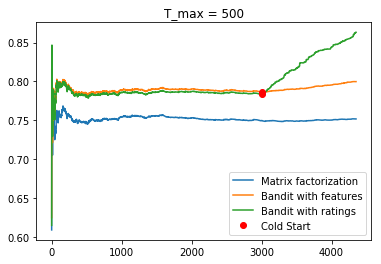

In [51]:
llvf,Llvf = loss_rmse(UlearnGR,VlearnGR,M)
llvm,Llvm = loss_rmse(UlearnGRM,VlearnGRM,M)
lpf,_ = loss_rmse(UlearnGR[3000:],VlearnGR,M[3000:,:])
lpm,_ = loss_rmse(UlearnGRM[3000:],VlearnGRM,M[3000:,:])
print("Original Loss :",lg)
print("Loss for learnt features (features version):",llvf)
print("Loss for learnt features for Users > 3000 (features version) :",lpf)
print("Loss for learnt features (ratings version):",llvm)
print("Loss for learnt features for Users > 3000 (ratigns version) :",lpm)

plt.plot(Lg,label="Matrix factorization")
plt.plot(Llvf,label="Bandit with features")
plt.plot(Llvm,label="Bandit with ratings")
plt.plot([3000],[Llvf[2999]],'o',color="red",label="Cold Start")
plt.plot([3000],[Llvm[2999]],'o',color="red")
plt.title("T_max = 500")
plt.legend()
plt.show()

Cette fois-ci, la loss RMSE est plus satisfaisante, même pour les éléments rajoutés dans le tableaux. Cependant, nous sommes encore loin de notre modèle réaliste :

* Il nous a fallu 500 étapes, soit 500 suggestions de film par utilisateurs, pour apprendre plutot correctement les features des utilisateurs pour avoir une loss RMSE assez faible.
* Les ensemble de Test et de Train sont le même, il est donc fort probable que l'ont ai de l'overfitting.

On constate cependant que les résultats resent très satisfaisants pour la version de l'algorithme utilisant les features totales $U_{complete}$ et $V_{complete}$ pour les rewwards.

# F. Que devient la loss si l'on sépare Train et Test ?

Pour le moment, on obtient une RMSE correcte ($< 1$) mais les données de validation sont aussi celles d'entrainement. Il y a donc fort à parier que l'on overfit grandement sur les données de test. Voyons ce que cela donne si l'on sépare les ratings en deux matrices : Test et Train.

In [52]:
## Separation en 2 matrices : Train et Test
def splitTrainValSets(ratings, nGrades=10):
        """
        Split the observed data (nonzero entries) into a training set
        and a validation set by removing 10 grades per user and assigning them
        to the validation set
        """
        valMatrix = np.zeros(ratings.shape)
        trainMatrix = ratings.copy()
        for i in range(ratings.shape[0]):
            valRatingsIds = np.random.choice(ratings[i, :].nonzero()[0],
                                             size=min(nGrades,len(ratings[i,:].nonzero()[0])//2),
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = ratings[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        return trainMatrix, valMatrix
    
    
M_train, M_test = splitTrainValSets(M,nGrades=5)

On récupère les features avec l'algorithme du projet 2 uniquement sur la **Matrice de Train**

In [53]:
mftrain = MatrixFactorization(M_train[:3000,:150],maxIter=20)
gUtrain,gVtrain,h = mftrain.stochasticGradientDescent(0)


Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


In [54]:
loss_train,_ = loss_rmse(gUtrain,gVtrain,M_train[:3000,:150])
loss_test,_ = loss_rmse(gUtrain,gVtrain,M_test[:3000,:150])
print("RMSE train :",loss_train)
print("RMSE test :",loss_test)

RMSE train : 0.7334949288357052
RMSE test : 0.8963650410010616


In [55]:
mftrain_complete = MatrixFactorization(M_train,maxIter=20)
gUtrain_complete,gVtrain_complete,h = mftrain_complete.stochasticGradientDescent(0)


Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


In [56]:
loss_train,_ = loss_rmse(gUtrain_complete,gVtrain_complete,M_train)
loss_test,_ = loss_rmse(gUtrain_complete,gVtrain_complete,M_test)
print("RMSE train :",loss_train)
print("RMSE test :",loss_test)

RMSE train : 0.7534733440960424
RMSE test : 0.9104026852183451


## F.1 Version avec notes supposées

Nous testons d'abord la version de l'algorithme qui utilise les features de la matrice entière (mais uniquement de la matrice de train) pour calculer le reward.

In [57]:
np.random.seed(0)
lfU_train,lfV_train = LinUCB_real(gVtrain,gUtrain,gVtrain_complete,gUtrain_complete,new_elems=7000,verbose=True,T_max=100,nb_sugg=5,big_step=2,proba=1/10)

INIT...
0 . ADDING USER  3001
1 . ADDING MOVIE  151
2 . ADDING USER  3002
3 . ADDING USER  3003
4 . ADDING USER  3004
5 . ADDING USER  3005
6 . ADDING USER  3006
7 . ADDING USER  3007
8 . ADDING USER  3008
9 . ADDING USER  3009
10 . ADDING USER  3010
11 . ADDING USER  3011
12 . ADDING USER  3012
13 . ADDING USER  3013
14 . ADDING MOVIE  152
15 . ADDING USER  3014
16 . ADDING USER  3015
17 . ADDING USER  3016
18 . ADDING USER  3017
19 . ADDING MOVIE  153
20 . ADDING USER  3018
21 . ADDING USER  3019
22 . ADDING USER  3020
23 . ADDING USER  3021
24 . ADDING USER  3022
25 . ADDING USER  3023
26 . ADDING USER  3024
27 . ADDING USER  3025
28 . ADDING USER  3026
29 . ADDING MOVIE  154
30 . ADDING USER  3027
31 . ADDING USER  3028
32 . ADDING USER  3029
33 . ADDING USER  3030
34 . ADDING MOVIE  155
35 . ADDING USER  3031
36 . ADDING USER  3032
37 . ADDING USER  3033
38 . ADDING USER  3034
39 . ADDING USER  3035
40 . ADDING MOVIE  156
41 . ADDING USER  3036
42 . ADDING USER  3037
43 . ADDING U

346 . ADDING USER  3315
347 . ADDING USER  3316
348 . ADDING USER  3317
349 . ADDING USER  3318
350 . ADDING USER  3319
351 . ADDING USER  3320
352 . ADDING USER  3321
353 . ADDING USER  3322
354 . ADDING MOVIE  183
355 . ADDING USER  3323
356 . ADDING USER  3324
357 . ADDING USER  3325
358 . ADDING USER  3326
359 . ADDING USER  3327
360 . ADDING USER  3328
361 . ADDING USER  3329
362 . ADDING USER  3330
363 . ADDING USER  3331
364 . ADDING USER  3332
365 . ADDING USER  3333
366 . ADDING USER  3334
367 . ADDING USER  3335
368 . ADDING MOVIE  184
369 . ADDING USER  3336
370 . ADDING USER  3337
371 . ADDING USER  3338
372 . ADDING USER  3339
373 . ADDING USER  3340
374 . ADDING USER  3341
375 . ADDING USER  3342
376 . ADDING USER  3343
377 . ADDING USER  3344
378 . ADDING USER  3345
379 . ADDING USER  3346
380 . ADDING USER  3347
381 . ADDING USER  3348
382 . ADDING USER  3349
383 . ADDING USER  3350
384 . ADDING USER  3351
385 . ADDING MOVIE  185
386 . ADDING USER  3352
387 . ADDING USE

689 . ADDING USER  3633
690 . ADDING USER  3634
691 . ADDING USER  3635
692 . ADDING USER  3636
693 . ADDING USER  3637
694 . ADDING USER  3638
695 . ADDING USER  3639
696 . ADDING USER  3640
697 . ADDING USER  3641
698 . ADDING USER  3642
699 . ADDING USER  3643
700 . ADDING USER  3644
701 . ADDING USER  3645
702 . ADDING USER  3646
703 . ADDING USER  3647
704 . ADDING USER  3648
705 . ADDING USER  3649
706 . ADDING USER  3650
707 . ADDING USER  3651
708 . ADDING USER  3652
709 . ADDING USER  3653
710 . ADDING USER  3654
711 . ADDING USER  3655
712 . ADDING USER  3656
713 . ADDING USER  3657
714 . ADDING USER  3658
715 . ADDING USER  3659
716 . ADDING USER  3660
717 . ADDING USER  3661
718 . ADDING USER  3662
719 . ADDING USER  3663
720 . ADDING USER  3664
721 . ADDING USER  3665
722 . ADDING USER  3666
723 . ADDING USER  3667
724 . ADDING USER  3668
725 . ADDING USER  3669
726 . ADDING USER  3670
727 . ADDING USER  3671
728 . ADDING USER  3672
729 . ADDING USER  3673
730 . ADDING USE

1031 . ADDING USER  3975
1032 . ADDING USER  3976
1033 . ADDING USER  3977
1034 . ADDING USER  3978
1035 . ADDING USER  3979
1036 . ADDING USER  3980
1037 . ADDING USER  3981
1038 . ADDING USER  3982
1039 . ADDING USER  3983
1040 . ADDING USER  3984
1041 . ADDING USER  3985
1042 . ADDING USER  3986
1043 . ADDING USER  3987
1044 . ADDING USER  3988
1045 . ADDING USER  3989
1046 . ADDING USER  3990
1047 . ADDING USER  3991
1048 . ADDING USER  3992
1049 . ADDING USER  3993
1050 . ADDING USER  3994
1051 . ADDING USER  3995
1052 . ADDING USER  3996
1053 . ADDING USER  3997
1054 . ADDING USER  3998
1055 . ADDING USER  3999
1056 . ADDING USER  4000
1057 . ADDING USER  4001
1058 . ADDING USER  4002
1059 . ADDING USER  4003
1060 . ADDING USER  4004
1061 . ADDING USER  4005
1062 . ADDING USER  4006
1063 . ADDING USER  4007
1064 . ADDING USER  4008
1065 . ADDING USER  4009
1066 . ADDING USER  4010
1067 . ADDING USER  4011
1068 . ADDING USER  4012
1069 . ADDING USER  4013
1070 . ADDING USER  4014


1359 . ADDING USER  4303
1360 . ADDING USER  4304
1361 . ADDING USER  4305
1362 . ADDING USER  4306
1363 . ADDING USER  4307
1364 . ADDING USER  4308
1365 . ADDING USER  4309
1366 . ADDING USER  4310
1367 . ADDING USER  4311
1368 . ADDING USER  4312
1369 . ADDING USER  4313
1370 . ADDING USER  4314
1371 . ADDING USER  4315
1372 . ADDING USER  4316
1373 . ADDING USER  4317
1374 . ADDING USER  4318
1375 . ADDING USER  4319
1376 . ADDING USER  4320
1377 . ADDING USER  4321
1378 . ADDING USER  4322
1379 . ADDING USER  4323
1380 . ADDING USER  4324
1381 . ADDING USER  4325
1382 . ADDING USER  4326
1383 . ADDING USER  4327
1384 . ADDING USER  4328
1385 . ADDING USER  4329
1386 . ADDING USER  4330
1387 . ADDING USER  4331
1388 . ADDING USER  4332
1389 . ADDING USER  4333
1390 . ADDING USER  4334
1391 . ADDING USER  4335
1392 . ADDING USER  4336
1393 . ADDING USER  4337
1394 . ADDING USER  4338
1395 . ADDING USER  4339
1396 . ADDING USER  4340
1397 . ADDING USER  4341
1398 . ADDING USER  4342


RMSE train : 0.8216672141024606
RMSE test : 0.9318942859401932
RMSE train (U_i > 3000) : 0.8441396546588913
RMSE test (U_i > 3000) : 0.9282848614123267


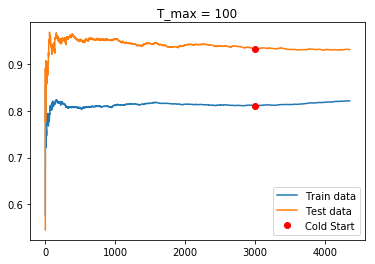

In [58]:
loss_train,L_train = loss_rmse(lfU_train,lfV_train,M_train)
loss_test,L_test = loss_rmse(lfU_train,lfV_train,M_test)
print("RMSE train :",loss_train)
print("RMSE test :",loss_test)
loss_train,_ = loss_rmse(lfU_train[3000:],lfV_train,M_train[3000:,:])
loss_test,_ = loss_rmse(lfU_train[3000:],lfV_train,M_test[3000:,:])
print("RMSE train (U_i > 3000) :",loss_train)
print("RMSE test (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Train data")
plt.plot(L_test,label="Test data")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Cold Start")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

Ainsi, grâce à cette méthode, la RMSE augmente un peu, notamment pour l'ensemble de Test, mais elle reste bonne malgrès tout !

## F.2 Version avec vraies notes

Dans cette section, nous tentons d'entrainer notre algorithme uniquement avec les vrais ratings donnés par l'utilisateur. Cette version de l'algorithme a montré de bien moins bon résultats dans la partie E. Cependant, elle nous semble plus réaliste, c'est pourquoi nous la présentons tout de même.

In [59]:
users_seen_train,movies_seen_train = what_is_seen(M_train)

Essayons d'abord l'algorithme avec $T_{max} = 100$

In [60]:
np.random.seed(0)
lUtrain,lVtrain = MLinUCB_real(gVtrain,gUtrain,M_train,users_seen_train,movies_seen_train,new_elems=7000,verbose=True,T_max=100,nb_sugg=5,big_step=2,proba=1/10)


INIT...
0 . ADDING USER  3001
Have seen  70
1 . ADDING MOVIE  151
2 . ADDING USER  3002
Have seen  115
3 . ADDING USER  3003
Have seen  31
4 . ADDING USER  3004
Have seen  76
5 . ADDING USER  3005
Have seen  34
6 . ADDING USER  3006
Have seen  19
7 . ADDING USER  3007
Have seen  15
8 . ADDING USER  3008
Have seen  42
9 . ADDING USER  3009
Have seen  77
10 . ADDING USER  3010
Have seen  8
11 . ADDING USER  3011
Have seen  14
12 . ADDING USER  3012
Have seen  34
13 . ADDING USER  3013
Have seen  27
14 . ADDING MOVIE  152
15 . ADDING USER  3014
Have seen  22
16 . ADDING USER  3015
Have seen  84
17 . ADDING USER  3016
Have seen  77
18 . ADDING USER  3017
Have seen  94
19 . ADDING MOVIE  153
20 . ADDING USER  3018
Have seen  26
21 . ADDING USER  3019
Have seen  28
22 . ADDING USER  3020
Have seen  57
23 . ADDING USER  3021
Have seen  16
24 . ADDING USER  3022
Have seen  28
25 . ADDING USER  3023
Have seen  42
26 . ADDING USER  3024
Have seen  50
27 . ADDING USER  3025
Have seen  21
28 . ADD

228 . ADDING USER  3208
Have seen  23
229 . ADDING USER  3209
Have seen  126
230 . ADDING USER  3210
Have seen  32
231 . ADDING USER  3211
Have seen  55
232 . ADDING MOVIE  172
233 . ADDING USER  3212
Have seen  33
234 . ADDING USER  3213
Have seen  15
235 . ADDING USER  3214
Have seen  66
236 . ADDING USER  3215
Have seen  113
237 . ADDING USER  3216
Have seen  83
238 . ADDING USER  3217
Have seen  41
239 . ADDING USER  3218
Have seen  34
240 . ADDING USER  3219
Have seen  33
241 . ADDING USER  3220
Have seen  67
242 . ADDING USER  3221
Have seen  36
243 . ADDING MOVIE  173
244 . ADDING USER  3222
Have seen  40
245 . ADDING USER  3223
Have seen  33
246 . ADDING MOVIE  174
247 . ADDING USER  3224
Have seen  76
248 . ADDING MOVIE  175
249 . ADDING USER  3225
Have seen  64
250 . ADDING USER  3226
Have seen  96
251 . ADDING USER  3227
Have seen  76
252 . ADDING USER  3228
Have seen  146
253 . ADDING USER  3229
Have seen  96
254 . ADDING USER  3230
Have seen  148
255 . ADDING USER  3231
Ha

Have seen  39
450 . ADDING USER  3414
Have seen  56
451 . ADDING MOVIE  188
452 . ADDING USER  3415
Have seen  15
453 . ADDING USER  3416
Have seen  53
454 . ADDING USER  3417
Have seen  36
455 . ADDING USER  3418
Have seen  19
456 . ADDING MOVIE  189
457 . ADDING USER  3419
Have seen  37
458 . ADDING USER  3420
Have seen  21
459 . ADDING MOVIE  190
460 . ADDING USER  3421
Have seen  94
461 . ADDING USER  3422
Have seen  70
462 . ADDING USER  3423
Have seen  120
463 . ADDING USER  3424
Have seen  69
464 . ADDING USER  3425
Have seen  69
465 . ADDING USER  3426
Have seen  76
466 . ADDING USER  3427
Have seen  65
467 . ADDING USER  3428
Have seen  42
468 . ADDING MOVIE  191
469 . ADDING USER  3429
Have seen  46
470 . ADDING USER  3430
Have seen  37
471 . ADDING USER  3431
Have seen  92
472 . ADDING USER  3432
Have seen  37
473 . ADDING USER  3433
Have seen  25
474 . ADDING USER  3434
Have seen  90
475 . ADDING USER  3435
Have seen  50
476 . ADDING USER  3436
Have seen  135
477 . ADDING U

673 . ADDING USER  3617
Have seen  172
674 . ADDING USER  3618
Have seen  98
675 . ADDING USER  3619
Have seen  23
676 . ADDING USER  3620
Have seen  78
677 . ADDING USER  3621
Have seen  28
678 . ADDING USER  3622
Have seen  86
679 . ADDING USER  3623
Have seen  163
680 . ADDING USER  3624
Have seen  72
681 . ADDING USER  3625
Have seen  35
682 . ADDING USER  3626
Have seen  27
683 . ADDING USER  3627
Have seen  26
684 . ADDING USER  3628
Have seen  58
685 . ADDING USER  3629
Have seen  29
686 . ADDING USER  3630
Have seen  40
687 . ADDING USER  3631
Have seen  91
688 . ADDING USER  3632
Have seen  136
689 . ADDING USER  3633
Have seen  38
690 . ADDING USER  3634
Have seen  32
691 . ADDING USER  3635
Have seen  161
692 . ADDING USER  3636
Have seen  22
693 . ADDING USER  3637
Have seen  38
694 . ADDING USER  3638
Have seen  98
695 . ADDING USER  3639
Have seen  27
696 . ADDING USER  3640
Have seen  26
697 . ADDING USER  3641
Have seen  33
698 . ADDING USER  3642
Have seen  51
699 . AD

890 . ADDING USER  3834
Have seen  53
891 . ADDING USER  3835
Have seen  18
892 . ADDING USER  3836
Have seen  72
893 . ADDING USER  3837
Have seen  15
894 . ADDING USER  3838
Have seen  155
895 . ADDING USER  3839
Have seen  51
896 . ADDING USER  3840
Have seen  35
897 . ADDING USER  3841
Have seen  113
898 . ADDING USER  3842
Have seen  67
899 . ADDING USER  3843
Have seen  57
900 . ADDING USER  3844
Have seen  198
901 . ADDING USER  3845
Have seen  43
902 . ADDING USER  3846
Have seen  86
903 . ADDING USER  3847
Have seen  108
904 . ADDING USER  3848
Have seen  15
905 . ADDING USER  3849
Have seen  97
906 . ADDING USER  3850
Have seen  21
907 . ADDING USER  3851
Have seen  21
908 . ADDING USER  3852
Have seen  29
909 . ADDING USER  3853
Have seen  27
910 . ADDING USER  3854
Have seen  52
911 . ADDING USER  3855
Have seen  160
912 . ADDING USER  3856
Have seen  52
913 . ADDING USER  3857
Have seen  82
914 . ADDING USER  3858
Have seen  36
915 . ADDING USER  3859
Have seen  166
916 . 

1104 . ADDING USER  4048
Have seen  76
1105 . ADDING USER  4049
Have seen  175
1106 . ADDING USER  4050
Have seen  19
1107 . ADDING USER  4051
Have seen  22
1108 . ADDING USER  4052
Have seen  34
1109 . ADDING USER  4053
Have seen  182
1110 . ADDING USER  4054
Have seen  27
1111 . ADDING USER  4055
Have seen  103
1112 . ADDING USER  4056
Have seen  53
1113 . ADDING USER  4057
Have seen  73
1114 . ADDING USER  4058
Have seen  62
1115 . ADDING USER  4059
Have seen  62
1116 . ADDING USER  4060
Have seen  86
1117 . ADDING USER  4061
Have seen  21
1118 . ADDING USER  4062
Have seen  72
1119 . ADDING USER  4063
Have seen  115
1120 . ADDING USER  4064
Have seen  38
1121 . ADDING USER  4065
Have seen  75
1122 . ADDING USER  4066
Have seen  22
1123 . ADDING USER  4067
Have seen  67
1124 . ADDING USER  4068
Have seen  49
1125 . ADDING USER  4069
Have seen  23
1126 . ADDING USER  4070
Have seen  89
1127 . ADDING USER  4071
Have seen  109
1128 . ADDING USER  4072
Have seen  27
1129 . ADDING USER  

1317 . ADDING USER  4261
Have seen  15
1318 . ADDING USER  4262
Have seen  48
1319 . ADDING USER  4263
Have seen  70
1320 . ADDING USER  4264
Have seen  30
1321 . ADDING USER  4265
Have seen  43
1322 . ADDING USER  4266
Have seen  36
1323 . ADDING USER  4267
Have seen  53
1324 . ADDING USER  4268
Have seen  24
1325 . ADDING USER  4269
Have seen  47
1326 . ADDING USER  4270
Have seen  54
1327 . ADDING USER  4271
Have seen  50
1328 . ADDING USER  4272
Have seen  62
1329 . ADDING USER  4273
Have seen  16
1330 . ADDING USER  4274
Have seen  22
1331 . ADDING USER  4275
Have seen  31
1332 . ADDING USER  4276
Have seen  66
1333 . ADDING USER  4277
Have seen  55
1334 . ADDING USER  4278
Have seen  128
1335 . ADDING USER  4279
Have seen  38
1336 . ADDING USER  4280
Have seen  42
1337 . ADDING USER  4281
Have seen  40
1338 . ADDING USER  4282
Have seen  152
1339 . ADDING USER  4283
Have seen  108
1340 . ADDING USER  4284
Have seen  106
1341 . ADDING USER  4285
Have seen  75
1342 . ADDING USER  4

RMSE train : 0.8754769829203753
RMSE test : 1.1110173559624548
RMSE train (U_i > 3000) : 1.0371336545003087
RMSE test (U_i > 3000) : 1.4521009171597352


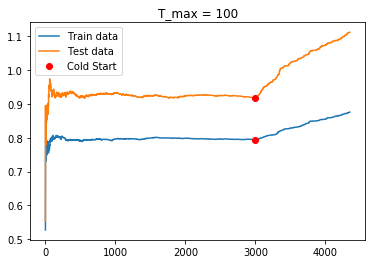

In [61]:
loss_train,L_train = loss_rmse(lUtrain,lVtrain,M_train)
loss_test,L_test = loss_rmse(lUtrain,lVtrain,M_test)
print("RMSE train :",loss_train)
print("RMSE test :",loss_test)
loss_train,_ = loss_rmse(lUtrain[3000:],lVtrain,M_train[3000:,:])
loss_test,_ = loss_rmse(lUtrain[3000:],lVtrain,M_test[3000:,:])
print("RMSE train (U_i > 3000) :",loss_train)
print("RMSE test (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Train data")
plt.plot(L_test,label="Test data")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Cold Start")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

Comme on pouvait s'y attendre, la loss augmente grandement pour les nouveaux éléments, et encore plus pour l'ensemble de test puisque l'on obtient plus de $1.45$ de loss. Regardons si ces résultats s'améliorent avec un plus grand nombre d'étape ($T_{max} = 500$)

In [62]:
np.random.seed(0)
lUtrain,lVtrain = MLinUCB_real(gVtrain,gUtrain,M_train,users_seen_train,movies_seen_train,new_elems=7000,verbose=True,T_max=500,nb_sugg=5,big_step=4,proba=1/10)

INIT...
0 . ADDING USER  3001
Have seen  70
1 . ADDING USER  3002
Have seen  114
2 . ADDING USER  3003
Have seen  31
3 . ADDING USER  3004
Have seen  75
4 . ADDING MOVIE  151
5 . ADDING USER  3005
Have seen  34
6 . ADDING USER  3006
Have seen  19
7 . ADDING USER  3007
Have seen  15
8 . ADDING USER  3008
Have seen  42
9 . ADDING USER  3009
Have seen  77
10 . ADDING USER  3010
Have seen  8
11 . ADDING USER  3011
Have seen  14
12 . ADDING USER  3012
Have seen  34
13 . ADDING USER  3013
Have seen  27
14 . ADDING MOVIE  152
15 . ADDING USER  3014
Have seen  22
16 . ADDING USER  3015
Have seen  84
17 . ADDING USER  3016
Have seen  77
18 . ADDING USER  3017
Have seen  94
19 . ADDING USER  3018
Have seen  25
20 . ADDING USER  3019
Have seen  27
21 . ADDING USER  3020
Have seen  57
22 . ADDING MOVIE  153
23 . ADDING USER  3021
Have seen  16
24 . ADDING USER  3022
Have seen  28
25 . ADDING USER  3023
Have seen  42
26 . ADDING USER  3024
Have seen  50
27 . ADDING USER  3025
Have seen  21
28 . ADD

228 . ADDING USER  3203
Have seen  43
229 . ADDING USER  3204
Have seen  44
230 . ADDING USER  3205
Have seen  114
231 . ADDING USER  3206
Have seen  20
232 . ADDING USER  3207
Have seen  107
233 . ADDING USER  3208
Have seen  23
234 . ADDING USER  3209
Have seen  129
235 . ADDING USER  3210
Have seen  34
236 . ADDING MOVIE  177
237 . ADDING USER  3211
Have seen  57
238 . ADDING USER  3212
Have seen  35
239 . ADDING USER  3213
Have seen  16
240 . ADDING USER  3214
Have seen  67
241 . ADDING USER  3215
Have seen  117
242 . ADDING USER  3216
Have seen  87
243 . ADDING USER  3217
Have seen  42
244 . ADDING MOVIE  178
245 . ADDING USER  3218
Have seen  35
246 . ADDING USER  3219
Have seen  36
247 . ADDING USER  3220
Have seen  70
248 . ADDING USER  3221
Have seen  38
249 . ADDING USER  3222
Have seen  41
250 . ADDING USER  3223
Have seen  33
251 . ADDING USER  3224
Have seen  77
252 . ADDING USER  3225
Have seen  65
253 . ADDING USER  3226
Have seen  98
254 . ADDING USER  3227
Have seen  7

453 . ADDING USER  3407
Have seen  14
454 . ADDING MOVIE  198
455 . ADDING USER  3408
Have seen  74
456 . ADDING USER  3409
Have seen  24
457 . ADDING USER  3410
Have seen  19
458 . ADDING USER  3411
Have seen  103
459 . ADDING USER  3412
Have seen  29
460 . ADDING USER  3413
Have seen  42
461 . ADDING USER  3414
Have seen  59
462 . ADDING USER  3415
Have seen  15
463 . ADDING USER  3416
Have seen  53
464 . ADDING USER  3417
Have seen  36
465 . ADDING USER  3418
Have seen  20
466 . ADDING MOVIE  199
467 . ADDING USER  3419
Have seen  39
468 . ADDING USER  3420
Have seen  21
469 . ADDING MOVIE  200
470 . ADDING USER  3421
Have seen  98
471 . ADDING USER  3422
Have seen  71
472 . ADDING USER  3423
Have seen  124
473 . ADDING MOVIE  201
474 . ADDING USER  3424
Have seen  74
475 . ADDING USER  3425
Have seen  70
476 . ADDING USER  3426
Have seen  82
477 . ADDING USER  3427
Have seen  65
478 . ADDING USER  3428
Have seen  44
479 . ADDING USER  3429
Have seen  46
480 . ADDING MOVIE  202
481 

672 . ADDING USER  3616
Have seen  42
673 . ADDING USER  3617
Have seen  172
674 . ADDING USER  3618
Have seen  98
675 . ADDING USER  3619
Have seen  23
676 . ADDING USER  3620
Have seen  78
677 . ADDING USER  3621
Have seen  28
678 . ADDING USER  3622
Have seen  86
679 . ADDING USER  3623
Have seen  163
680 . ADDING USER  3624
Have seen  72
681 . ADDING USER  3625
Have seen  35
682 . ADDING USER  3626
Have seen  27
683 . ADDING USER  3627
Have seen  26
684 . ADDING USER  3628
Have seen  58
685 . ADDING USER  3629
Have seen  29
686 . ADDING USER  3630
Have seen  40
687 . ADDING USER  3631
Have seen  91
688 . ADDING USER  3632
Have seen  136
689 . ADDING USER  3633
Have seen  38
690 . ADDING USER  3634
Have seen  32
691 . ADDING USER  3635
Have seen  161
692 . ADDING USER  3636
Have seen  22
693 . ADDING USER  3637
Have seen  38
694 . ADDING USER  3638
Have seen  98
695 . ADDING USER  3639
Have seen  27
696 . ADDING USER  3640
Have seen  26
697 . ADDING USER  3641
Have seen  33
698 . AD

888 . ADDING USER  3832
Have seen  80
889 . ADDING USER  3833
Have seen  57
890 . ADDING USER  3834
Have seen  53
891 . ADDING USER  3835
Have seen  18
892 . ADDING USER  3836
Have seen  72
893 . ADDING USER  3837
Have seen  15
894 . ADDING USER  3838
Have seen  155
895 . ADDING USER  3839
Have seen  51
896 . ADDING USER  3840
Have seen  35
897 . ADDING USER  3841
Have seen  113
898 . ADDING USER  3842
Have seen  67
899 . ADDING USER  3843
Have seen  57
900 . ADDING USER  3844
Have seen  198
901 . ADDING USER  3845
Have seen  43
902 . ADDING USER  3846
Have seen  86
903 . ADDING USER  3847
Have seen  108
904 . ADDING USER  3848
Have seen  15
905 . ADDING USER  3849
Have seen  97
906 . ADDING USER  3850
Have seen  21
907 . ADDING USER  3851
Have seen  21
908 . ADDING USER  3852
Have seen  29
909 . ADDING USER  3853
Have seen  27
910 . ADDING USER  3854
Have seen  52
911 . ADDING USER  3855
Have seen  160
912 . ADDING USER  3856
Have seen  52
913 . ADDING USER  3857
Have seen  82
914 . A

1101 . ADDING USER  4045
Have seen  29
1102 . ADDING USER  4046
Have seen  25
1103 . ADDING USER  4047
Have seen  26
1104 . ADDING USER  4048
Have seen  76
1105 . ADDING USER  4049
Have seen  175
1106 . ADDING USER  4050
Have seen  19
1107 . ADDING USER  4051
Have seen  22
1108 . ADDING USER  4052
Have seen  34
1109 . ADDING USER  4053
Have seen  182
1110 . ADDING USER  4054
Have seen  27
1111 . ADDING USER  4055
Have seen  103
1112 . ADDING USER  4056
Have seen  53
1113 . ADDING USER  4057
Have seen  73
1114 . ADDING USER  4058
Have seen  62
1115 . ADDING USER  4059
Have seen  62
1116 . ADDING USER  4060
Have seen  86
1117 . ADDING USER  4061
Have seen  21
1118 . ADDING USER  4062
Have seen  72
1119 . ADDING USER  4063
Have seen  115
1120 . ADDING USER  4064
Have seen  38
1121 . ADDING USER  4065
Have seen  75
1122 . ADDING USER  4066
Have seen  22
1123 . ADDING USER  4067
Have seen  67
1124 . ADDING USER  4068
Have seen  49
1125 . ADDING USER  4069
Have seen  23
1126 . ADDING USER  4

1311 . ADDING USER  4255
Have seen  105
1312 . ADDING USER  4256
Have seen  137
1313 . ADDING USER  4257
Have seen  93
1314 . ADDING USER  4258
Have seen  82
1315 . ADDING USER  4259
Have seen  31
1316 . ADDING USER  4260
Have seen  59
1317 . ADDING USER  4261
Have seen  15
1318 . ADDING USER  4262
Have seen  48
1319 . ADDING USER  4263
Have seen  70
1320 . ADDING USER  4264
Have seen  30
1321 . ADDING USER  4265
Have seen  43
1322 . ADDING USER  4266
Have seen  36
1323 . ADDING USER  4267
Have seen  53
1324 . ADDING USER  4268
Have seen  24
1325 . ADDING USER  4269
Have seen  47
1326 . ADDING USER  4270
Have seen  54
1327 . ADDING USER  4271
Have seen  50
1328 . ADDING USER  4272
Have seen  62
1329 . ADDING USER  4273
Have seen  16
1330 . ADDING USER  4274
Have seen  22
1331 . ADDING USER  4275
Have seen  31
1332 . ADDING USER  4276
Have seen  66
1333 . ADDING USER  4277
Have seen  55
1334 . ADDING USER  4278
Have seen  128
1335 . ADDING USER  4279
Have seen  38
1336 . ADDING USER  42

RMSE train : 0.8581485925940995
RMSE test : 1.1057850294213603
RMSE train (U_i > 3000) : 1.0037878027571003
RMSE test (U_i > 3000) : 1.4492685577549946


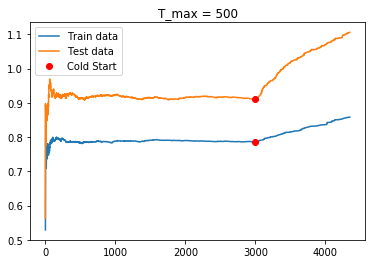

In [63]:
loss_train,L_train = loss_rmse(lUtrain,lVtrain,M_train)
loss_test,L_test = loss_rmse(lUtrain,lVtrain,M_test)
print("RMSE train :",loss_train)
print("RMSE test :",loss_test)
loss_train,_ = loss_rmse(lUtrain[3000:],lVtrain,M_train[3000:,:])
loss_test,_ = loss_rmse(lUtrain[3000:],lVtrain,M_test[3000:,:])
print("RMSE train (U_i > 3000) :",loss_train)
print("RMSE test (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Train data")
plt.plot(L_test,label="Test data")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Cold Start")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 500")
plt.legend()
plt.show()

Malgrès une très légére amélioration, les résultats restent très peu satisfaisant puisque l'on obtient une loss de $1.4$ sur l'ensemble de test.

On constate que cette méthode marche beaucoup moins bien : le problème, c'est que nous n'avons que peu de notes pour chaque utilisateur et donc il devient difficile d'établir ses features en se basant uniquement sur ces données.

De plus, il faut voir que les algorithmes de Linear Bandit ne sont pas initialement prévus pour de la prédiction de notes (mesure **RMSE**) mais de la recommendation. 

Regardons donc plutôt si les films que notre algorithme apprends à recommander sont bien ceux que l'utilisateur va préférer (note maximale de l'utilisateur).

In [64]:
def eval_accuracy(U,V,M,seen_users,k=1):
    nb_users = len(U)
    total = 0
    count = 0
    for i in range(nb_users):
        prodscals = [(U[i].dot(V[m_j]),m_j) for m_j in seen_users[i]]
        best_movies = [bmi[1] for bmi in sorted(prodscals)[-1:-1-k:-1]]
        if max(M[i]) in [M[i,bmi] for bmi in best_movies]:
            count += 1
        total += 1
    return count /total

In [65]:
seen_users_train,_ = what_is_seen(M_train)
seen_users_test,_ = what_is_seen(M_test)
print("Acc train (MF) :",eval_accuracy(gUtrain_complete,gVtrain_complete,M_train,seen_users_train))
print("Acc test (MF) :",eval_accuracy(gUtrain_complete,gVtrain_complete,M_test,seen_users_test))
print("Acc train (Bandit) :",eval_accuracy(lUtrain,lVtrain,M_train,seen_users_train))
print("Acc test (Bandit) :",eval_accuracy(lUtrain,lVtrain,M_test,seen_users_test))
print("Acc train (Bandit) (> 3000) :",eval_accuracy(lUtrain[3000:],lVtrain,M_train[3000:],seen_users_train[3000:]))
print("Acc test (Bandit) (> 3000) :",eval_accuracy(lUtrain[3000:],lVtrain,M_test[3000:],seen_users_test[3000:]))

Acc train (MF) : 0.7931509997701678
Acc test (MF) : 0.654102505171225
Acc train (Bandit) : 0.8568145253964606
Acc test (Bandit) : 0.6384739140427488
Acc train (Bandit) (> 3000) : 0.9940784603997039
Acc test (Bandit) (> 3000) : 0.5928941524796447


**Overfitting** : Les données de Train apprennent parfaitement à renvoyer le film avec le plus grand potentiel (quasiment 100% d'accuracy), mais cela n'est pas généralisable aux données de Test (moins de 65% d'accuracy).


## F.3 Un mix des deux méthodes ...

Que se passe-t-il si on mélange les deux méthodes ? C'est-à-dire on prend la note seulement si elle existe, sinon on utilise les features de la matrice entière pour calculer la récompense.

In [66]:
def M2LinUCB_select_movie(est_features_user,est_features_movies,features_users,features_movies,user_ind,ratings,sigma,alpha,N,nb_sugg,nb_movies):
    prod_scal = [est_features_user.dot(est_features_movies[i])+alpha/np.sqrt(N[i]+1) for i in range(nb_movies)]
    chosen_movies = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    rewards = []
    for i in range(nb_sugg):
        if ratings[user_ind,chosen_movies[i]] > 0:
            rewards.append(ratings[user_ind,chosen_movies[i]] + np.random.normal(0,sigma))
        else:
            rewards.append(features_users[user_ind].dot(features_movies[chosen_movies[i]]))
    return chosen_movies, rewards

def M2LinUCB_select_user(est_features_movie,est_features_users,features_users,features_movies,movie_ind,ratings,sigma,alpha,N,nb_sugg,nb_users):
    prod_scal = [est_features_users[i].dot(est_features_movie)+alpha/np.sqrt(N[i]+1) for i in range(nb_users)]
    chosen_users = np.argsort(prod_scal)[-1:-1-nb_sugg:-1]
    rewards = []
    for i in range(nb_sugg):
        if ratings[chosen_users[i],movie_ind] > 0:
            rewards.append(ratings[chosen_users[i],movie_ind] + np.random.normal(0,sigma))
        else:
            rewards.append(features_users[chosen_users[i]].dot(features_movies[movie_ind]))
    return chosen_users, rewards

In [67]:
def M2LinUCB_real(start_movies,start_users,ratings,features_users,features_movies,users_seen,movies_seen,lambd=0.1,sigma=0.5,new_elems=10,T_max=1000,nb_sugg=5,big_step=1,verbose=False,proba=1/4):
    if verbose:
        print("INIT...")
    (n,m) = ratings.shape
    d = len(start_movies[0])
    (nb_movies,nb_users) = (len(start_movies),len(start_users))
    features_users_l = start_users
    features_movies_l = start_movies
    alpha = np.sqrt(2*np.log(T_max)/np.log(10))
    for elemi in range(new_elems):
        if nb_movies == m and nb_users == n:
            return features_users_l,features_movies_l
        elif nb_movies == m:
            nb_users += 1
            is_user = True
        elif nb_users == n:
            nb_movies += 1
            is_user = False
        else:
            r = np.random.rand()
            if r < proba:
                nb_movies += 1
                is_user = False
            else:
                nb_users += 1
                is_user = True
        if is_user:
            if verbose:
                print(elemi,". ADDING USER ",nb_users)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        else:
            if verbose:
                print(elemi,". ADDING MOVIE ",nb_movies)
            V,D,theta,N = LinUCB_init(nb_users,d,lambd)
        for t in range(T_max):
            if is_user:
                chosen_movies,rewards = M2LinUCB_select_movie(theta,features_movies_l,features_users,features_movies,nb_users-1,ratings,sigma,alpha,N,nb_sugg,nb_movies)
                for i in range(nb_sugg):
                    V += np.outer(features_movies_l[chosen_movies[i]],features_movies_l[chosen_movies[i]])
                    D += features_movies_l[chosen_movies[i]]*rewards[i]
                    N[chosen_movies[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
            else:
                chosen_users,rewards = M2LinUCB_select_user(theta,features_users_l,features_users,features_movies,nb_movies-1,ratings,sigma,alpha,N,nb_sugg,nb_users)
                for i in range(nb_sugg):
                    V += np.outer(features_users_l[chosen_users[i]],features_users_l[chosen_users[i]])
                    D += features_users_l[chosen_users[i]]*rewards[i]
                    N[chosen_users[i]]+= 1
                if t%big_step == 0:
                    theta = np.linalg.inv(V).dot(D)
        if is_user:
            features_users_l = np.vstack((features_users_l,[theta]))
        else:
            features_movies_l = np.vstack((features_movies_l,[theta]))
    return features_users_l,features_movies_l

In [68]:
np.random.seed(0)
l2Utrain,l2Vtrain = M2LinUCB_real(gVtrain,gUtrain,M_train,gUtrain_complete,gVtrain_complete,users_seen_train,movies_seen_train,new_elems=7000,verbose=True,T_max=100,nb_sugg=5,big_step=2,proba=1/10)

INIT...
0 . ADDING USER  3001
1 . ADDING MOVIE  151
2 . ADDING USER  3002
3 . ADDING USER  3003
4 . ADDING USER  3004
5 . ADDING USER  3005
6 . ADDING USER  3006
7 . ADDING USER  3007
8 . ADDING USER  3008
9 . ADDING USER  3009
10 . ADDING USER  3010
11 . ADDING USER  3011
12 . ADDING USER  3012
13 . ADDING USER  3013
14 . ADDING USER  3014
15 . ADDING USER  3015
16 . ADDING USER  3016
17 . ADDING USER  3017
18 . ADDING USER  3018
19 . ADDING MOVIE  152
20 . ADDING USER  3019
21 . ADDING USER  3020
22 . ADDING MOVIE  153
23 . ADDING USER  3021
24 . ADDING USER  3022
25 . ADDING USER  3023
26 . ADDING USER  3024
27 . ADDING MOVIE  154
28 . ADDING USER  3025
29 . ADDING USER  3026
30 . ADDING USER  3027
31 . ADDING USER  3028
32 . ADDING USER  3029
33 . ADDING USER  3030
34 . ADDING USER  3031
35 . ADDING USER  3032
36 . ADDING USER  3033
37 . ADDING MOVIE  155
38 . ADDING USER  3034
39 . ADDING USER  3035
40 . ADDING USER  3036
41 . ADDING USER  3037
42 . ADDING USER  3038
43 . ADDING U

346 . ADDING USER  3306
347 . ADDING USER  3307
348 . ADDING USER  3308
349 . ADDING USER  3309
350 . ADDING USER  3310
351 . ADDING USER  3311
352 . ADDING MOVIE  192
353 . ADDING USER  3312
354 . ADDING USER  3313
355 . ADDING USER  3314
356 . ADDING USER  3315
357 . ADDING USER  3316
358 . ADDING USER  3317
359 . ADDING USER  3318
360 . ADDING USER  3319
361 . ADDING USER  3320
362 . ADDING USER  3321
363 . ADDING USER  3322
364 . ADDING MOVIE  193
365 . ADDING USER  3323
366 . ADDING USER  3324
367 . ADDING USER  3325
368 . ADDING USER  3326
369 . ADDING USER  3327
370 . ADDING MOVIE  194
371 . ADDING USER  3328
372 . ADDING USER  3329
373 . ADDING USER  3330
374 . ADDING USER  3331
375 . ADDING USER  3332
376 . ADDING USER  3333
377 . ADDING USER  3334
378 . ADDING MOVIE  195
379 . ADDING USER  3335
380 . ADDING USER  3336
381 . ADDING USER  3337
382 . ADDING USER  3338
383 . ADDING USER  3339
384 . ADDING USER  3340
385 . ADDING USER  3341
386 . ADDING USER  3342
387 . ADDING USE

688 . ADDING USER  3632
689 . ADDING USER  3633
690 . ADDING USER  3634
691 . ADDING USER  3635
692 . ADDING USER  3636
693 . ADDING USER  3637
694 . ADDING USER  3638
695 . ADDING USER  3639
696 . ADDING USER  3640
697 . ADDING USER  3641
698 . ADDING USER  3642
699 . ADDING USER  3643
700 . ADDING USER  3644
701 . ADDING USER  3645
702 . ADDING USER  3646
703 . ADDING USER  3647
704 . ADDING USER  3648
705 . ADDING USER  3649
706 . ADDING USER  3650
707 . ADDING USER  3651
708 . ADDING USER  3652
709 . ADDING USER  3653
710 . ADDING USER  3654
711 . ADDING USER  3655
712 . ADDING USER  3656
713 . ADDING USER  3657
714 . ADDING USER  3658
715 . ADDING USER  3659
716 . ADDING USER  3660
717 . ADDING USER  3661
718 . ADDING USER  3662
719 . ADDING USER  3663
720 . ADDING USER  3664
721 . ADDING USER  3665
722 . ADDING USER  3666
723 . ADDING USER  3667
724 . ADDING USER  3668
725 . ADDING USER  3669
726 . ADDING USER  3670
727 . ADDING USER  3671
728 . ADDING USER  3672
729 . ADDING USE

1029 . ADDING USER  3973
1030 . ADDING USER  3974
1031 . ADDING USER  3975
1032 . ADDING USER  3976
1033 . ADDING USER  3977
1034 . ADDING USER  3978
1035 . ADDING USER  3979
1036 . ADDING USER  3980
1037 . ADDING USER  3981
1038 . ADDING USER  3982
1039 . ADDING USER  3983
1040 . ADDING USER  3984
1041 . ADDING USER  3985
1042 . ADDING USER  3986
1043 . ADDING USER  3987
1044 . ADDING USER  3988
1045 . ADDING USER  3989
1046 . ADDING USER  3990
1047 . ADDING USER  3991
1048 . ADDING USER  3992
1049 . ADDING USER  3993
1050 . ADDING USER  3994
1051 . ADDING USER  3995
1052 . ADDING USER  3996
1053 . ADDING USER  3997
1054 . ADDING USER  3998
1055 . ADDING USER  3999
1056 . ADDING USER  4000
1057 . ADDING USER  4001
1058 . ADDING USER  4002
1059 . ADDING USER  4003
1060 . ADDING USER  4004
1061 . ADDING USER  4005
1062 . ADDING USER  4006
1063 . ADDING USER  4007
1064 . ADDING USER  4008
1065 . ADDING USER  4009
1066 . ADDING USER  4010
1067 . ADDING USER  4011
1068 . ADDING USER  4012


1359 . ADDING USER  4303
1360 . ADDING USER  4304
1361 . ADDING USER  4305
1362 . ADDING USER  4306
1363 . ADDING USER  4307
1364 . ADDING USER  4308
1365 . ADDING USER  4309
1366 . ADDING USER  4310
1367 . ADDING USER  4311
1368 . ADDING USER  4312
1369 . ADDING USER  4313
1370 . ADDING USER  4314
1371 . ADDING USER  4315
1372 . ADDING USER  4316
1373 . ADDING USER  4317
1374 . ADDING USER  4318
1375 . ADDING USER  4319
1376 . ADDING USER  4320
1377 . ADDING USER  4321
1378 . ADDING USER  4322
1379 . ADDING USER  4323
1380 . ADDING USER  4324
1381 . ADDING USER  4325
1382 . ADDING USER  4326
1383 . ADDING USER  4327
1384 . ADDING USER  4328
1385 . ADDING USER  4329
1386 . ADDING USER  4330
1387 . ADDING USER  4331
1388 . ADDING USER  4332
1389 . ADDING USER  4333
1390 . ADDING USER  4334
1391 . ADDING USER  4335
1392 . ADDING USER  4336
1393 . ADDING USER  4337
1394 . ADDING USER  4338
1395 . ADDING USER  4339
1396 . ADDING USER  4340
1397 . ADDING USER  4341
1398 . ADDING USER  4342


RMSE train : 0.831925296119167
RMSE test : 0.9390630123767468
RMSE train (U_i > 3000) : 0.8608623540932383
RMSE test (U_i > 3000) : 0.9441204051737535


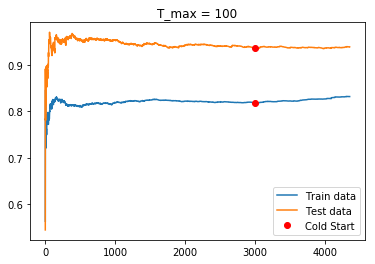

In [69]:
loss_train,L_train = loss_rmse(l2Utrain,l2Vtrain,M_train)
loss_test,L_test = loss_rmse(l2Utrain,l2Vtrain,M_test)
print("RMSE train :",loss_train)
print("RMSE test :",loss_test)
loss_train,_ = loss_rmse(l2Utrain[3000:],l2Vtrain,M_train[3000:,:])
loss_test,_ = loss_rmse(l2Utrain[3000:],l2Vtrain,M_test[3000:,:])
print("RMSE train (U_i > 3000) :",loss_train)
print("RMSE test (U_i > 3000) :",loss_test)
plt.plot(L_train,label="Train data")
plt.plot(L_test,label="Test data")
plt.plot([2999],[L_train[2999]],'o',color="red",label="Cold Start")
plt.plot([2999],[L_test[2999]],'o',color="red")
plt.title("T_max = 100")
plt.legend()
plt.show()

La loss RMSE semble se rapprocher de celle de la première méthode, ce qui est plutot rassurant.

In [70]:
print("Acc train (Bandit) :",eval_accuracy(l2Utrain,l2Vtrain,M_train,seen_users_train))
print("Acc test (Bandit) :",eval_accuracy(l2Utrain,l2Vtrain,M_test,seen_users_test))
print("Acc train (Bandit) (> 3000) :",eval_accuracy(l2Utrain[3000:],l2Vtrain,M_train[3000:],seen_users_train[3000:]))
print("Acc test (Bandit) (> 3000) :",eval_accuracy(l2Utrain[3000:],l2Vtrain,M_test[3000:],seen_users_test[3000:]))

Acc train (Bandit) : 0.831303148701448
Acc test (Bandit) : 0.654102505171225
Acc train (Bandit) (> 3000) : 0.9141376757957069
Acc test (Bandit) (> 3000) : 0.6476683937823834


De plus, l'algorithme apprend également à renvoyer un film auquel l'utilisateur va donner la note maximale, et **cela même pour l'ensemble de test** (presque 70% d'accuracy)

# Conclusion

Nous avons ici présenté une approche permettant d'apprendre les features de nouveaux arrivants sur un réseau de recommandation entre deux calculs (qui peuvent être long et coûteux) des features grâce à une méthode plus performante. Notre méthode a montré être efficace, malgré une augmentation évidente de la loss par rapport aux autres méthodes qui ne sont pas on-line. 

Nous pensons qu'il serait possible d'améliorer les results (RMSE, Accuracy) en trouvant les paramètres idéaux, et nous pensons notamment que cette approche à un potentiel qu'il serait intéressant d'exploiter.

On pourrait améliorer encore notre modèle en modélisant les utilisateurs qui suppriment leur compte et les films qui sont retirés du store. On pourrait également tester cette méthode avec l'ALGO 1 de la seconde partie, ou encore l'algo hybridLinUCB.

# Annexes 
### Etude de sensibilité hyper paramètres LinUCB disjoint 

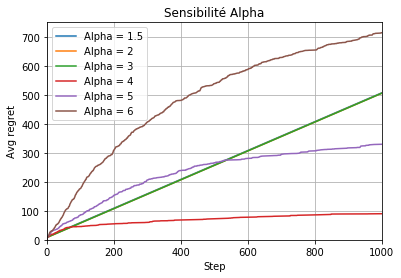

In [71]:
# sensibilité alpha
T_max = 1000
alpha = [1.5, 2, 3, 4, 5, 6]
sigma = 0.5
lambd = 0.1
r = np.random.randint(len(U))

best_score = np.max([U[r].dot(Vt.T[i]) for i in range(207)])

avg_regret_sensi1 = [[0] * T_max for i in range(len(alpha))]
for i in range(len(alpha)):
    for _ in range(3):
        reward, chosen_arm, regret = LinUCB_paper(Vt, U, r,  alpha[i], sigma, lambd, T_max, best_score=best_score) 
        for j in range(T_max):
            avg_regret_sensi1[i][j] += regret[j]
    for k in range(T_max):
        avg_regret_sensi1[i][k] /= 3
    
    plt.plot(avg_regret_sensi1[i], label='Alpha = %s' % alpha[i])

plt.xlim(1,T_max)
#plt.xscale('log')
plt.xlabel("Step")
plt.ylabel("Avg regret")
plt.title(r"Sensibilité Alpha")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

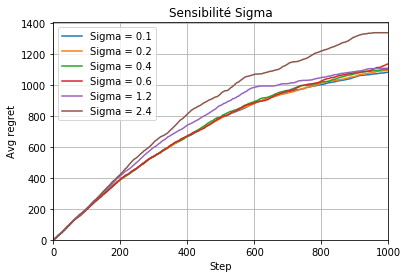

In [72]:
# sensibilité sigma
T_max = 1000
alpha = 5
sigma = [0.1, 0.2, 0.4, 0.6, 1.2, 2.4]
lambd = 0.1
r = np.random.randint(len(U))

best_score = np.max([U[r].dot(Vt.T[i]) for i in range(207)])

avg_regret_sensi2 = [[0] * T_max for i in range(len(sigma))]
for i in range(len(sigma)):
    for _ in range(3):
        reward, chosen_arm, regret = LinUCB_paper(Vt, U, r,  alpha, sigma[i], lambd, T_max, best_score=best_score) 
        for j in range(T_max):
            avg_regret_sensi2[i][j] += regret[j]
    for k in range(T_max):
        avg_regret_sensi2[i][k] /= 3
    
    plt.plot(avg_regret_sensi2[i], label='Sigma = %s' % sigma[i])

plt.xlim(1,T_max)
#plt.xscale('log')
plt.xlabel("Step")
plt.ylabel("Avg regret")
plt.title(r"Sensibilité Sigma")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

In [75]:
# sensibilité sur K (nombre de features)
import time

acc = []
time_to_compute = []

K = range(5, 40, 5)
for j in K:
    U, s, Vt = svds(M, k = j)
    s=np.diag(s)
    U = np.dot(U,s)
    
    time_start = time.clock()
    
    T_max = 10000
    alpha = 5.5
    sigma = 0.5
    lambd = 0.1

    maxlen = len(U)
    count = 0

    rTab = np.random.choice([i for i in range(len(U))],100,replace=False)

    for u in range(100):
        r = rTab[u]
        print(r,":",1+u,"/100")
        best = np.argmax([U[r].dot(Vt.T[i]) for i in range(207)])
        reward, chosen_arm, regret = LinUCB_paper(Vt, U, r,  alpha, sigma, lambd, T_max) 
        if chosen_arm == best:
            count += 1
    time_elapsed = (time.clock() - time_start)
    print("Accuracy : ",count/100)
    tmp = count/100
    acc.append(tmp)
    time_to_compute.append(time_elapsed)

C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


3817 : 1 /100
1518 : 2 /100
2951 : 3 /100
738 : 4 /100
1829 : 5 /100
2174 : 6 /100
814 : 7 /100
463 : 8 /100
724 : 9 /100
1662 : 10 /100
3856 : 11 /100
3678 : 12 /100
430 : 13 /100
1986 : 14 /100
2436 : 15 /100
4159 : 16 /100
1582 : 17 /100
1968 : 18 /100
687 : 19 /100
2407 : 20 /100
3912 : 21 /100
3219 : 22 /100
3009 : 23 /100
2785 : 24 /100
1667 : 25 /100
3096 : 26 /100
1487 : 27 /100
1106 : 28 /100
2194 : 29 /100
3788 : 30 /100
2826 : 31 /100
1154 : 32 /100
4206 : 33 /100
1073 : 34 /100
2628 : 35 /100
4275 : 36 /100
1787 : 37 /100
1393 : 38 /100
2394 : 39 /100
3049 : 40 /100
566 : 41 /100
1733 : 42 /100
1526 : 43 /100
696 : 44 /100
4119 : 45 /100
2141 : 46 /100


KeyboardInterrupt: 

In [ ]:
import pandas
ttc = [i/100 for i in time_to_compute]
l = [K, acc, ttc]
df = pandas.DataFrame(l).transpose()
df.columns = ["Nombre de features","Accuracy", "Temps d'exécution par trial"]
df